## Eval model performance across TF dosage
Adapted from Surag Nair

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import pyBigWig
import pyfaidx
import scipy.stats
import matplotlib.pyplot as plt
import sys
import os
import glob
import json
import seaborn as sns
import pickle
import chrombpnet.training.utils.one_hot as one_hot
import chrombpnet.training.utils.losses as losses
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects
import chrombpnet.evaluation.make_bigwigs.bigwig_helper as bigwig_helper
from collections import Counter

2025-01-01 13:39:56.632807: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/imagemagick/7.0.7-2/lib:/share/software/user/open/fftw/3.3.6/lib:/share/software/user/open/openmpi/2.0.2/lib:/share/software/user/open/R/4.1.2/lib64/R/lib:/share/software/user/open/readline/7.0/lib:/share/software/user/open/gsl/2.3/lib:/share/software/user/open/texinfo/6.6/lib:/share/software/user/open/perl/5.26.0/lib:/share/software/user/open/libtiff/4.0.8/lib:/share/software/user/open/pango/1.40.10/lib:/share/software/user/open/harfbuzz/1.4.8/lib:/share/software/user/open/icu/59.1/lib:/share/software/user/open/curl/8.4.0/lib:/share/software/user/open/openssl/3.0.7/lib64:/share/software/user/open/xz/5.2.3/lib:/share/software/user/open/pcre2/10.35/lib:/share/software/user/open/libjpeg-turbo/1.5.1/lib:/share/software/

In [2]:
def load_model_wrapper(model_hdf5):
    # read .h5 model
    custom_objects={"multinomial_nll":losses.multinomial_nll, "tf": tf}    
    get_custom_objects().update(custom_objects)    
    model=load_model(model_hdf5, compile=False)
    print("got the model")
    model.summary()
    return model

def get_seq(peaks_df, genome, width):
    """
    fetches sequence from a given genome.
    adapted from chrombpnet.evaluation.make_bigwigs.bigwig_helper.get_seq()
    """
    vals = []
    peaks_used = []
    for i, r in peaks_df.iterrows():
        sequence = str(genome[r['chr']][(r['start']+r['summit'] - width//2):(r['start'] + r['summit'] + width//2)])
        if len(sequence) == width:
            vals.append(sequence)
            peaks_used.append(True)
        else:
            peaks_used.append(False)
    return np.array(vals), one_hot.dna_to_one_hot(vals), np.array(peaks_used)

# insert replacement into the sequence between motif_start and motif_end
def mod_sequence(s, rep, motif_start, motif_end):
    return s[:motif_start] + rep + s[motif_end:]

def softmax(x):
    norm_x = x - np.mean(x)
    return np.exp(norm_x)/np.sum(np.exp(norm_x))

In [ ]:
# user inputs
base_dir = "../../"
models_dir = base_dir + "/output/04-chrombpnet/output/models/fold_0/"
celltype = "HEK293T"
control = "GFP_d100"
TF = "KLF1"

genome = f"{base_dir}/data/chrombp_resources/hg38.fa"
chromsizes = f"{base_dir}/data/chrombp_resources/hg38.chrom.sizes"
control_peaks_path = f"{base_dir}/output/02-atac/01/consensus_peaks_HEK293T_10col.bed"

outdir = f"{base_dir}/output/02-atac/15/"
plotdir = f"{base_dir}/output/02-atac/15/"
os.makedirs(outdir, exist_ok=True)
os.makedirs(plotdir, exist_ok=True)

NARROWPEAK_SCHEMA = ["chr", "start", "end", "1", "2", "3", "4", "5", "6", "summit"]
INP_LEN, OUT_LEN = 2114, 1000

n_bgd = 1000 # number of backgrounds for prediction
batch_size = 1000 # number of bgds per batch, used to speed up processing

TEST_CHRS = ['chr1','chr3','chr6']
SAMPLES = ["GFP_d100", f"{TF}_d005", f"{TF}_d025", f"{TF}_d050", f"{TF}_d075", f"{TF}_d100"]
hg38 = pyfaidx.Fasta(genome)

### Get basic model QC

In [143]:
json_ls = glob.glob(f"{models_dir}/*/evaluation/chrombpnet_metrics.json")

In [144]:
out = {}
for i in range(len(json_ls)):
    f = json_ls[i]
    name = f.split('/')[-3]
    with open(f) as json_data:
        d = json.load(json_data)
        out[name] = [d['counts_metrics']['peaks']['spearmanr'], d['counts_metrics']['peaks']['pearsonr'],
                    d['profile_metrics']['peaks']['median_jsd'], d['profile_metrics']['peaks']['median_norm_jsd']]

In [145]:
df = pd.DataFrame(out).transpose()
df.columns = ["counts_spearmanr", "counts_pearsonr", "profile_median_jsd", "profile_median_norm_jsd"]
df.head()

counts_spearmanr  counts_pearsonr  profile_median_jsd  \
HEK293T_EF1a-SPI1_d050          0.623783         0.718147            0.697505   
HEK293T_EF1a-SPI1_d075          0.619006         0.721204            0.686347   
HEK293T_EF1a-SPI1_d100          0.606617         0.708173            0.646176   
HEK293T_EF1a-SPI1_d025          0.672863         0.734999            0.740514   
HEK293T_EF1a-SPI1_d005          0.618932         0.710221            0.729833   

                        profile_median_norm_jsd  
HEK293T_EF1a-SPI1_d050                 0.116204  
HEK293T_EF1a-SPI1_d075                 0.128429  
HEK293T_EF1a-SPI1_d100                 0.164398  
HEK293T_EF1a-SPI1_d025                 0.077570  
HEK293T_EF1a-SPI1_d005                 0.085507

In [119]:
# add meta data
df["TF"] = [n.split("_")[1] for n in df.index]
df.loc[df["TF"]=="EF1a-KLF1", "TF"] = "KLF1"
df.loc[df["TF"]=="EF1a-SPI1", "TF"] = "SPI1"
df.loc[df["TF"]=="tet-CTCF", "TF"] = "tetCTCF"

df["dose"] = [int(n.split("_")[2].split("d")[1]) for n in df.index]
df["dose_str"] = [n.split("_")[2] for n in df.index]
df["sample"] = "HEK293T" + "_" + df.TF + "_" + df.dose_str

df.head()

counts_spearmanr  counts_pearsonr  profile_median_jsd  \
HEK293T_KLF4_d050           0.608497         0.645684            0.721736   
HEK293T_NR4A1_d050          0.586120         0.728270            0.679823   
HEK293T_PRDM1_d075          0.597188         0.708191            0.680581   
HEK293T_GFP_d100            0.611515         0.704020            0.688515   
HEK293T_TCF3_d075           0.641553         0.659162            0.610994   

                    profile_median_norm_jsd     TF  dose              sample  \
HEK293T_KLF4_d050                  0.094681   KLF4    50   HEK293T_KLF4_d050   
HEK293T_NR4A1_d050                 0.127382  NR4A1    50  HEK293T_NR4A1_d050   
HEK293T_PRDM1_d075                 0.126755  PRDM1    75  HEK293T_PRDM1_d075   
HEK293T_GFP_d100                   0.115340    GFP   100    HEK293T_GFP_d100   
HEK293T_TCF3_d075                  0.182984   TCF3    75   HEK293T_TCF3_d075   

                   dose_str  
HEK293T_KLF4_d050      d050  
HEK293T_NR4A1_d050     d050  
HEK293T_PRDM1_d075     d075  
HEK293T_GFP_d100       d100  
HEK293T_TCF3_d075      d075

In [ ]:
counts = pd.read_table(f"{base_dir}/output/01-preprocessing/output/bams/qc/compiled_counts.txt")
counts["celltype"] = [n.split("_")[0] for n in counts.sample_label]
counts["TF"] = [n.split("_")[2] for n in counts.sample_label]
counts["dose"] = [n.split("_")[3] for n in counts.sample_label]
counts["celltype_TF_dose"] = counts.celltype + "_" + counts.TF + "_" + counts.dose
counts.head()

sample_label     total  post_mitochondria  post_filter  \
0  HEK293T_P1A10_BACH2_d025  18351374           13845637      8137876   
1  HEK293T_P1A11_BACH2_d005  17164566           12824355      8138392   
2    HEK293T_P1A12_GFP_d100  19701103           15074715      9307409   
3     HEK293T_P1A2_SP4_d100  33864828           25966939     16052267   
4     HEK293T_P1A3_SP4_d075  16531848           12919173      7732178   

   post_dedup celltype     TF  dose    celltype_TF_dose  
0     5789300  HEK293T  BACH2  d025  HEK293T_BACH2_d025  
1     6415118  HEK293T  BACH2  d005  HEK293T_BACH2_d005  
2     7489757  HEK293T    GFP  d100    HEK293T_GFP_d100  
3    10126450  HEK293T    SP4  d100    HEK293T_SP4_d100  
4     5281928  HEK293T    SP4  d075    HEK293T_SP4_d075

In [120]:
df = pd.merge(df, counts.groupby("celltype_TF_dose").sum(), left_on="sample", right_index=True, how="left")

/tmp/ipykernel_169416/237514506.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = pd.merge(df, counts.groupby("celltype_TF_dose").sum(), left_on="sample", right_index=True, how="left")


In [123]:
df

counts_spearmanr  counts_pearsonr  profile_median_jsd  \
HEK293T_KLF4_d050              0.608497         0.645684            0.721736   
HEK293T_NR4A1_d050             0.586120         0.728270            0.679823   
HEK293T_PRDM1_d075             0.597188         0.708191            0.680581   
HEK293T_GFP_d100               0.611515         0.704020            0.688515   
HEK293T_TCF3_d075              0.641553         0.659162            0.610994   
...                                 ...              ...                 ...   
HEK293T_SOX2_d025              0.591843         0.661354            0.727233   
HEK293T_KLF4_d025              0.657089         0.690915            0.743843   
HEK293T_SP4_d005               0.621741         0.727510            0.731620   
HEK293T_OCT4_d005              0.630422         0.717750            0.752445   
HEK293T_tet-CTCF_d100          0.619416         0.703465            0.768892   

                       profile_median_norm_jsd       TF  dose  \
HEK293T_KLF4_d050                     0.094681     KLF4    50   
HEK293T_NR4A1_d050                    0.127382    NR4A1    50   
HEK293T_PRDM1_d075                    0.126755    PRDM1    75   
HEK293T_GFP_d100                      0.115340      GFP   100   
HEK293T_TCF3_d075                     0.182984     TCF3    75   
...                                        ...      ...   ...   
HEK293T_SOX2_d025                     0.093083     SOX2    25   
HEK293T_KLF4_d025                     0.075838     KLF4    25   
HEK293T_SP4_d005                      0.084027      SP4     5   
HEK293T_OCT4_d005                     0.068118     OCT4     5   
HEK293T_tet-CTCF_d100                 0.053362  tetCTCF   100   

                                     sample dose_str      total  \
HEK293T_KLF4_d050         HEK293T_KLF4_d050     d050   34292055   
HEK293T_NR4A1_d050       HEK293T_NR4A1_d050     d050  138106875   
HEK293T_PRDM1_d075       HEK293T_PRDM1_d075     d075  109576414   
HEK293T_GFP_d100           HEK293T_GFP_d100     d100  149464054   
HEK293T_TCF3_d075         HEK293T_TCF3_d075     d075   99521894   
...                                     ...      ...        ...   
HEK293T_SOX2_d025         HEK293T_SOX2_d025     d025   25622111   
HEK293T_KLF4_d025         HEK293T_KLF4_d025     d025   30115038   
HEK293T_SP4_d005           HEK293T_SP4_d005     d005   43106423   
HEK293T_OCT4_d005         HEK293T_OCT4_d005     d005   26398673   
HEK293T_tet-CTCF_d100  HEK293T_tetCTCF_d100     d100   25765219   

                       post_mitochondria  post_filter  post_dedup  
HEK293T_KLF4_d050               29460548     14657923     9963542  
HEK293T_NR4A1_d050             116887741     53413045    26387044  
HEK293T_PRDM1_d075              87508098     48551262    26282263  
HEK293T_GFP_d100               119229915     71775153    58242862  
HEK293T_TCF3_d075               81326460     41350379    29710103  
...                                  ...          ...         ...  
HEK293T_SOX2_d025               22524341     13393566    10198457  
HEK293T_KLF4_d025               25439558     11517147     8372433  
HEK293T_SP4_d005                31927608     19296691    15561114  
HEK293T_OCT4_d005               22282787     13101296    10599269  
HEK293T_tet-CTCF_d100           21983213     13377136     9250571  

[72 rows x 12 columns]

In [ ]:
# color palette
colpal = pd.read_table(f"../utils/colpal_TF.tsv")
colpal.index = colpal.TF
colpal.head()


TF    color
TF                   
SP4      SP4  #D51F26
ELF1    ELF1  #272E6A
FOXP1  FOXP1  #D8A767
GATA1  GATA1  #89288F
BACH2  BACH2  #F47D2B

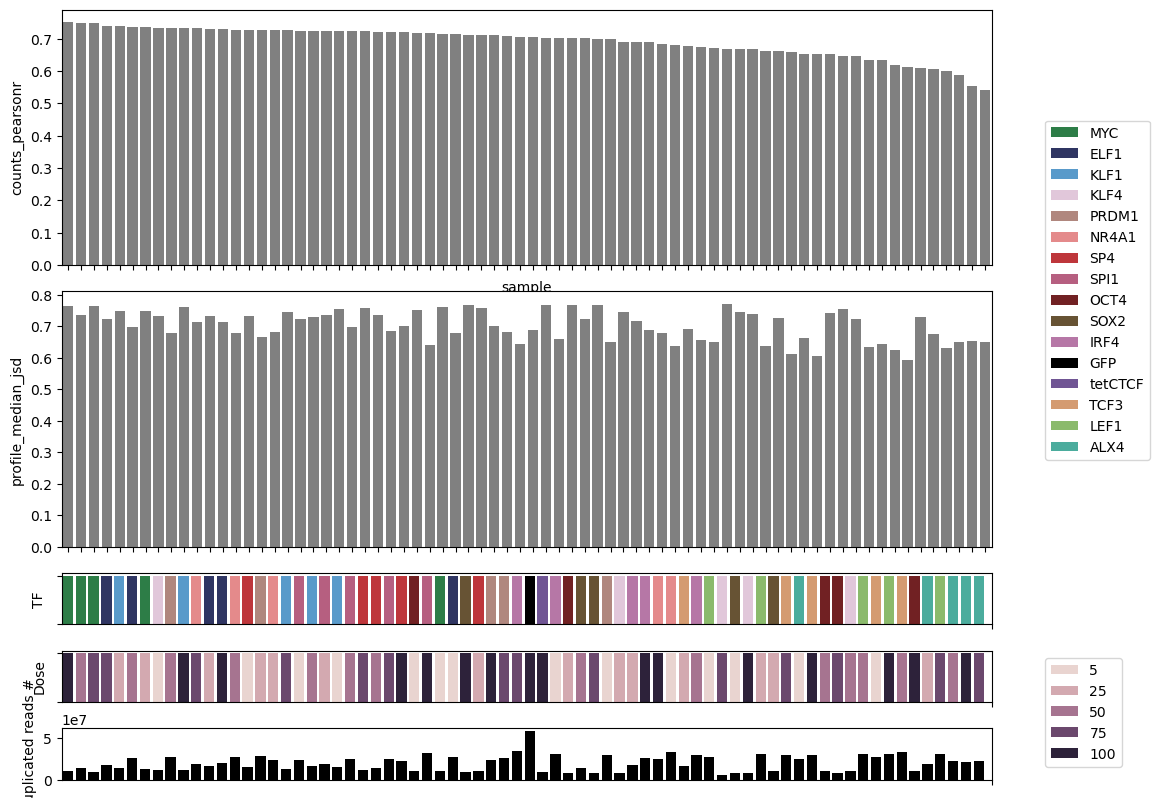

In [142]:
toplot = df.sort_values(by="counts_pearsonr", ascending=False)
sns.set_palette(sns.color_palette(colpal.loc[pd.unique(toplot.TF), "color"]))

f,ax = plt.subplots(5,1, figsize=(12,10), gridspec_kw={'height_ratios': [5, 5, 1, 1, 1]})

# pearson r
sns.barplot(data=toplot, x="sample", y="counts_pearsonr", color="gray", ax=ax[0])
#ax[0].set_xticklabels(toplot["sample"], rotation=90)
ax[0].set_xticklabels("")

# JS distance
sns.barplot(data=toplot, x="sample", y="profile_median_jsd", color="gray", ax=ax[1])
ax[1].set_xticklabels("")
ax[1].set_xlabel("")

# TF
sns.barplot(data=toplot, x="sample", y=1, hue="TF",
            ax=ax[2])
ax[2].set_xticks("")
ax[2].set_xlabel("")
ax[2].set_ylabel("TF")
ax[2].set_xticklabels("")
ax[2].set_yticklabels("")
ax[2].legend(bbox_to_anchor=(1.05, 10), loc='upper left')

# dose
sns.set_palette("viridis")
sns.barplot(data=toplot, x="sample", y=1, hue="dose",
            ax=ax[3])
ax[3].set_xticks("")
ax[3].set_xlabel("")
ax[3].set_ylabel("Dose")
ax[3].set_xticklabels("")
ax[3].set_yticklabels("")
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# nreads
sns.barplot(data=toplot, x="sample", y="post_dedup", color="black",
            ax=ax[4])
ax[4].set_xticks("")
ax[4].set_xlabel("")
ax[4].set_xticklabels("")
ax[4].set_ylabel("Deduplicated reads #")

#plt.tight_layout()
plt.show()
f.savefig(f"{plotdir}/pearsonr_model_qc.pdf")

### Get model QC for 5 fold of SPI1

In [ ]:
# look at SPI1 only all 5 folds
json_ls = glob.glob(f"{base_dir}/output/04-chrombpnet/output/models/fold_*/*SPI1*/evaluation/chrombpnet_metrics.json")

In [ ]:
json_ls[1]

In [148]:
out = {}
for i in range(len(json_ls)):
    f = json_ls[i]
    fold = f.split('/')[-4]
    name = f.split('/')[-3] + "_" + fold
    with open(f) as json_data:
        d = json.load(json_data)
        out[name] = [d['counts_metrics']['peaks']['spearmanr'], d['counts_metrics']['peaks']['pearsonr'],
                    d['profile_metrics']['peaks']['median_jsd'], d['profile_metrics']['peaks']['median_norm_jsd']]

In [152]:
df = pd.DataFrame(out).transpose()
df.columns = ["counts_spearmanr", "counts_pearsonr", "profile_median_jsd", "profile_median_norm_jsd"]
# add meta data
df["TF"] = "SPI1"
df["dose"] = [int(n.split("_")[2].split("d")[1]) for n in df.index]
df["dose_str"] = [n.split("_")[2] for n in df.index]
df["fold"] = [n.split("_")[4] for n in df.index]
df["sample"] = "HEK293T" + "_" + df.TF + "_" + df.dose_str + "_fold" + df.fold
df.head()

counts_spearmanr  counts_pearsonr  \
HEK293T_EF1a-SPI1_d050_fold_1          0.626537         0.732310   
HEK293T_EF1a-SPI1_d075_fold_1          0.612101         0.713781   
HEK293T_EF1a-SPI1_d100_fold_1          0.594589         0.711771   
HEK293T_EF1a-SPI1_d025_fold_1          0.694216         0.746772   
HEK293T_EF1a-SPI1_d005_fold_1          0.634783         0.727139   

                               profile_median_jsd  profile_median_norm_jsd  \
HEK293T_EF1a-SPI1_d050_fold_1            0.686087                 0.126458   
HEK293T_EF1a-SPI1_d075_fold_1            0.677993                 0.135220   
HEK293T_EF1a-SPI1_d100_fold_1            0.640921                 0.168719   
HEK293T_EF1a-SPI1_d025_fold_1            0.730138                 0.086603   
HEK293T_EF1a-SPI1_d005_fold_1            0.712743                 0.100471   

                                 TF  dose dose_str fold  \
HEK293T_EF1a-SPI1_d050_fold_1  SPI1    50     d050    1   
HEK293T_EF1a-SPI1_d075_fold_1  SPI1    75     d075    1   
HEK293T_EF1a-SPI1_d100_fold_1  SPI1   100     d100    1   
HEK293T_EF1a-SPI1_d025_fold_1  SPI1    25     d025    1   
HEK293T_EF1a-SPI1_d005_fold_1  SPI1     5     d005    1   

                                                sample  
HEK293T_EF1a-SPI1_d050_fold_1  HEK293T_SPI1_d050_fold1  
HEK293T_EF1a-SPI1_d075_fold_1  HEK293T_SPI1_d075_fold1  
HEK293T_EF1a-SPI1_d100_fold_1  HEK293T_SPI1_d100_fold1  
HEK293T_EF1a-SPI1_d025_fold_1  HEK293T_SPI1_d025_fold1  
HEK293T_EF1a-SPI1_d005_fold_1  HEK293T_SPI1_d005_fold1

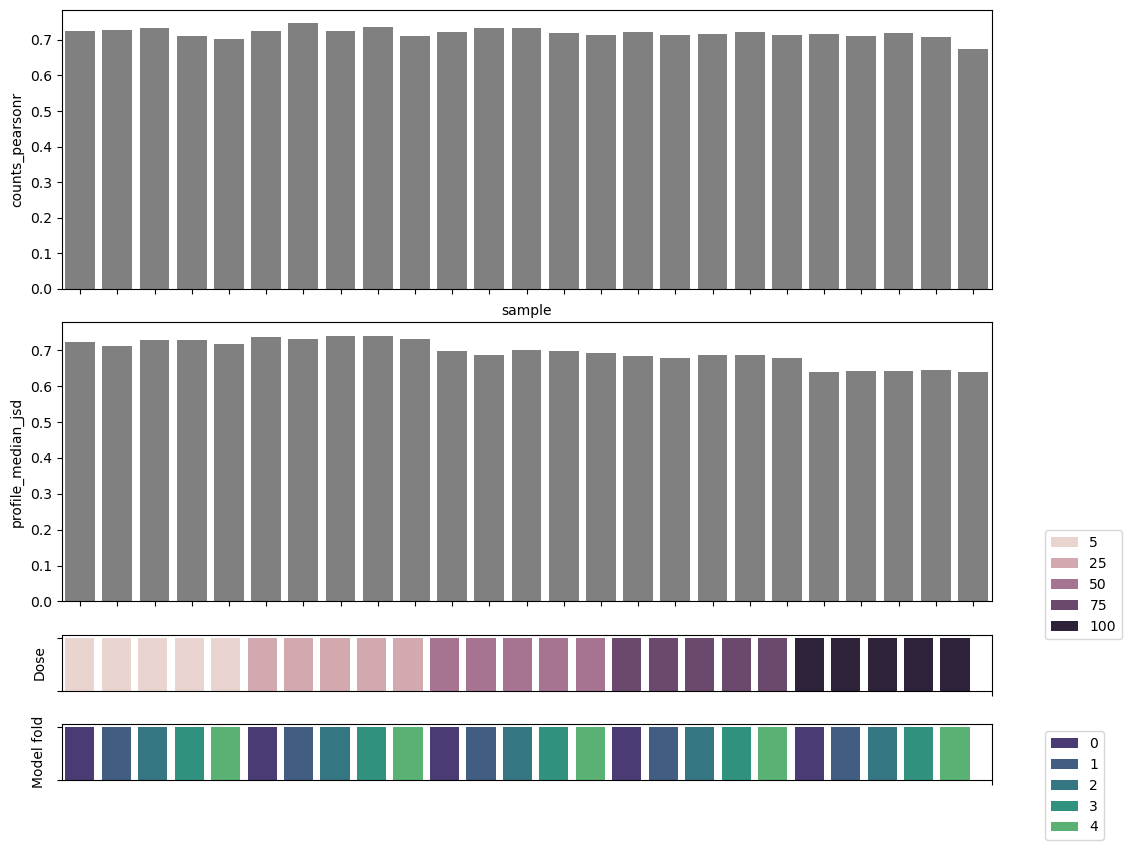

In [156]:
toplot = df.sort_values(by=["dose", "fold"])

f,ax = plt.subplots(4,1, figsize=(12,10), gridspec_kw={'height_ratios': [5, 5, 1, 1]})

# pearson r
sns.barplot(data=toplot, x="sample", y="counts_pearsonr", color="gray", ax=ax[0])
#ax[0].set_xticklabels(toplot["sample"], rotation=90)
ax[0].set_xticklabels("")

# JS distance
sns.barplot(data=toplot, x="sample", y="profile_median_jsd", color="gray", ax=ax[1])
ax[1].set_xticklabels("")
ax[1].set_xlabel("")

# dose
sns.set_palette("viridis")
sns.barplot(data=toplot, x="sample", y=1, hue="dose",
            ax=ax[2])
ax[2].set_xticks("")
ax[2].set_xlabel("")
ax[2].set_ylabel("Dose")
ax[2].set_xticklabels("")
ax[2].set_yticklabels("")
ax[2].legend(bbox_to_anchor=(1.05, 3), loc='upper left')

# fold
sns.set_palette("viridis")
sns.barplot(data=toplot, x="sample", y=1, hue="fold",
            ax=ax[3])
ax[3].set_xticks("")
ax[3].set_xlabel("")
ax[3].set_ylabel("Model fold")
ax[3].set_xticklabels("")
ax[3].set_yticklabels("")
ax[3].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


#plt.tight_layout()
plt.show()
f.savefig(f"{plotdir}/pearsonr_model_qc_SPI1_5fold.pdf")

### Get regions, seqs, actual counts

In [20]:
regions = pd.read_csv(control_peaks_path, sep='\t', names=NARROWPEAK_SCHEMA)
regions.head()

chr   start     end                               1         2  3  4  5  6  \
0  chr1    9954   10456   HEK293T_P3A12_GFP_d100_peak_1   4.80305  .  .  .  .   
1  chr1  778479  778981  HEK293T_P3A12_GFP_d100_peak_17   7.97034  .  .  .  .   
2  chr1  778996  779498   HEK293T_P3G8_SPI1_d075_peak_6   6.47870  .  .  .  .   
3  chr1  779566  780068    HEK293T_P1B6_SP4_d005_peak_3   9.14194  .  .  .  .   
4  chr1  826547  827049  HEK293T_P3G7_SPI1_d100_peak_10  13.83265  .  .  .  .   

   summit  
0     250  
1     250  
2     250  
3     250  
4     250

In [21]:
test_regions = regions[regions['chr'].isin(TEST_CHRS)].reset_index()
test_regions.shape

(154956, 11)

In [22]:
test_regions.loc[0]

index                                 0
chr                                chr1
start                              9954
end                               10456
1         HEK293T_P3A12_GFP_d100_peak_1
2                               4.80305
3                                     .
4                                     .
5                                     .
6                                     .
summit                              250
Name: 0, dtype: object

In [ ]:
seqs_full, seqs, regions_used = get_seq(test_regions, hg38, INP_LEN)
seqs.shape

In [ ]:
test_regions = test_regions[regions_used].reset_index()

In [ ]:
nsample = 50000
idx = np.random.choice(list(range(len(seqs))), size=nsample, replace=False)

In [ ]:
cts = {}

for s in SAMPLES:
    print(s)
    with pyBigWig.open(glob.glob(f"{models_dir}/{celltype}_*{s}/auxiliary/data_unstranded.bw")[0]) as bw:
        counts = []
        reg = test_regions.loc[idx].reset_index()
        for i in range(reg.shape[0]):
            start = reg.loc[i, "start"] + reg.loc[i, "summit"] - OUT_LEN//2
            end = start + OUT_LEN
            val = np.nansum(bw.values(reg.loc[i, "chr"], start, end))
            counts.append(val)
        cts[s] = np.array(counts)

GFP_d100
SPI1_d005
SPI1_d025
SPI1_d050
SPI1_d075
SPI1_d100


### Load models

In [25]:
models = {}
for m in SAMPLES:
    models[m] = keras.models.load_model(glob.glob(f"{models_dir}/{celltype}_*{m}/models/chrombpnet_nobias.h5")[0], compile=False)

2024-10-30 15:26:21.211944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /share/software/user/open/hdf5/1.10.6/lib:/share/software/user/open/szip/2.1.1/lib:/share/software/user/open/openmpi/4.0.3/lib:/share/software/user/open/ucx/1.8.1/lib:/share/software/user/open/libfabric/1.9.1/lib:/usr/lib64/nvidia:/share/software/user/open/cuda/10.2.89/targets/x86_64-linux/lib:/share/software/user/open/cuda/10.2.89/lib64:/share/software/user/open/cuda/10.2.89/nvvm/lib64:/share/software/user/open/cuda/10.2.89/extras/Debugger/lib64:/share/software/user/open/cuda/10.2.89/extras/CUPTI/lib64:/share/software/user/open/cairo/1.14.10/lib:/share/software/user/open/gobject-introspection/1.52.1/lib:/share/software/user/open/glib/2.52.3/lib:/share/software/user/open/libffi/3.2.1/lib64:/share/software/user/open/fontconfig/2.12.4/lib:/share/software

### Normalizing factors

In [ ]:
import subprocess

DEPTH_VECTOR = []

counts_file = f"{base_dir}/output/01-preprocessing/output/bams/qc/compiled_counts.txt"
for s in SAMPLES:
    cmd = f"cat {counts_file}| grep {s} | awk '{{sum += $5}} END {{print sum}}'"
    DEPTH_VECTOR.append(int(subprocess.check_output(cmd, text=True, shell=True).strip()))

DEPTH_VECTOR = np.array(DEPTH_VECTOR)/1e6
print(DEPTH_VECTOR)

[192.80033   89.809282  73.680908  71.045348  62.073855  79.431513]


### Model predictions

In [159]:
preds = {}
for s in SAMPLES:
    preds[s] = models[s].predict(seqs[idx], verbose=True)

1563/1563 [==============================] - 2932s 2s/step


In [160]:
for s in SAMPLES:
    c = scipy.stats.spearmanr(preds[s][1].ravel(), cts[s])
    print(f"{s}\t{c[0]}")

GFP_d100	0.6272377544324053
SPI1_d005	0.6604670815667569
SPI1_d025	0.6534733452232508
SPI1_d050	0.7012269528686845
SPI1_d075	0.6755292484261725
SPI1_d100	0.7067838166445722


In [161]:
pairwise_corrs = np.zeros((len(SAMPLES), len(SAMPLES)))
for i,s1 in enumerate(SAMPLES):
    for j,s2 in enumerate(SAMPLES):
        pairwise_corrs[i][j] = scipy.stats.spearmanr(cts[s1], preds[s2][1].ravel())[0]

In [162]:
pairwise_corrs

array([[0.62723775, 0.58307002, 0.5075579 , 0.52008666, 0.486968  ,
        0.48843388],
       [0.55555508, 0.66046708, 0.6197555 , 0.63202965, 0.58719061,
        0.59238706],
       [0.51673416, 0.65559242, 0.65347335, 0.67013206, 0.63286024,
        0.6394404 ],
       [0.50707069, 0.66309548, 0.67649463, 0.70122695, 0.66364343,
        0.6740058 ],
       [0.49958157, 0.66028933, 0.68201545, 0.71198569, 0.67552925,
        0.68869537],
       [0.50344123, 0.66460942, 0.69219586, 0.72569492, 0.69174912,
        0.70678382]])

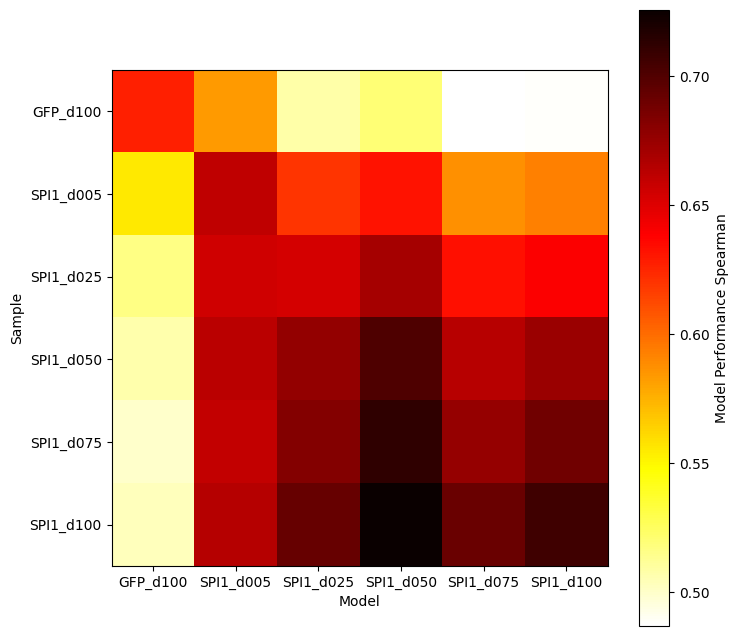

In [163]:
plt.figure(figsize=(8,8))
plt.imshow(pairwise_corrs, cmap='hot_r')
plt.ylabel("Sample")
plt.xlabel("Model")
plt.xticks(ticks=np.arange(len(SAMPLES)), labels=SAMPLES, rotation=0) 
plt.yticks(ticks=np.arange(len(SAMPLES)), labels=SAMPLES, rotation=0) 
plt.colorbar().set_label('Model Performance Spearman')
plt.show()

In [164]:
pairwise_corrs_pearsonr = np.zeros((len(SAMPLES), len(SAMPLES)))
for i,s1 in enumerate(SAMPLES):
    for j,s2 in enumerate(SAMPLES):
        pairwise_corrs_pearsonr[i][j] = scipy.stats.pearsonr(np.log(1+cts[s1]), preds[s2][1].ravel())[0]

In [165]:
pairwise_corrs_pearsonr

array([[0.70902957, 0.67514332, 0.607078  , 0.60263746, 0.591954  ,
        0.59200248],
       [0.65770298, 0.73636468, 0.70526654, 0.70476839, 0.68069043,
        0.68186166],
       [0.62284085, 0.73271479, 0.73774619, 0.74484483, 0.72314389,
        0.72393973],
       [0.60831451, 0.73292996, 0.75178377, 0.76929658, 0.74701052,
        0.75039878],
       [0.59501403, 0.7246348 , 0.75099383, 0.77482898, 0.75372258,
        0.75898604],
       [0.59200128, 0.72216557, 0.75231623, 0.78067571, 0.76089503,
        0.76773021]])

In [166]:
pairwise_corrs_pearsonr.diagonal()

array([0.70902957, 0.73636468, 0.73774619, 0.76929658, 0.75372258,
       0.76773021])

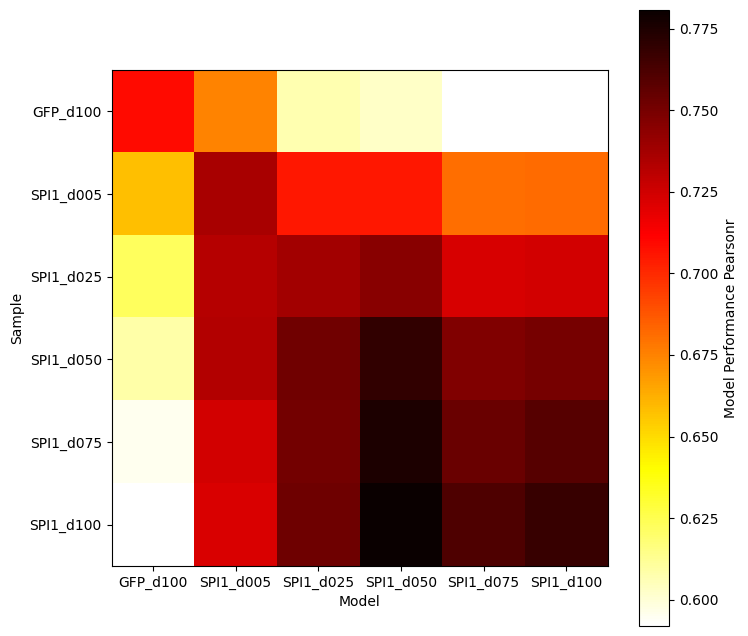

In [167]:
plt.figure(figsize=(8,8))
plt.imshow(pairwise_corrs_pearsonr, cmap='hot_r')
plt.ylabel("Sample")
plt.xlabel("Model")
plt.xticks(ticks=np.arange(len(SAMPLES)), labels=SAMPLES, rotation=0) 
plt.yticks(ticks=np.arange(len(SAMPLES)), labels=SAMPLES, rotation=0) 
plt.colorbar().set_label('Model Performance Pearsonr')
plt.show()

### Per example correlations

In [168]:
pred_logcts_norm = np.array([preds[s][1].ravel() for s in SAMPLES]).T
pred_logcts_norm -= np.log(DEPTH_VECTOR)[None, :]

In [169]:
obs_logcts_norm = np.array([np.log(cts[s] + 1) for s in SAMPLES]).T
obs_logcts_norm -= np.log(DEPTH_VECTOR)[None, :]

In [170]:
per_row_pearson_corrs = [scipy.stats.pearsonr(pred_logcts_norm[i], obs_logcts_norm[i])[0] for i in range(len(obs_logcts_norm))]

In [182]:
pred_logcts_norm[0]

array([-2.9177494, -2.8973954, -3.1828032, -2.6087477, -2.665446 ,
       -2.2365048], dtype=float32)

In [171]:
np.mean(per_row_pearson_corrs), np.median(per_row_pearson_corrs)

(0.4065402263490654, 0.497967861132743)

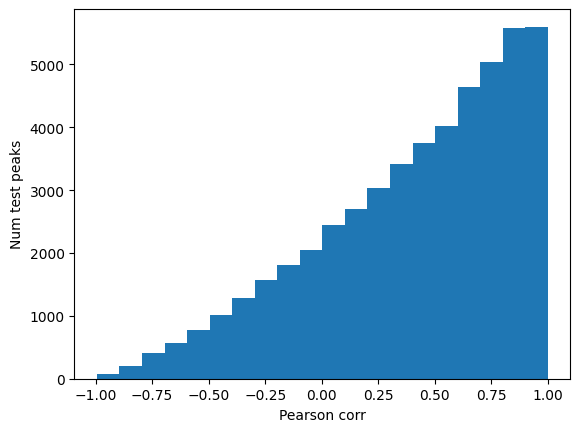

In [172]:
plt.hist(per_row_pearson_corrs, bins=20)
plt.xlabel("Pearson corr")
plt.ylabel("Num test peaks")
plt.show()

What if we permuted it?

In [173]:
obs_logcts_norm_permut = obs_logcts_norm[np.random.permutation(len(obs_logcts_norm))]

In [174]:
per_row_pearson_corrs_permut = [scipy.stats.pearsonr(pred_logcts_norm[i], obs_logcts_norm_permut[i])[0] for i in range(len(obs_logcts_norm_permut))]

In [175]:
np.mean(per_row_pearson_corrs_permut), np.median(per_row_pearson_corrs_permut)

(0.2722711331477547, 0.3332381612705839)

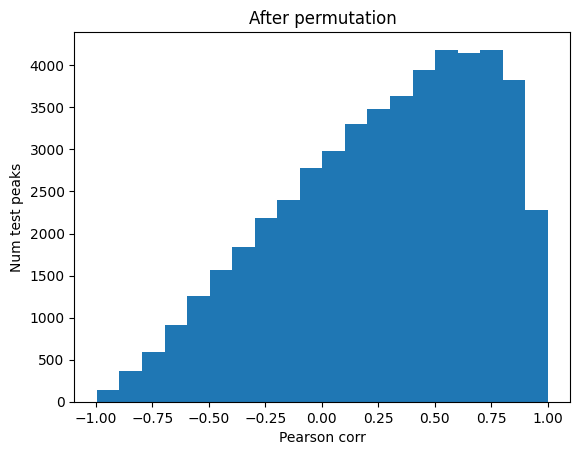

In [176]:
plt.hist(per_row_pearson_corrs_permut, bins=20)
plt.xlabel("Pearson corr")
plt.ylabel("Num test peaks")
plt.title("After permutation")
plt.show()

In [177]:
IDX = np.random.choice(np.where((np.array(per_row_pearson_corrs) > .9))[0])
IDX

45640

In [178]:
per_row_pearson_corrs[IDX]

0.9744979525928896

In [179]:
pred_logcts_norm[IDX]

array([-2.6891901 , -1.6996388 , -1.2619318 , -0.9066153 , -0.48843375,
       -0.4569393 ], dtype=float32)

In [180]:
obs_logcts_norm[IDX]

array([-1.79591919, -1.23959179, -0.89854633, -0.15244451,  0.04606238,
        0.1468934 ])

(array([   36.,   264.,  2291.,  9979., 17096., 12109.,  4761.,  2360.,
          959.,   145.]),
 array([-5.26165509e+00, -4.50925295e+00, -3.75685081e+00, -3.00444867e+00,
        -2.25204653e+00, -1.49964439e+00, -7.47242245e-01,  5.15989685e-03,
         7.57562038e-01,  1.50996418e+00,  2.26236632e+00]),
 <BarContainer object of 10 artists>)

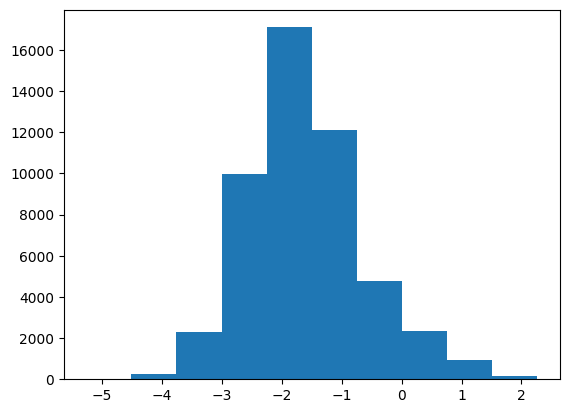

In [181]:
plt.hist(obs_logcts_norm_permut[:,0])

## Pre-existing peak sets

Take peak sets that I called (open nonsensitive, closed nonsensitive, saturating sensitive, nonsaturating sensitive and see avg prediction for those. 

In [ ]:
# this has saturated and nonsaturated sensitive peaks only
obs_peaks = pd.read_csv(f"{base_dir}/output/02-atac/10/sensitivity_{TF}_log2fc0.58_fit.csv", index_col=0)
obs_peaks.head()

m         b  res_linear  \
HEK293T_P1A10_BACH2_d025_peak_112251   0.753292  0.164872    2.043235   
HEK293T_P1A10_BACH2_d025_peak_142321   1.104891 -0.091143    3.413125   
HEK293T_P1A10_BACH2_d025_peak_220577a  0.869034  0.154424    2.495652   
HEK293T_P1A10_BACH2_d025_peak_281553   0.916710  0.015619    4.861309   
HEK293T_P1A10_BACH2_d025_peak_60760    0.912117 -0.048297    4.672616   

                                               h        ka  res_hill  \
HEK293T_P1A10_BACH2_d025_peak_112251    0.486086  0.130681  1.722527   
HEK293T_P1A10_BACH2_d025_peak_142321   10.000000  0.576388  2.813608   
HEK293T_P1A10_BACH2_d025_peak_220577a   1.000953  0.153413  1.827254   
HEK293T_P1A10_BACH2_d025_peak_281553    2.114781  0.505332  5.146772   
HEK293T_P1A10_BACH2_d025_peak_60760     6.737240  0.644982  3.961950   

                                         h_pval       ka_pval  
HEK293T_P1A10_BACH2_d025_peak_112251   0.103176  2.268179e-01  
HEK293T_P1A10_BACH2_d025_peak_142321   0.241513  9.968429e-08  
HEK293T_P1A10_BACH2_d025_peak_220577a  0.020776  3.852649e-02  
HEK293T_P1A10_BACH2_d025_peak_281553   0.200132  5.936471e-03  
HEK293T_P1A10_BACH2_d025_peak_60760    0.182785  4.135033e-07

In [ ]:
obs_peaks = pd.read_csv(f"{base_dir}/output/02-atac/10/{TF}_motif_containing_peak_meta.tsv", sep="\t")
obs_peaks.head()

sensitive saturating  EC50   h   state  \
HEK293T_P2E11_TCF3_d005_peak_4         No        NaN   NaN NaN  closed   
HEK293T_P3G7_SPI1_d100_peak_15         No        NaN   NaN NaN  closed   
HEK293T_P2E8_TCF3_d075_peak_20b        No        NaN   NaN NaN    open   
HEK293T_P3E2_KLF1_d100_peak_62         No        NaN   NaN NaN  closed   
HEK293T_P3G3_KLF1_d075_peak_152        No        NaN   NaN NaN  closed   

                                               group  
HEK293T_P2E11_TCF3_d005_peak_4   closed nonsensitive  
HEK293T_P3G7_SPI1_d100_peak_15   closed nonsensitive  
HEK293T_P2E8_TCF3_d075_peak_20b    open nonsensitive  
HEK293T_P3E2_KLF1_d100_peak_62   closed nonsensitive  
HEK293T_P3G3_KLF1_d075_peak_152  closed nonsensitive

In [5]:
obs_peaks.shape

(139176, 6)

In [ ]:
allpeaks = pd.read_csv(f"{base_dir}/output/02-atac/01/consensus_peaks_HEK293T.bed", sep='\t',
                            names=['chr','start','end','name','x1','x2'])
allpeaks['start'] = allpeaks['start'].astype(int)
allpeaks['end'] = allpeaks['end'].astype(int)
allpeaks['summit'] = (allpeaks['end'] - allpeaks['start'])//2
allpeaks.index = allpeaks['name']
allpeaks.head()

chr   start     end  \
name                                                   
HEK293T_P3A12_GFP_d100_peak_1   chr1    9954   10456   
HEK293T_P3A12_GFP_d100_peak_17  chr1  778479  778981   
HEK293T_P3G8_SPI1_d075_peak_6   chr1  778996  779498   
HEK293T_P1B6_SP4_d005_peak_3    chr1  779566  780068   
HEK293T_P3G7_SPI1_d100_peak_10  chr1  826547  827049   

                                                          name        x1 x2  \
name                                                                          
HEK293T_P3A12_GFP_d100_peak_1    HEK293T_P3A12_GFP_d100_peak_1   4.80305  .   
HEK293T_P3A12_GFP_d100_peak_17  HEK293T_P3A12_GFP_d100_peak_17   7.97034  .   
HEK293T_P3G8_SPI1_d075_peak_6    HEK293T_P3G8_SPI1_d075_peak_6   6.47870  .   
HEK293T_P1B6_SP4_d005_peak_3      HEK293T_P1B6_SP4_d005_peak_3   9.14194  .   
HEK293T_P3G7_SPI1_d100_peak_10  HEK293T_P3G7_SPI1_d100_peak_10  13.83265  .   

                                summit  
name                                    
HEK293T_P3A12_GFP_d100_peak_1      251  
HEK293T_P3A12_GFP_d100_peak_17     251  
HEK293T_P3G8_SPI1_d075_peak_6      251  
HEK293T_P1B6_SP4_d005_peak_3       251  
HEK293T_P3G7_SPI1_d100_peak_10     251

In [258]:
obs_peaks = obs_peaks.join(allpeaks, how='left')

In [259]:
obs_peaks_test = obs_peaks[obs_peaks['chr'].isin(TEST_CHRS)]
obs_peaks_test.shape

(37356, 13)

In [260]:
Counter(obs_peaks_test['chr'])

Counter({'chr1': 12412, 'chr3': 11897, 'chr6': 13047})

In [ ]:
# takes 6hr on cpu, 20min on gpu
# run 15b_model_eval_gpu.py instead of this block
seqs_full, obs_peaks_test_seqs, regions_used = get_seq(obs_peaks_test, hg38, INP_LEN)

for s in SAMPLES[3:]:
    preds = models[s].predict(obs_peaks_test_seqs, verbose=True, batch_size=128)
    with open(f"{outdir}/TF_obs_peaks_test_preds_{TF}_{s}.pkl", 'wb') as f:
        pickle.dump(preds, f)
    del preds

obs_peaks_test_preds = {}
# pickle dump
for s in SAMPLES:
    with open(f"{outdir}/TF_obs_peaks_test_preds_{TF}_{s}.pkl", 'rb') as f:
        obs_peaks_test_preds[s] = pickle.load(f)

with open(f"{outdir}/TF_obs_peaks_test_preds_{TF}.pkl", 'wb') as f:
    pickle.dump(obs_peaks_test_preds, f)

In [262]:
# pickle load
with open(f"{outdir}/TF_obs_peaks_test_preds_{TF}.pkl", 'rb') as f:
    obs_peaks_test_preds = pickle.load(f)

In [263]:
obs_peaks_test_preds_500bp_cpm = []
for i,s in enumerate(SAMPLES):
    center_cts = (scipy.special.softmax(obs_peaks_test_preds[s][0], axis=-1) * (np.exp(obs_peaks_test_preds[s][1])-1))[:, 250:750].sum(-1)
    obs_peaks_test_preds_500bp_cpm.append(center_cts/DEPTH_VECTOR[i])

obs_peaks_test_preds_500bp_cpm =  np.array(obs_peaks_test_preds_500bp_cpm).T

In [264]:
obs_peaks_test.head()

sensitive saturating  EC50   h   state  \
HEK293T_P2E11_TCF3_d005_peak_4         No        NaN   NaN NaN  closed   
HEK293T_P3G7_SPI1_d100_peak_15         No        NaN   NaN NaN  closed   
HEK293T_P2E8_TCF3_d075_peak_20b        No        NaN   NaN NaN    open   
HEK293T_P3E2_KLF1_d100_peak_62         No        NaN   NaN NaN  closed   
HEK293T_P3G3_KLF1_d075_peak_152        No        NaN   NaN NaN  closed   

                                               group   chr   start     end  \
HEK293T_P2E11_TCF3_d005_peak_4   closed nonsensitive  chr1  838242  838744   
HEK293T_P3G7_SPI1_d100_peak_15   closed nonsensitive  chr1  888092  888594   
HEK293T_P2E8_TCF3_d075_peak_20b    open nonsensitive  chr1  906537  907039   
HEK293T_P3E2_KLF1_d100_peak_62   closed nonsensitive  chr1  907978  908480   
HEK293T_P3G3_KLF1_d075_peak_152  closed nonsensitive  chr1  951879  952381   

                                                            name        x1 x2  \
HEK293T_P2E11_TCF3_d005_peak_4    HEK293T_P2E11_TCF3_d005_peak_4  16.70038  .   
HEK293T_P3G7_SPI1_d100_peak_15    HEK293T_P3G7_SPI1_d100_peak_15   9.45842  .   
HEK293T_P2E8_TCF3_d075_peak_20b  HEK293T_P2E8_TCF3_d075_peak_20b  55.09123  .   
HEK293T_P3E2_KLF1_d100_peak_62    HEK293T_P3E2_KLF1_d100_peak_62   6.53894  .   
HEK293T_P3G3_KLF1_d075_peak_152  HEK293T_P3G3_KLF1_d075_peak_152   4.86230  .   

                                 summit  
HEK293T_P2E11_TCF3_d005_peak_4      251  
HEK293T_P3G7_SPI1_d100_peak_15      251  
HEK293T_P2E8_TCF3_d075_peak_20b     251  
HEK293T_P3E2_KLF1_d100_peak_62      251  
HEK293T_P3G3_KLF1_d075_peak_152     251

In [ ]:
# # run this if group not given directly
# obs_peaks_test['group'] = "nonsaturating sensitive"
# obs_peaks_test.loc[(obs_peaks_test.res_linear - obs_peaks_test.res_hill) > 0, "group"] = "saturating sensitive"

# (obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group']=="nonsaturating sensitive"]).mean(0)

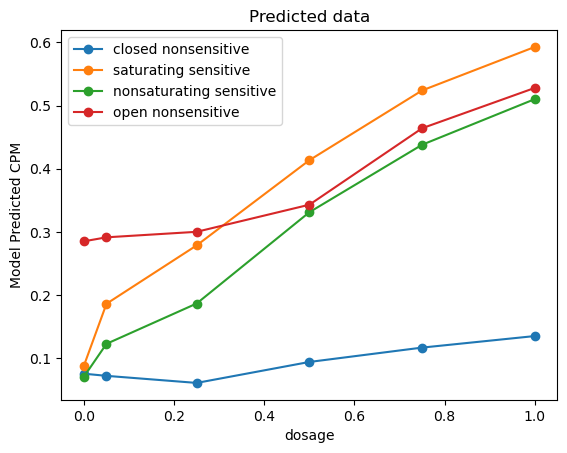

In [15]:
for x in set(obs_peaks_test['group']):
    plt.plot([0, 0.05, 0.25, 0.5, 0.75, 1], (obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group']==x]).mean(0), 'o-', label=x)

plt.title("Predicted data")
plt.ylabel("Model Predicted CPM") 
plt.xlabel("dosage")
plt.legend()

Same as above but with actual data.

In [ ]:
obs_peaks_test_obs_500bp_cpm = []

for j in range(len(SAMPLES)):
    s = SAMPLES[j]
    print(s)
    with pyBigWig.open(glob.glob(f"{models_dir}/{celltype}_*{s}/auxiliary/data_unstranded.bw")[0]) as bw:
        counts = []
        reg = obs_peaks_test.reset_index()
        for i in range(reg.shape[0]):
            start = reg.loc[i, "start"] + reg.loc[i, "summit"] - 500//2
            end = start + 500
            val = np.nansum(bw.values(reg.loc[i, "chr"], start, end))
            counts.append(val)
        obs_peaks_test_obs_500bp_cpm.append(counts/DEPTH_VECTOR[j])

obs_peaks_test_obs_500bp_cpm =  np.array(obs_peaks_test_obs_500bp_cpm).T

GFP_d100
SPI1_d005
SPI1_d025
SPI1_d050
SPI1_d075
SPI1_d100


In [266]:
obs_peaks_test_obs_500bp_cpm

array([[0.02074685, 0.06680824, 0.02714407, 0.02815103, 0.06443937,
        0.01258946],
       [0.01556014, 0.04453883, 0.10857629, 0.40818999, 0.51551495,
        0.6924204 ],
       [0.29564265, 0.54560062, 0.40716111, 0.40818999, 0.43496574,
        0.45322063],
       ...,
       [0.04668042, 0.04453883, 0.08143222, 0.28151034, 0.53162479,
        0.8560834 ],
       [0.08298741, 0.53446591, 0.6243137 , 1.02751274, 1.40155626,
        1.10787264],
       [0.05705384, 0.04453883, 0.21715259, 0.45041654, 0.64439368,
        0.59170471]])

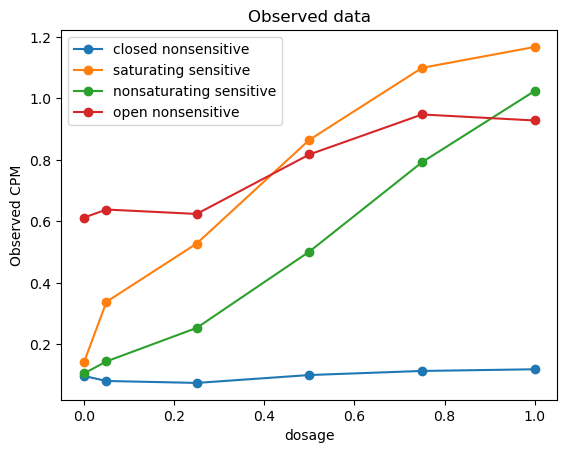

In [17]:
for x in set(obs_peaks_test['group']):
    plt.plot([0, 0.05, 0.25, 0.5, 0.75, 1], (obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group']==x]).mean(0), 'o-', label=x)

plt.title("Observed data")
plt.ylabel("Observed CPM")
plt.xlabel("dosage")
plt.legend()

nonsaturating sensitive


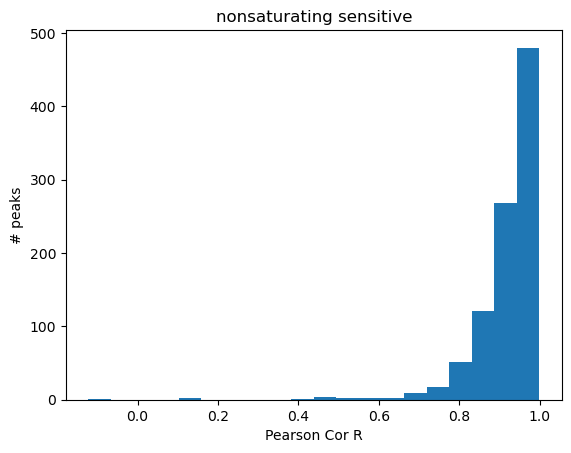

closed nonsensitive


/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


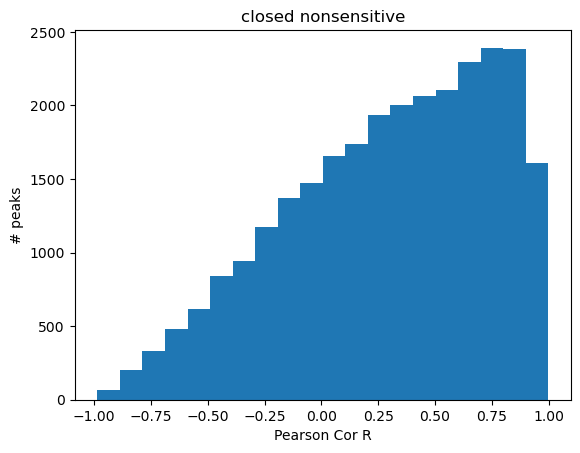

open nonsensitive


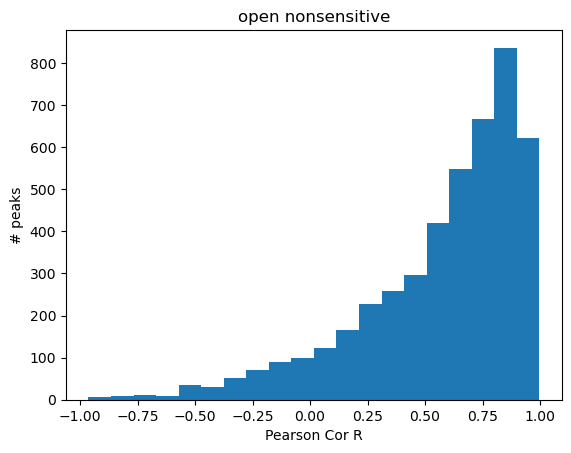

saturating sensitive


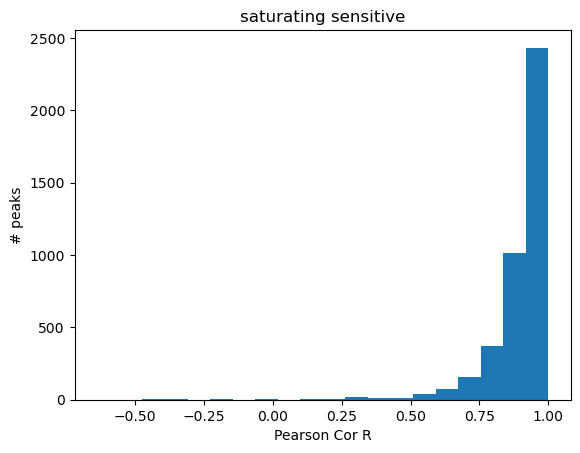

In [ ]:
for x in set(obs_peaks_test['group']):
    print(x)
    corrs = []
    g1 = obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group']==x]
    g2 = obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group']==x]
    for i in range(len(g1)):
        corrs.append(scipy.stats.pearsonr(g1[i], g2[i])[0])
    plt.title(x)
    plt.hist(corrs, bins=20)
    plt.xlabel("Pearson Cor R")
    plt.ylabel("# peaks")
    plt.show()

In [ ]:
allcorrs = pd.DataFrame(columns=["pearson_r", "group"])
for x in set(obs_peaks_test['group']):
    print(x)
    corrs = []
    g1 = obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group']==x]
    g2 = obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group']==x]
    for i in range(len(g1)):
        corrs.append(scipy.stats.pearsonr(g1[i], g2[i])[0])
    allcorrs = pd.concat([allcorrs, pd.DataFrame({"pearson_r": corrs, "group": x})], ignore_index=True)

In [32]:
set(obs_peaks_test['group'])

{'closed nonsensitive',
 'nonsaturating sensitive',
 'open nonsensitive',
 'saturating sensitive'}

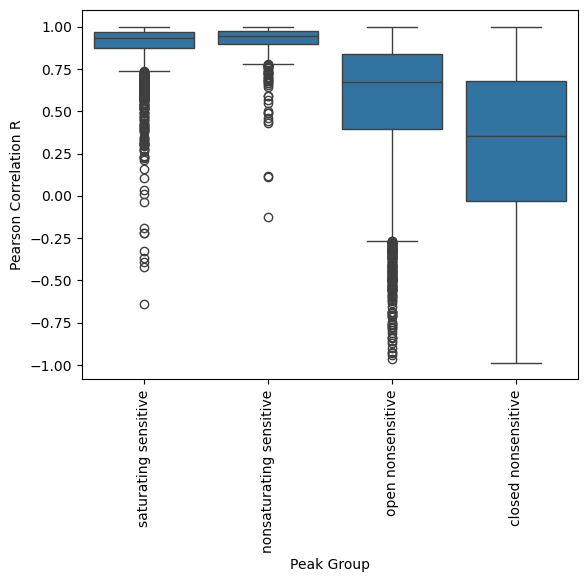

In [34]:
group_levels = ["saturating sensitive", "nonsaturating sensitive", "open nonsensitive", "closed nonsensitive"]
sns.boxplot(data=allcorrs, x="group", y="pearson_r", order=group_levels)
plt.ylabel("Pearson Correlation R")
plt.xlabel("Peak Group")
plt.xticks(rotation=90)
plt.show()

### heatmap of obs and pred, plus ChromHMM annotation

In [ ]:
chromhmm = pd.read_csv(f"{base_dir}/output/02-atac/18/{TF}_chromHMM_annot_1to1_peak2state.csv", sep=",")
chromhmm.index = chromhmm.peakname
print(chromhmm.shape)
chromhmm.head()

(138898, 2)


peakname  \
peakname                                                           
HEK293T_P2E11_TCF3_d005_peak_4    HEK293T_P2E11_TCF3_d005_peak_4   
HEK293T_P3G7_SPI1_d100_peak_15    HEK293T_P3G7_SPI1_d100_peak_15   
HEK293T_P2E8_TCF3_d075_peak_20b  HEK293T_P2E8_TCF3_d075_peak_20b   
HEK293T_P3E2_KLF1_d100_peak_62    HEK293T_P3E2_KLF1_d100_peak_62   
HEK293T_P3G3_KLF1_d075_peak_152  HEK293T_P3G3_KLF1_d075_peak_152   

                                chromhmm_state  
peakname                                        
HEK293T_P2E11_TCF3_d005_peak_4        48_EnhA7  
HEK293T_P3G7_SPI1_d100_peak_15         15_HET8  
HEK293T_P2E8_TCF3_d075_peak_20b      91_PromF1  
HEK293T_P3E2_KLF1_d100_peak_62     89_BivProm3  
HEK293T_P3G3_KLF1_d075_peak_152       81_TxEx2

In [268]:
obs_peaks_test = pd.merge(obs_peaks_test, chromhmm, left_index=True, right_index=True, how="left")
obs_peaks_test.chromhmm_state[np.where((obs_peaks_test.chromhmm_state).isnull())[0]] = "none"
obs_peaks_test.head()

/tmp/ipykernel_248364/2962820406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_peaks_test.chromhmm_state[np.where((obs_peaks_test.chromhmm_state).isnull())[0]] = "none"


sensitive saturating  EC50   h   state  \
HEK293T_P2E11_TCF3_d005_peak_4         No        NaN   NaN NaN  closed   
HEK293T_P3G7_SPI1_d100_peak_15         No        NaN   NaN NaN  closed   
HEK293T_P2E8_TCF3_d075_peak_20b        No        NaN   NaN NaN    open   
HEK293T_P3E2_KLF1_d100_peak_62         No        NaN   NaN NaN  closed   
HEK293T_P3G3_KLF1_d075_peak_152        No        NaN   NaN NaN  closed   

                                               group   chr   start     end  \
HEK293T_P2E11_TCF3_d005_peak_4   closed nonsensitive  chr1  838242  838744   
HEK293T_P3G7_SPI1_d100_peak_15   closed nonsensitive  chr1  888092  888594   
HEK293T_P2E8_TCF3_d075_peak_20b    open nonsensitive  chr1  906537  907039   
HEK293T_P3E2_KLF1_d100_peak_62   closed nonsensitive  chr1  907978  908480   
HEK293T_P3G3_KLF1_d075_peak_152  closed nonsensitive  chr1  951879  952381   

                                                            name        x1 x2  \
HEK293T_P2E11_TCF3_d005_peak_4    HEK293T_P2E11_TCF3_d005_peak_4  16.70038  .   
HEK293T_P3G7_SPI1_d100_peak_15    HEK293T_P3G7_SPI1_d100_peak_15   9.45842  .   
HEK293T_P2E8_TCF3_d075_peak_20b  HEK293T_P2E8_TCF3_d075_peak_20b  55.09123  .   
HEK293T_P3E2_KLF1_d100_peak_62    HEK293T_P3E2_KLF1_d100_peak_62   6.53894  .   
HEK293T_P3G3_KLF1_d075_peak_152  HEK293T_P3G3_KLF1_d075_peak_152   4.86230  .   

                                 summit                         peakname  \
HEK293T_P2E11_TCF3_d005_peak_4      251   HEK293T_P2E11_TCF3_d005_peak_4   
HEK293T_P3G7_SPI1_d100_peak_15      251   HEK293T_P3G7_SPI1_d100_peak_15   
HEK293T_P2E8_TCF3_d075_peak_20b     251  HEK293T_P2E8_TCF3_d075_peak_20b   
HEK293T_P3E2_KLF1_d100_peak_62      251   HEK293T_P3E2_KLF1_d100_peak_62   
HEK293T_P3G3_KLF1_d075_peak_152     251  HEK293T_P3G3_KLF1_d075_peak_152   

                                chromhmm_state  
HEK293T_P2E11_TCF3_d005_peak_4        48_EnhA7  
HEK293T_P3G7_SPI1_d100_peak_15         15_HET8  
HEK293T_P2E8_TCF3_d075_peak_20b      91_PromF1  
HEK293T_P3E2_KLF1_d100_peak_62     89_BivProm3  
HEK293T_P3G3_KLF1_d075_peak_152       81_TxEx2

In [270]:
obs_peaks_test["chromhmm_state_id"] = obs_peaks_test.chromhmm_state.str.split("_").str[0]
obs_peaks_test.chromhmm_state_id[obs_peaks_test.chromhmm_state_id=="none"] = "-1"
obs_peaks_test["chromhmm_state_broad"] = obs_peaks_test.chromhmm_state.str.replace(r'[0-9\W_]+', '', regex=True)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(obs_peaks_test.chromhmm_state_broad)
obs_peaks_test['chromhmm_state_id_broad'] = numeric_labels
obs_peaks_test.head()

/tmp/ipykernel_248364/2731774927.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_peaks_test.chromhmm_state_id[obs_peaks_test.chromhmm_state_id=="none"] = "-1"


sensitive saturating  EC50   h   state  \
HEK293T_P2E11_TCF3_d005_peak_4         No        NaN   NaN NaN  closed   
HEK293T_P3G7_SPI1_d100_peak_15         No        NaN   NaN NaN  closed   
HEK293T_P2E8_TCF3_d075_peak_20b        No        NaN   NaN NaN    open   
HEK293T_P3E2_KLF1_d100_peak_62         No        NaN   NaN NaN  closed   
HEK293T_P3G3_KLF1_d075_peak_152        No        NaN   NaN NaN  closed   

                                               group   chr   start     end  \
HEK293T_P2E11_TCF3_d005_peak_4   closed nonsensitive  chr1  838242  838744   
HEK293T_P3G7_SPI1_d100_peak_15   closed nonsensitive  chr1  888092  888594   
HEK293T_P2E8_TCF3_d075_peak_20b    open nonsensitive  chr1  906537  907039   
HEK293T_P3E2_KLF1_d100_peak_62   closed nonsensitive  chr1  907978  908480   
HEK293T_P3G3_KLF1_d075_peak_152  closed nonsensitive  chr1  951879  952381   

                                                            name        x1 x2  \
HEK293T_P2E11_TCF3_d005_peak_4    HEK293T_P2E11_TCF3_d005_peak_4  16.70038  .   
HEK293T_P3G7_SPI1_d100_peak_15    HEK293T_P3G7_SPI1_d100_peak_15   9.45842  .   
HEK293T_P2E8_TCF3_d075_peak_20b  HEK293T_P2E8_TCF3_d075_peak_20b  55.09123  .   
HEK293T_P3E2_KLF1_d100_peak_62    HEK293T_P3E2_KLF1_d100_peak_62   6.53894  .   
HEK293T_P3G3_KLF1_d075_peak_152  HEK293T_P3G3_KLF1_d075_peak_152   4.86230  .   

                                 summit                         peakname  \
HEK293T_P2E11_TCF3_d005_peak_4      251   HEK293T_P2E11_TCF3_d005_peak_4   
HEK293T_P3G7_SPI1_d100_peak_15      251   HEK293T_P3G7_SPI1_d100_peak_15   
HEK293T_P2E8_TCF3_d075_peak_20b     251  HEK293T_P2E8_TCF3_d075_peak_20b   
HEK293T_P3E2_KLF1_d100_peak_62      251   HEK293T_P3E2_KLF1_d100_peak_62   
HEK293T_P3G3_KLF1_d075_peak_152     251  HEK293T_P3G3_KLF1_d075_peak_152   

                                chromhmm_state chromhmm_state_id  \
HEK293T_P2E11_TCF3_d005_peak_4        48_EnhA7                48   
HEK293T_P3G7_SPI1_d100_peak_15         15_HET8                15   
HEK293T_P2E8_TCF3_d075_peak_20b      91_PromF1                91   
HEK293T_P3E2_KLF1_d100_peak_62     89_BivProm3                89   
HEK293T_P3G3_KLF1_d075_peak_152       81_TxEx2                81   

                                 chromhmm_state_id_broad chromhmm_state_broad  
HEK293T_P2E11_TCF3_d005_peak_4                         3                 EnhA  
HEK293T_P3G7_SPI1_d100_peak_15                         6                  HET  
HEK293T_P2E8_TCF3_d075_peak_20b                        7                PromF  
HEK293T_P3E2_KLF1_d100_peak_62                         1              BivProm  
HEK293T_P3G3_KLF1_d075_peak_152                       13                 TxEx

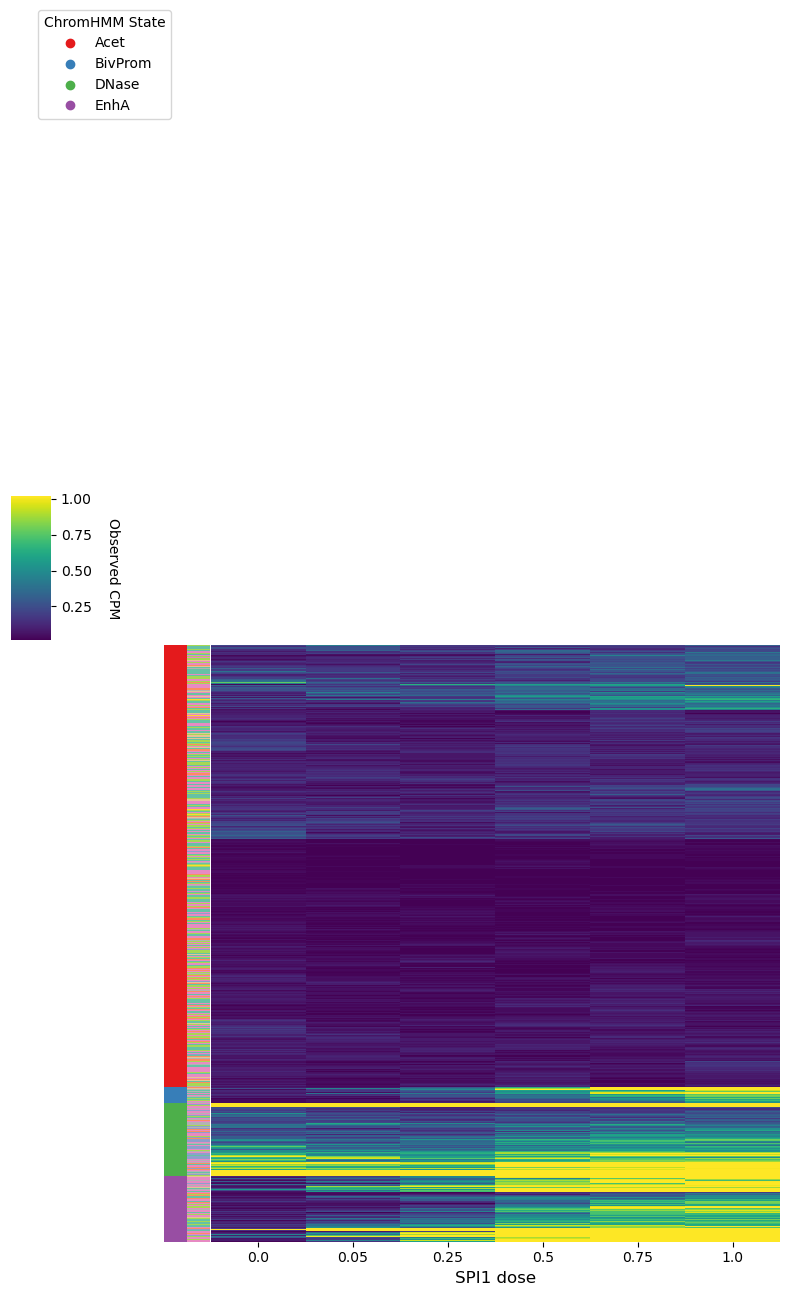

In [322]:
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import linkage, dendrogram

idx = np.argsort(obs_peaks_test['group']).values
## save ordered peaks
# obs_peaks_test.iloc[idx].to_csv(f"{outdir}/{TF}_obs_peaks_test_sorted.csv")

toplot = obs_peaks_test_obs_500bp_cpm[idx]
# Map groups to colors
sorted_groups = obs_peaks_test['group'][idx]
unique_groups = np.unique(sorted_groups)

sorted_groups2 = obs_peaks_test['chromhmm_state_broad'][idx]
unique_groups2 = np.unique(list(sorted_groups2))

# Perform hierarchical clustering on the subset of rows for the specific group
out = []
og_idx = []
for gr in unique_groups:
    group_data = toplot[sorted_groups == gr]
    linkage_matrix = linkage(group_data, method='ward')
    dendro = dendrogram(linkage_matrix, no_plot=True)
    row_order = dendro['leaves']
    og_idx.extend(idx[sorted_groups == gr][row_order])
    out.extend(group_data[row_order])

cmap = ListedColormap(sns.color_palette("Set1", n_colors=len(unique_groups)).as_hex())
group_colors = pd.Series(sorted_groups).map(dict(zip(unique_groups, cmap.colors)))
cmap2 = ListedColormap(sns.color_palette("Set2", n_colors=len(unique_groups2)).as_hex())
group_colors2 = pd.Series(sorted_groups2).map(dict(zip(unique_groups2, cmap2.colors)))

row_colors = pd.DataFrame({
    "sensitivity_group": group_colors,
    "chromhmm_state": group_colors2
})
np.random.seed(16)
g = sns.clustermap(out, row_cluster=False, col_cluster=False, 
                row_colors=[group_colors, group_colors2], cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(out, 5),
                vmax = np.percentile(out, 95),
                )
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
plt.legend(legend_labels, unique_groups, title="Sensitivity Group", loc="center left", bbox_to_anchor=(4, 0.5))
legend_labels2 = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap2.colors]
plt.legend(legend_labels, unique_groups2, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.5, 4))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Observed CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

plt.show()

g.savefig(f"{plotdir}/{TF}_obs_cpm_heatmap.pdf")

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

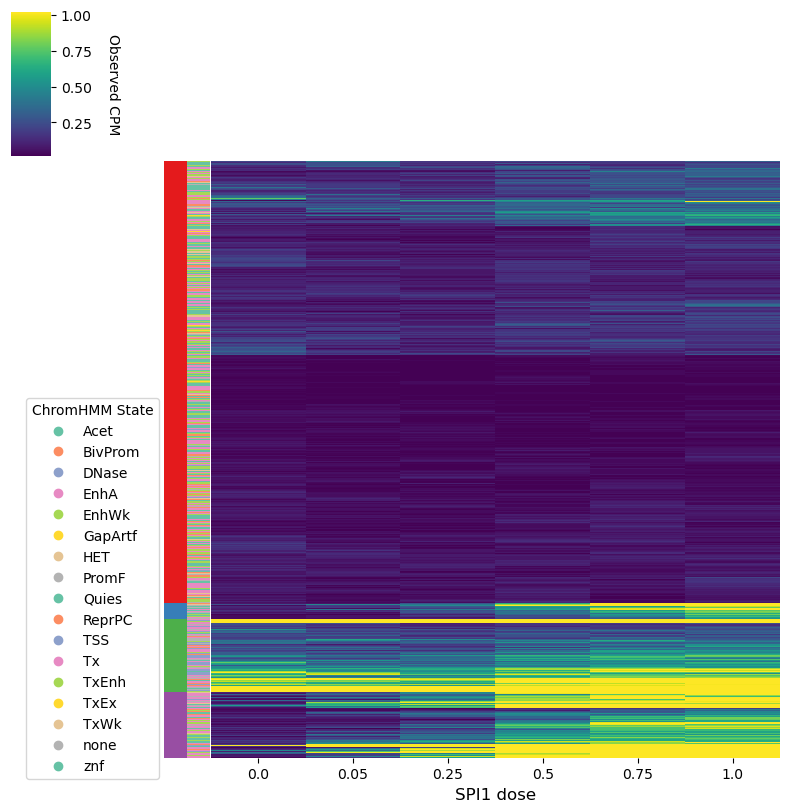

In [129]:
np.random.seed(16)
g = sns.clustermap(out, row_cluster=False, col_cluster=False, 
                row_colors=[group_colors, group_colors2], cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(out, 5),
                vmax = np.percentile(out, 95),
                )
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
l1 = plt.legend(legend_labels, unique_groups, title="Sensitivity Group", loc="center left", bbox_to_anchor=(4, 0.5))
legend_labels2 = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap2.colors]
l2 = plt.legend(legend_labels2, unique_groups2, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.2, -3))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Observed CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)
g.ax_heatmap.add_artist(l1)
g.ax_heatmap.add_artist(l2)
plt.show()

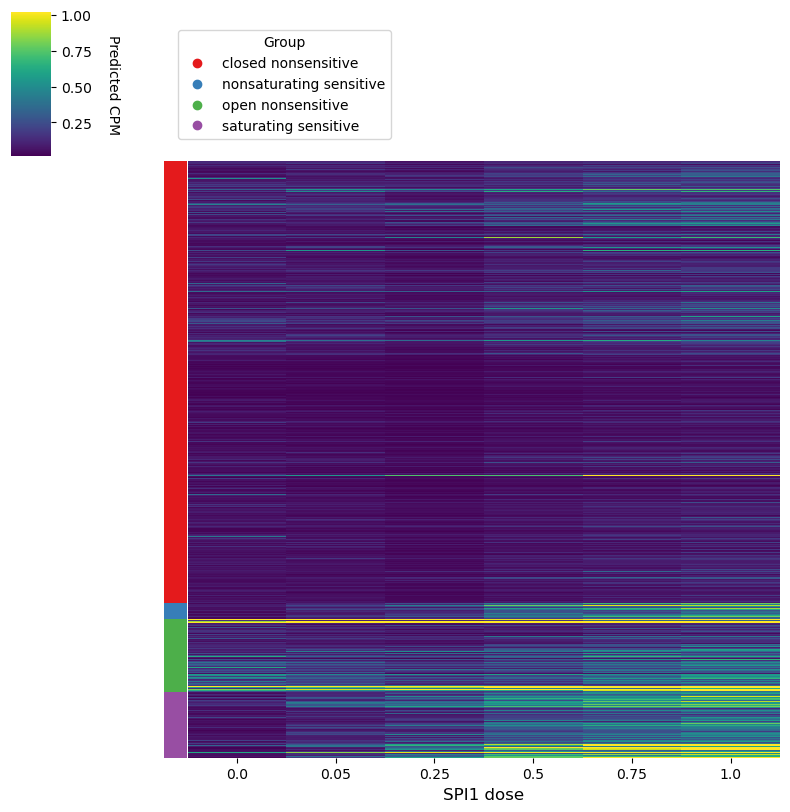

In [130]:
toplot = obs_peaks_test_preds_500bp_cpm[og_idx]

# using the same color scale as obs
g = sns.clustermap(toplot, row_cluster=False, col_cluster=False, 
                row_colors=list(group_colors), cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(out, 5), # keep the same vmin vmax as the preds color scale
                vmax = np.percentile(out, 95),
                )
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
plt.legend(legend_labels, unique_groups, title="Group", loc="center left", bbox_to_anchor=(4, 0.5))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Predicted CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

plt.show()


g.savefig(f"{plotdir}/{TF}_preds_cpm_heatmap.pdf")

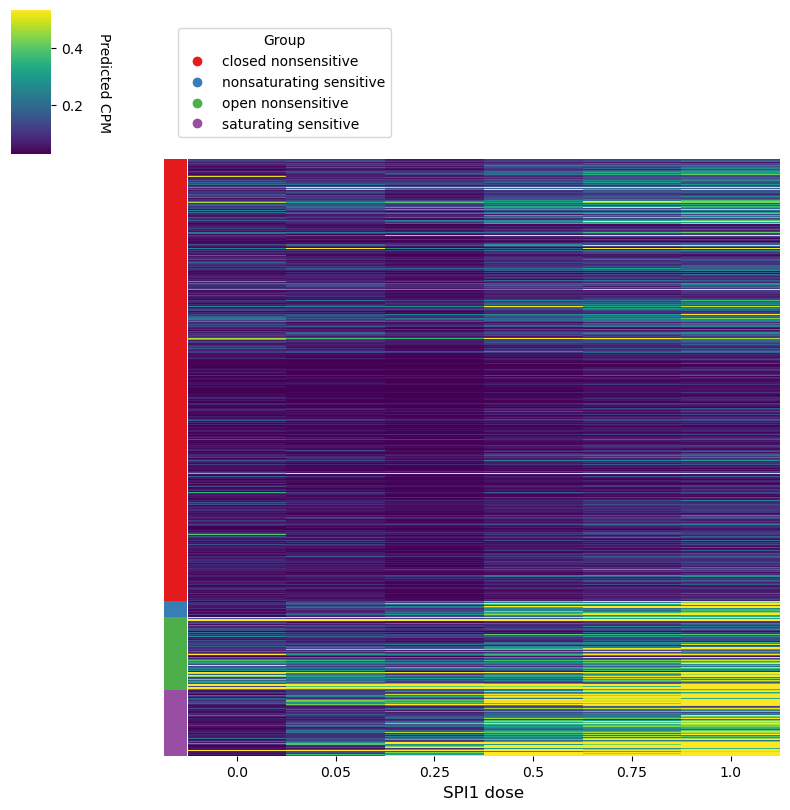

In [131]:
# or using a diff color scale than obs
g = sns.clustermap(toplot, row_cluster=False, col_cluster=False, 
                row_colors=list(group_colors), cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(toplot, 5),
                vmax = np.percentile(toplot, 95),
                )
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
plt.legend(legend_labels, unique_groups, title="Group", loc="center left", bbox_to_anchor=(4, 0.5))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Predicted CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

plt.show()


g.savefig(f"{plotdir}/{TF}_preds_cpm_heatmap_diffscale.pdf")

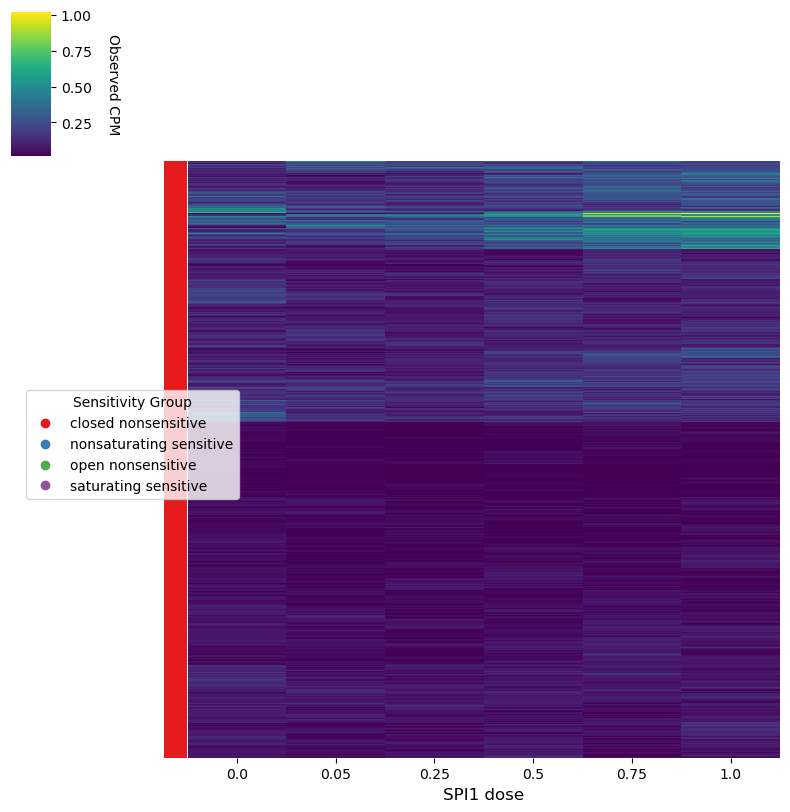

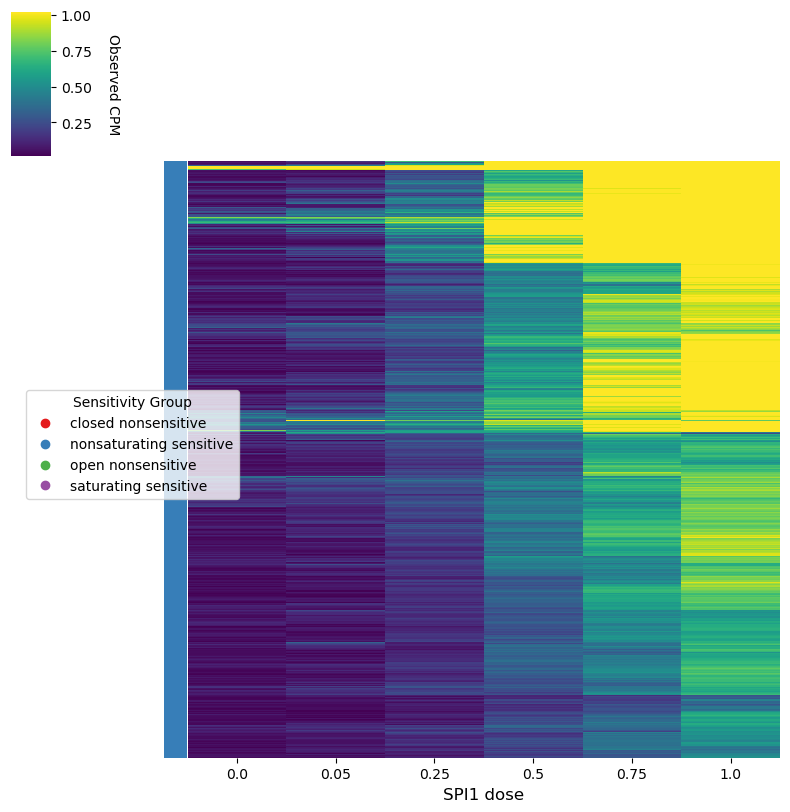

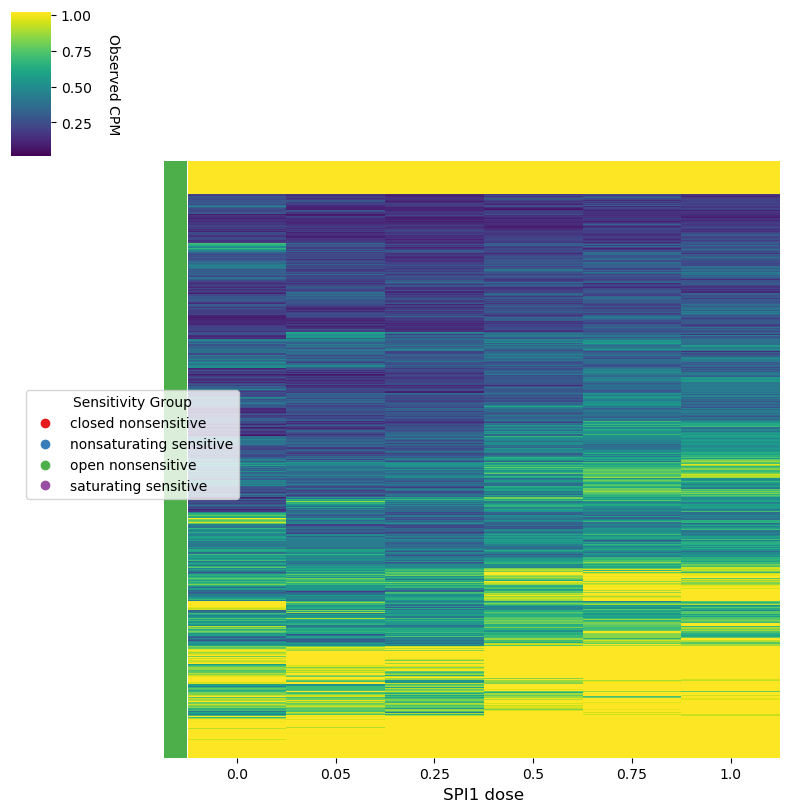

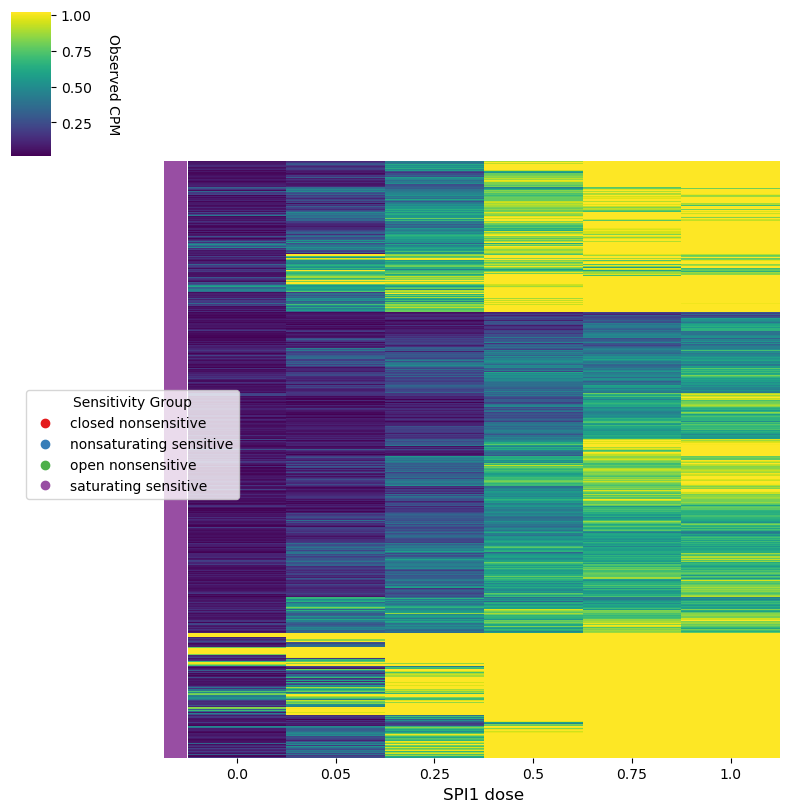

In [323]:
# generate one heatmap per sensitivity group
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Create a PDF file to save the plots
with PdfPages(f'{plotdir}/{TF}_obs_cpm_heatmap_pergroup.pdf') as pdf:        
    for gr in unique_groups:
        mask = (sorted_groups == gr)
        subout = np.array(out)[mask]
        np.random.seed(16)
        g = sns.clustermap(subout, row_cluster=False, col_cluster=False, 
                        row_colors=[group_colors[mask]], 
                        cmap="viridis", figsize=(8, 8), 
                        xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                        vmin = np.percentile(out, 5),
                        vmax = np.percentile(out, 95),
                        )
        legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
        plt.legend(legend_labels, unique_groups, title="Sensitivity Group", loc="center left", bbox_to_anchor=(0.2, -2))
        # Add a label to the color bar
        colorbar = g.ax_heatmap.collections[0].colorbar
        colorbar.set_label("Observed CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
        g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

        pdf.savefig()
        plt.show()
        plt.close()


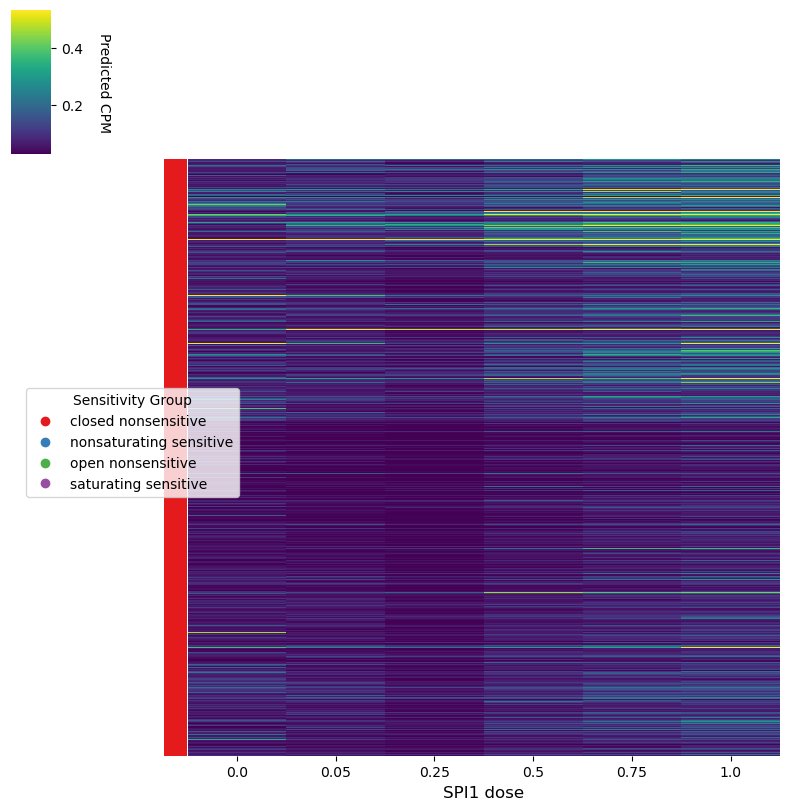

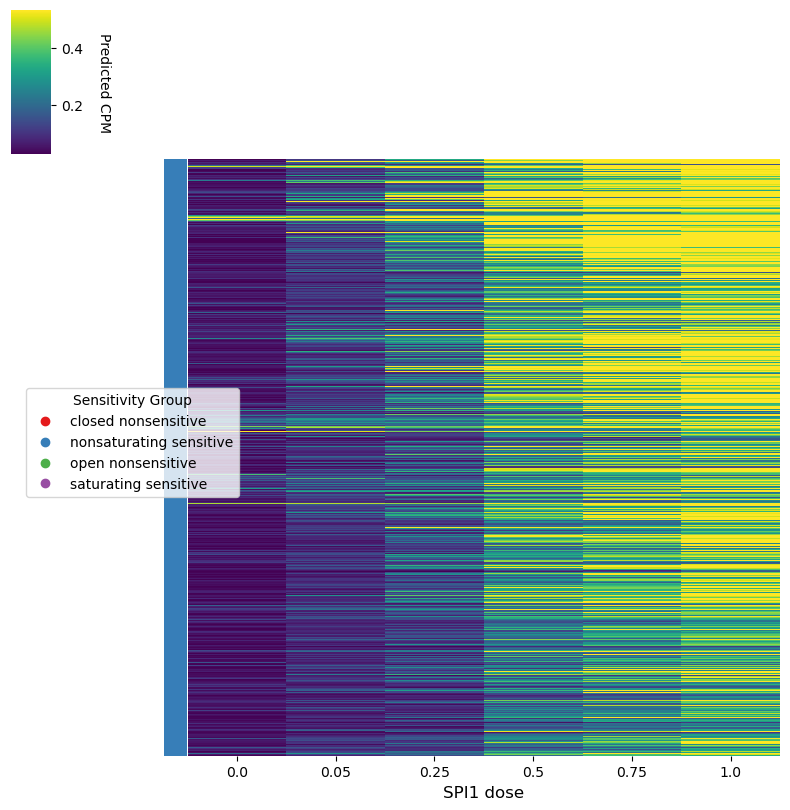

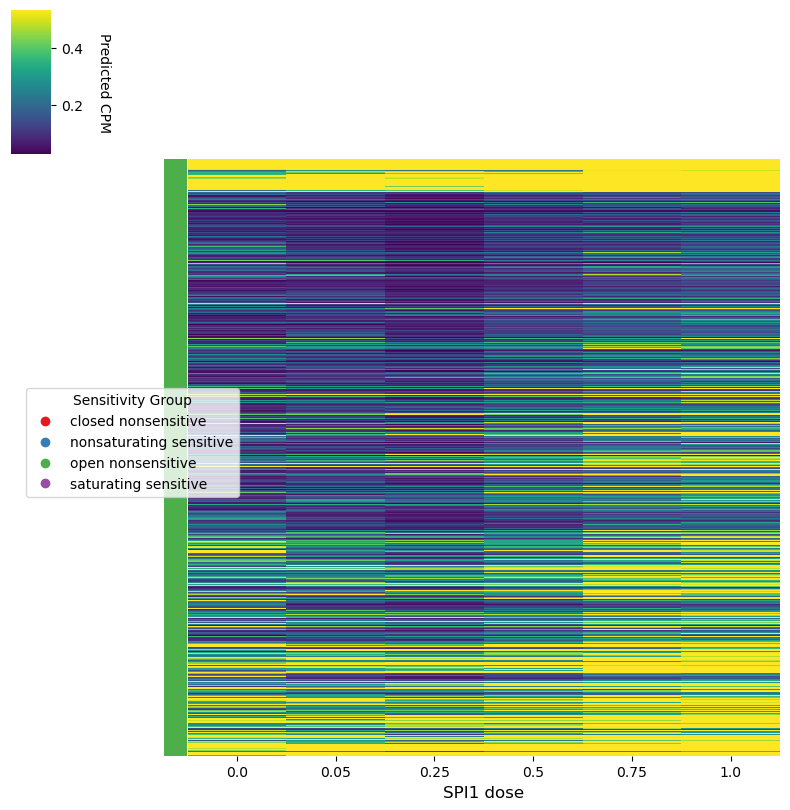

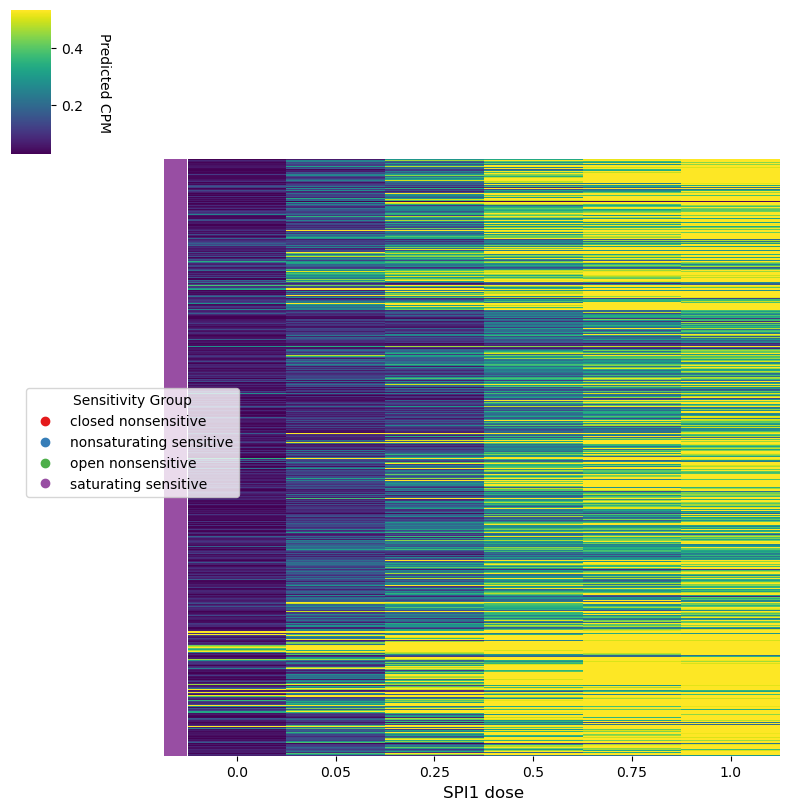

In [324]:
# pred 
# Create a PDF file to save the plots
toplot = obs_peaks_test_preds_500bp_cpm[og_idx]

with PdfPages(f'{plotdir}/{TF}_preds_cpm_heatmap_pergroup.pdf') as pdf:        
    for gr in unique_groups:
        mask = (sorted_groups == gr)
        subout = np.array(toplot)[mask]
        np.random.seed(16)
        g = sns.clustermap(subout, row_cluster=False, col_cluster=False, 
                        row_colors=[group_colors[mask]], 
                        cmap="viridis", figsize=(8, 8), 
                        xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                        vmin = np.percentile(toplot, 5),
                        vmax = np.percentile(toplot, 95),
                        )
        legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
        plt.legend(legend_labels, unique_groups, title="Sensitivity Group", loc="center left", bbox_to_anchor=(0.2, -2))
        # Add a label to the color bar
        colorbar = g.ax_heatmap.collections[0].colorbar
        colorbar.set_label("Predicted CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
        g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

        pdf.savefig()
        plt.show()
        plt.close()


### same heatmap but sorted by chromhmm

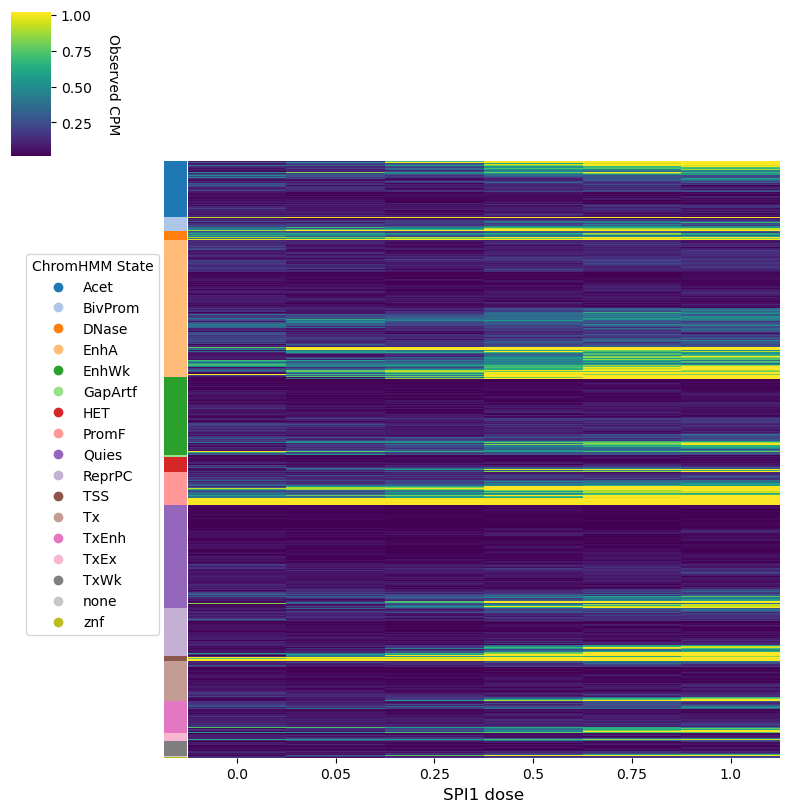

<Figure size 640x480 with 0 Axes>

In [298]:
from matplotlib.colors import ListedColormap
from scipy.cluster.hierarchy import linkage, dendrogram

idx = np.argsort(obs_peaks_test['chromhmm_state_broad']).values
## save ordered peaks
# obs_peaks_test.iloc[idx].to_csv(f"{outdir}/{TF}_obs_peaks_test_sorted.csv")

toplot = obs_peaks_test_obs_500bp_cpm[idx]

# Map groups to colors
# sorted_groups2 = obs_peaks_test['group'][idx]
# unique_groups2 = np.unique(sorted_groups2)

sorted_groups = obs_peaks_test['chromhmm_state_broad'][idx]
unique_groups = np.unique(list(sorted_groups))

# Perform hierarchical clustering on the subset of rows for the specific group
out = []
og_idx = []
for gr in unique_groups:
    group_data = toplot[sorted_groups == gr]
    linkage_matrix = linkage(group_data, method='ward')
    dendro = dendrogram(linkage_matrix, no_plot=True)
    row_order = dendro['leaves']
    og_idx.extend(idx[sorted_groups == gr][row_order])
    out.extend(group_data[row_order])

cmap = ListedColormap(sns.color_palette("tab20", n_colors=len(unique_groups)).as_hex())
group_colors = pd.Series(sorted_groups).map(dict(zip(unique_groups, cmap.colors)))
# cmap2 = ListedColormap(sns.color_palette(sns.color_palette(), n_colors=len(unique_groups2)).as_hex())
# group_colors2 = pd.Series(sorted_groups2).map(dict(zip(unique_groups2, cmap2.colors)))

np.random.seed(16)
g = sns.clustermap(out, row_cluster=False, col_cluster=False, 
                #row_colors=[group_colors, group_colors2], 
                row_colors=[group_colors], 
                cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(out, 5),
                vmax = np.percentile(out, 95),
                )
# legend_labels2 = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap2.colors]
# plt.legend(legend_labels2, unique_groups2, title="Sensitivity Group", loc="center left", bbox_to_anchor=(4, 0.5))
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
plt.legend(legend_labels, unique_groups, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.2, -2))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Observed CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

plt.show()
plt.tight_layout()

g.savefig(f"{plotdir}/{TF}_obs_cpm_heatmap_sortbychromhmm.pdf")

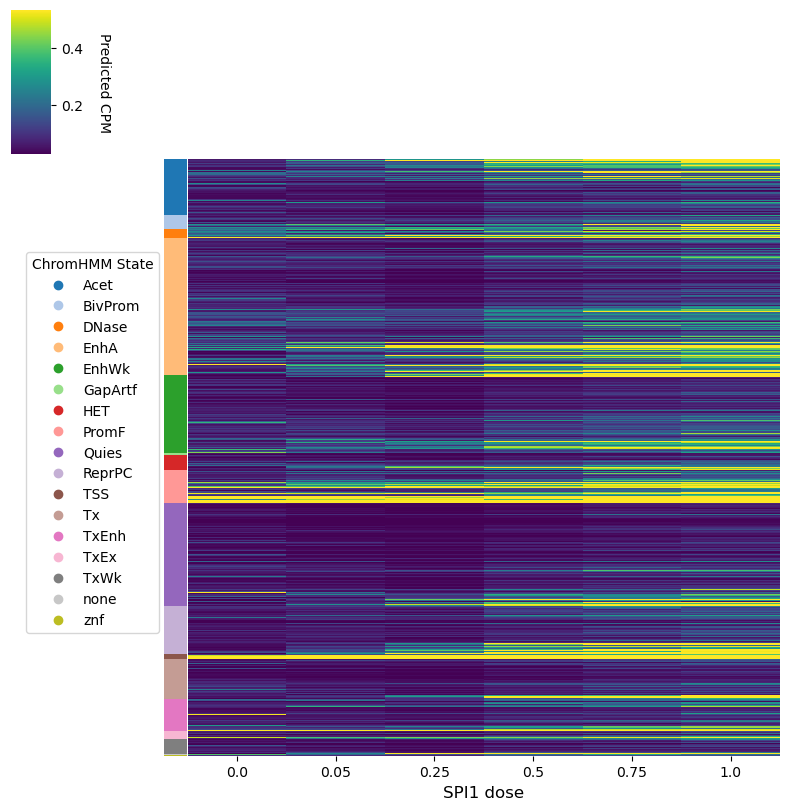

In [299]:
toplot = obs_peaks_test_preds_500bp_cpm[og_idx]

# using a diff color scale than obs
g = sns.clustermap(toplot, row_cluster=False, col_cluster=False, 
                row_colors=list(group_colors), cmap="viridis", figsize=(8, 8), 
                xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                vmin = np.percentile(toplot, 5),
                vmax = np.percentile(toplot, 95),
                )
legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
plt.legend(legend_labels, unique_groups, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.2, -2))
# Add a label to the color bar
colorbar = g.ax_heatmap.collections[0].colorbar
colorbar.set_label("Predicted CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

plt.show()


g.savefig(f"{plotdir}/{TF}_preds_cpm_heatmap_sortbychromhmm_diffscale.pdf")

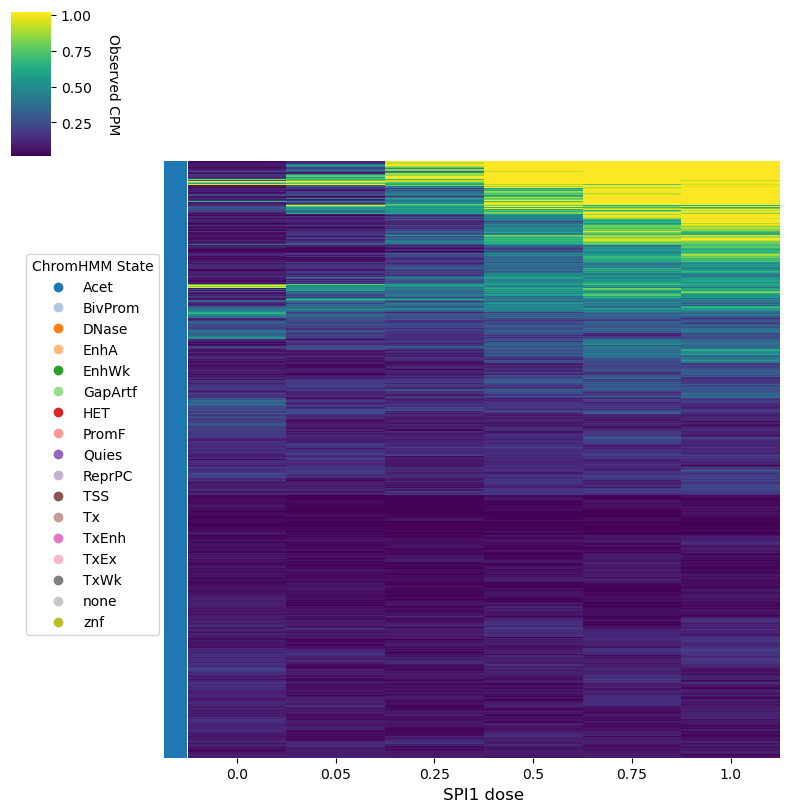

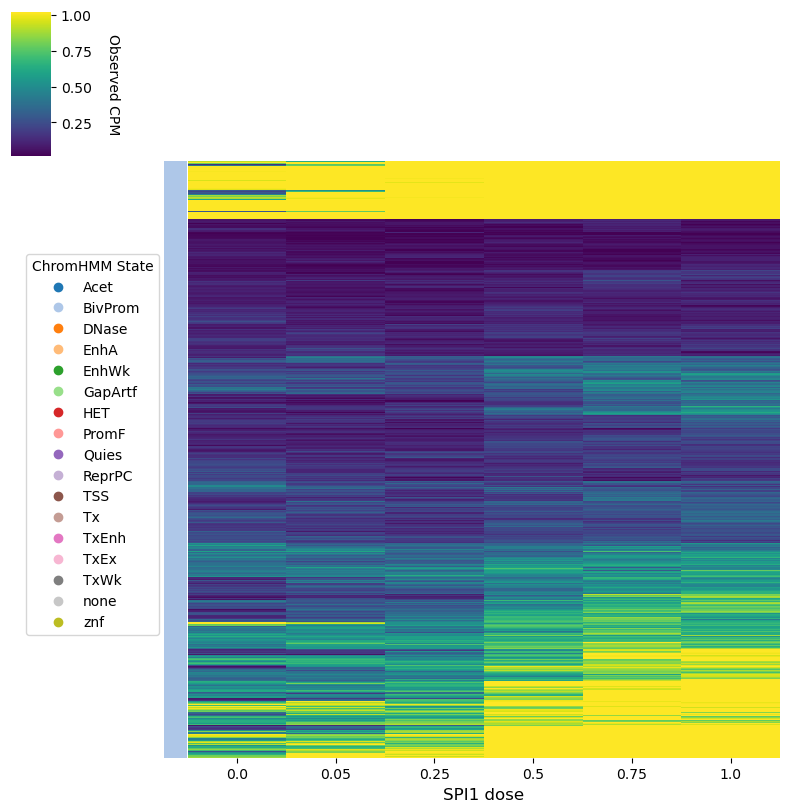

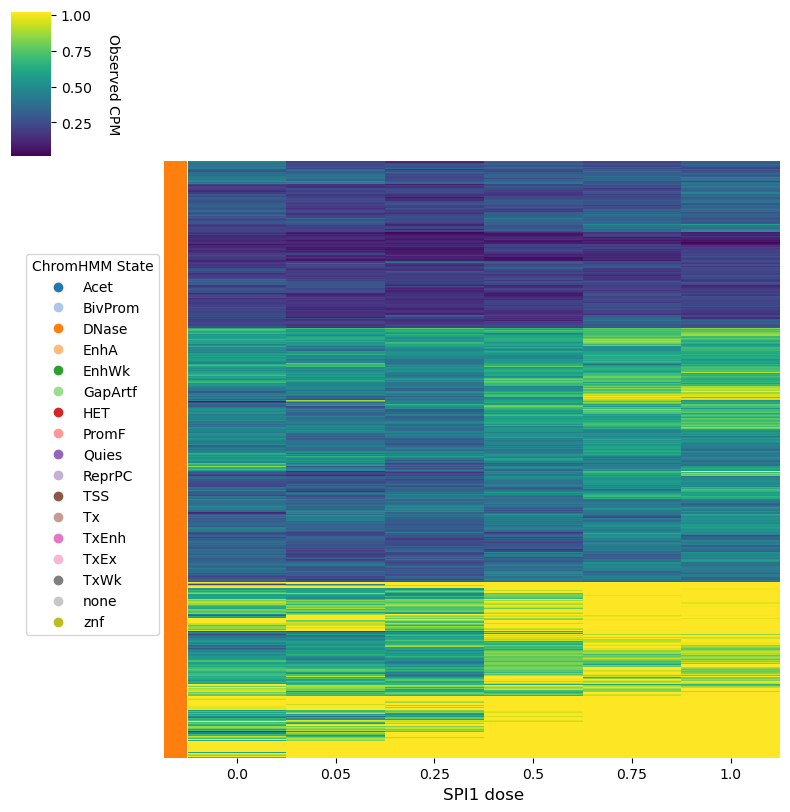

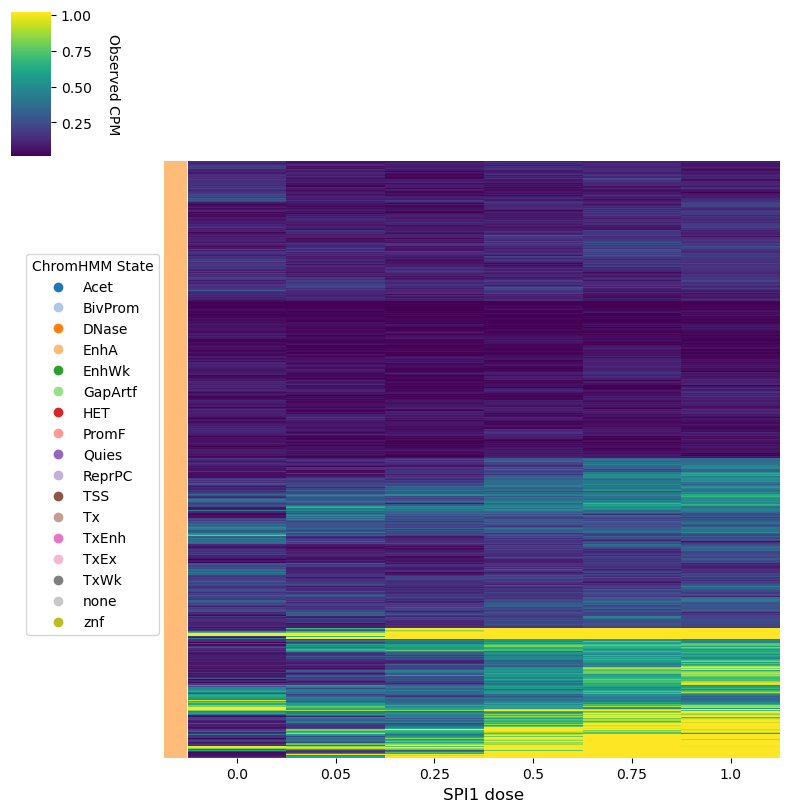

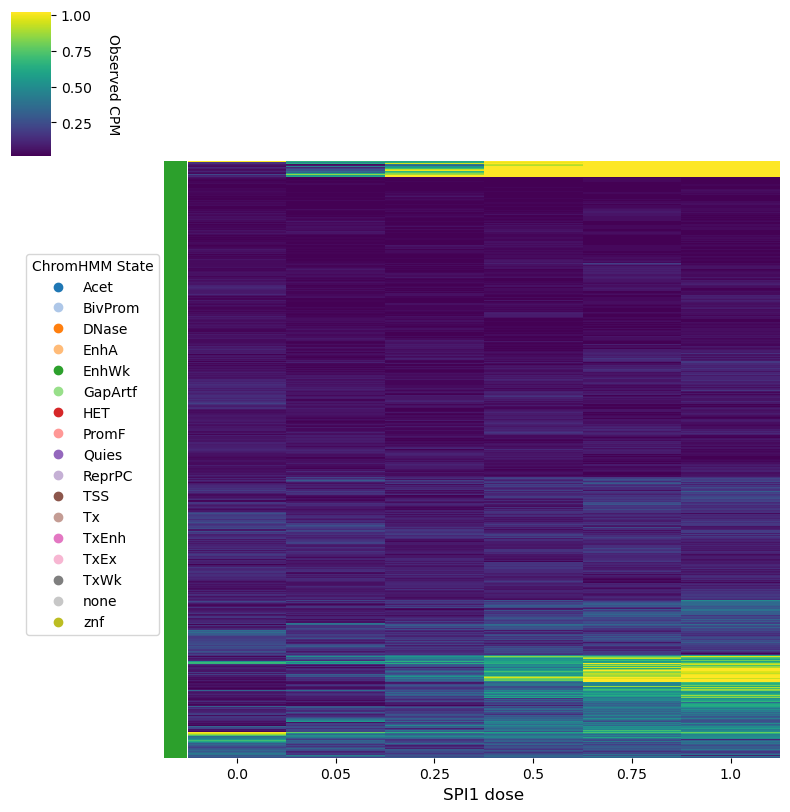

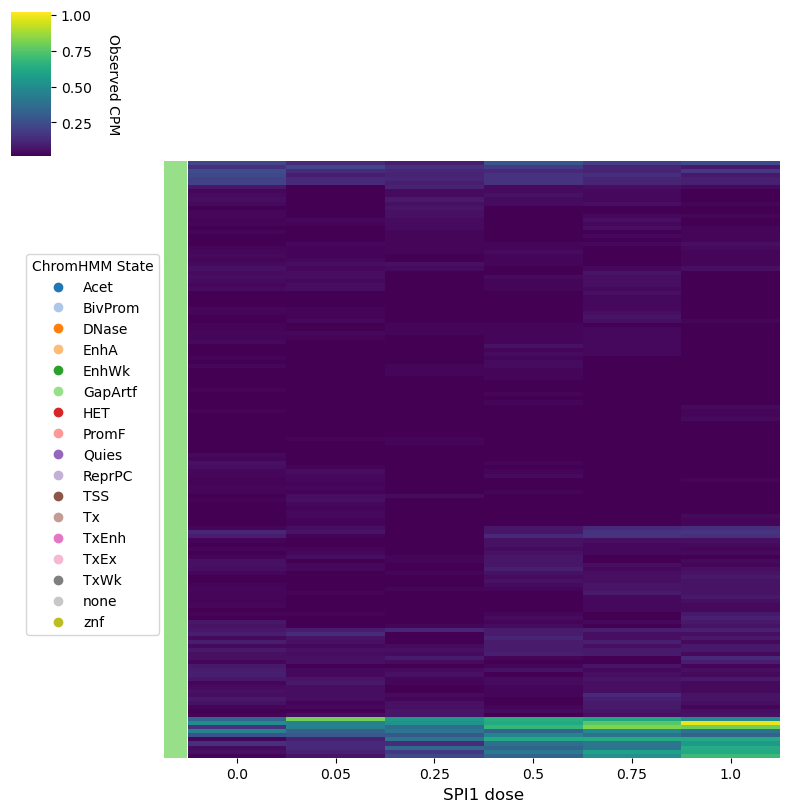

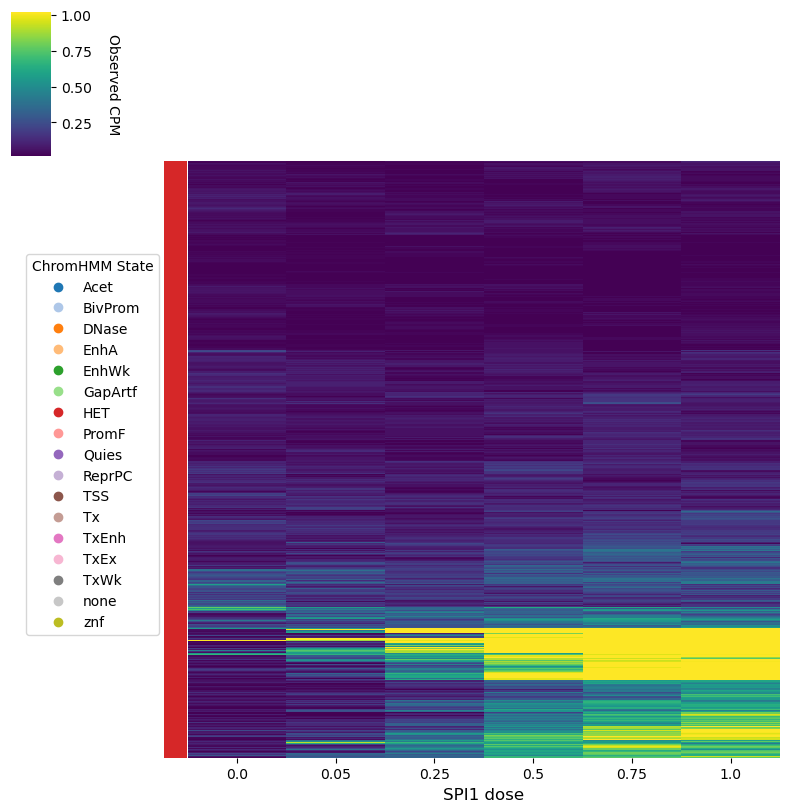

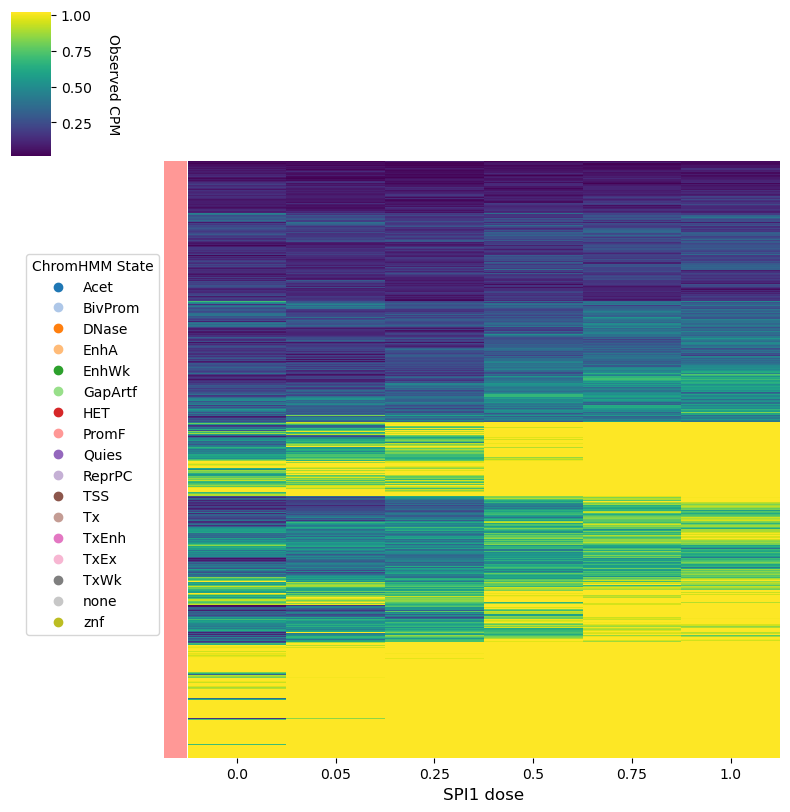

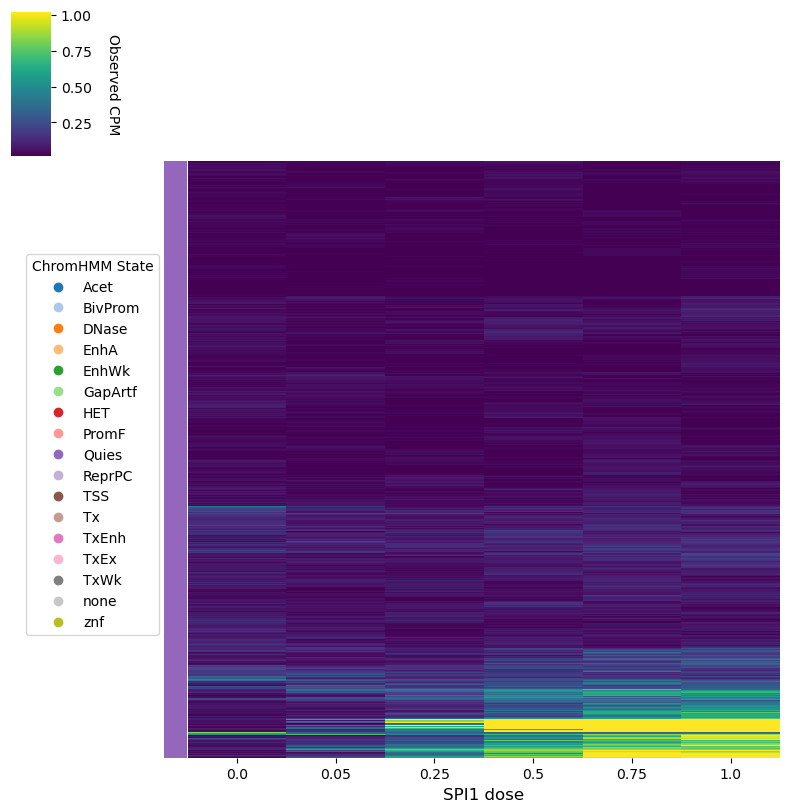

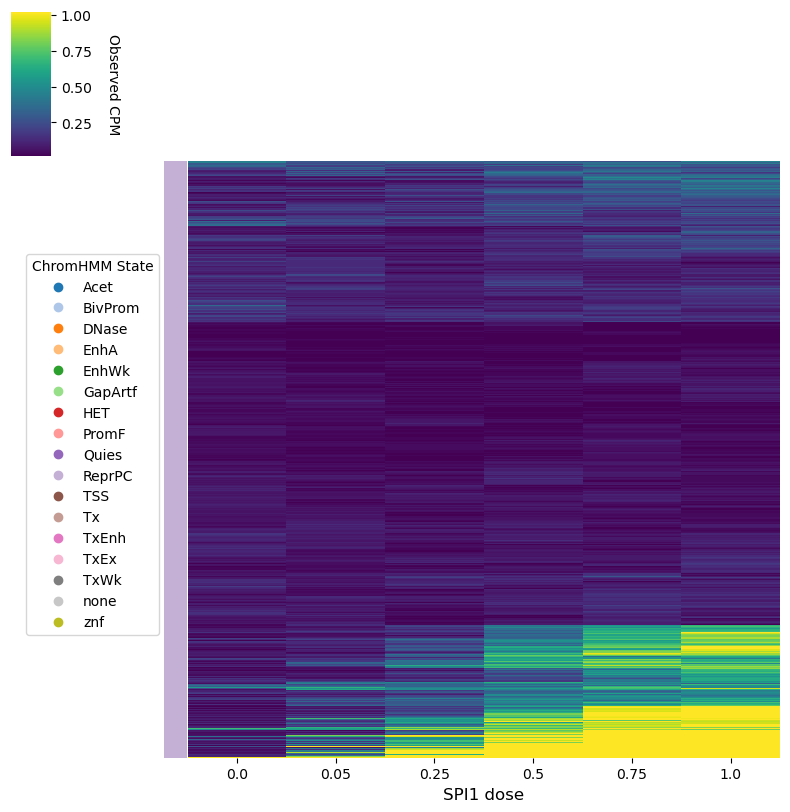

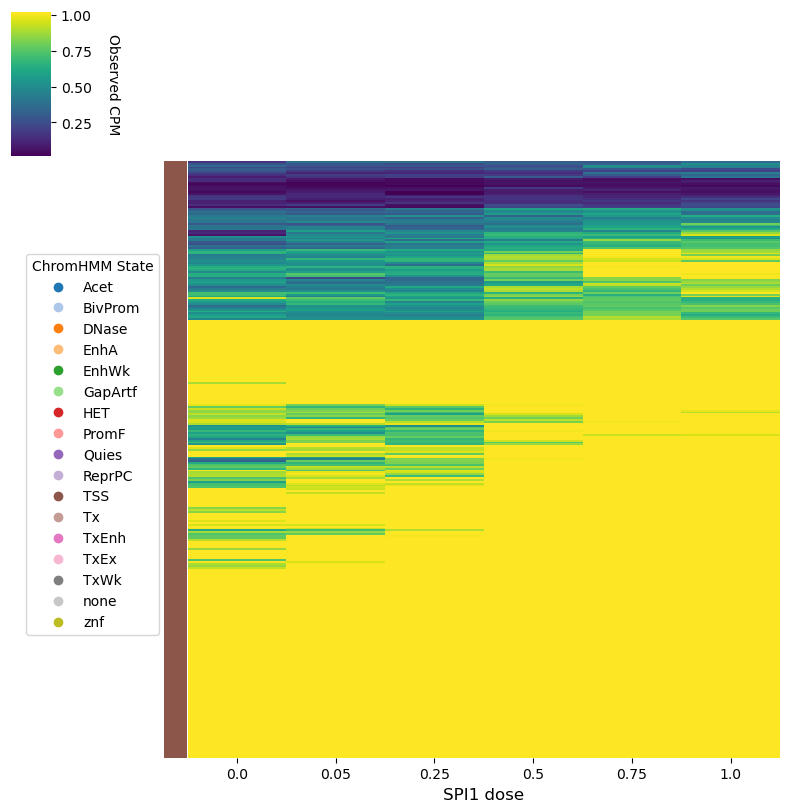

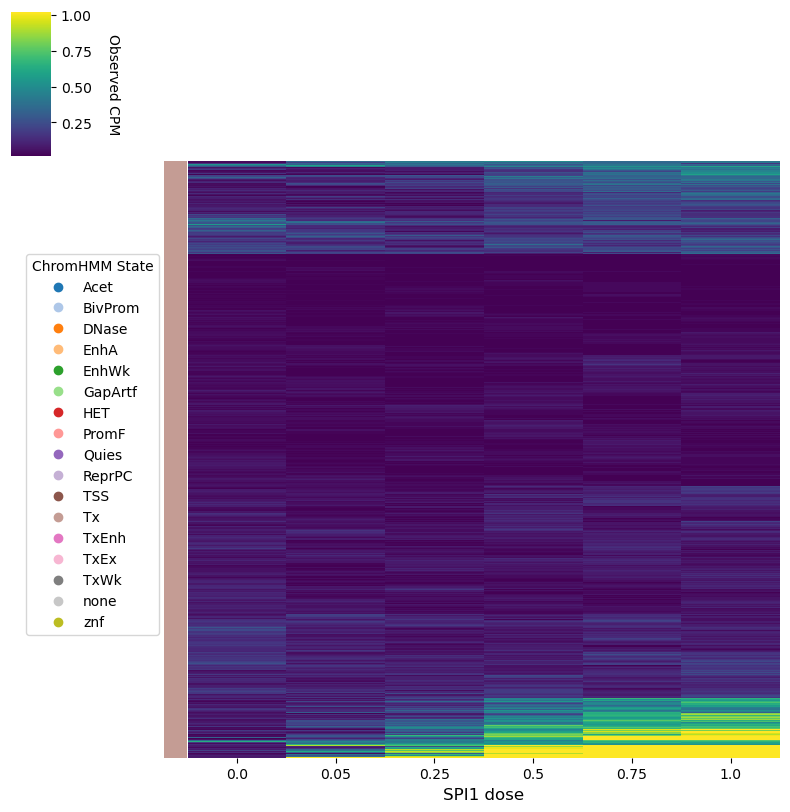

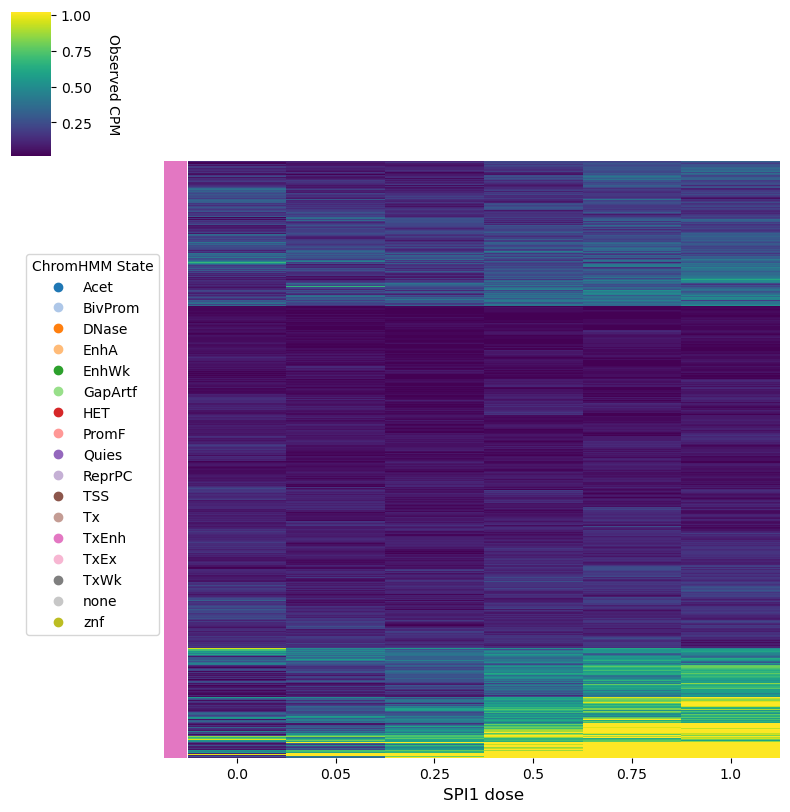

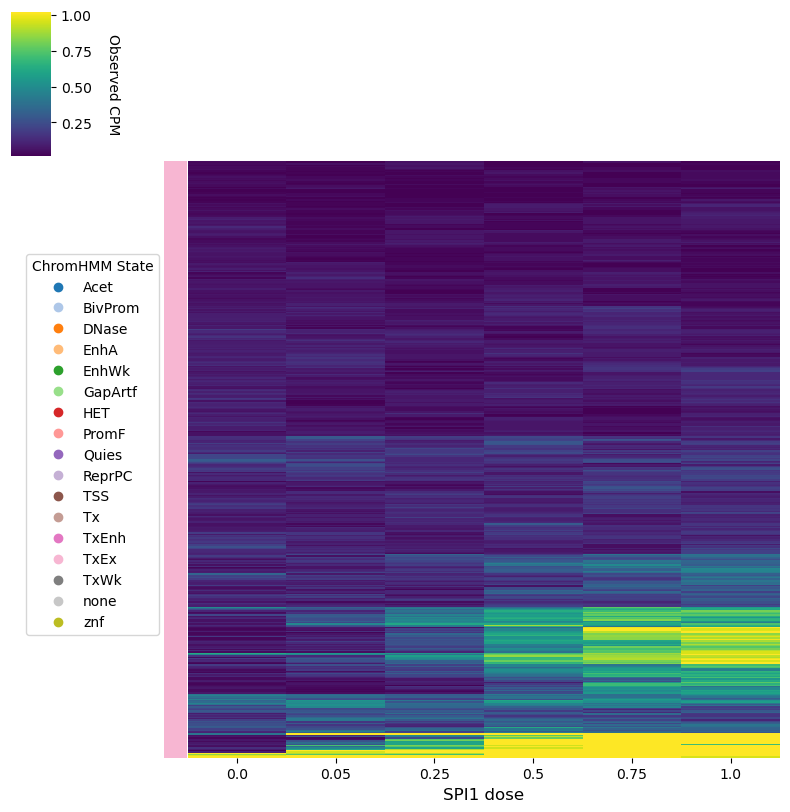

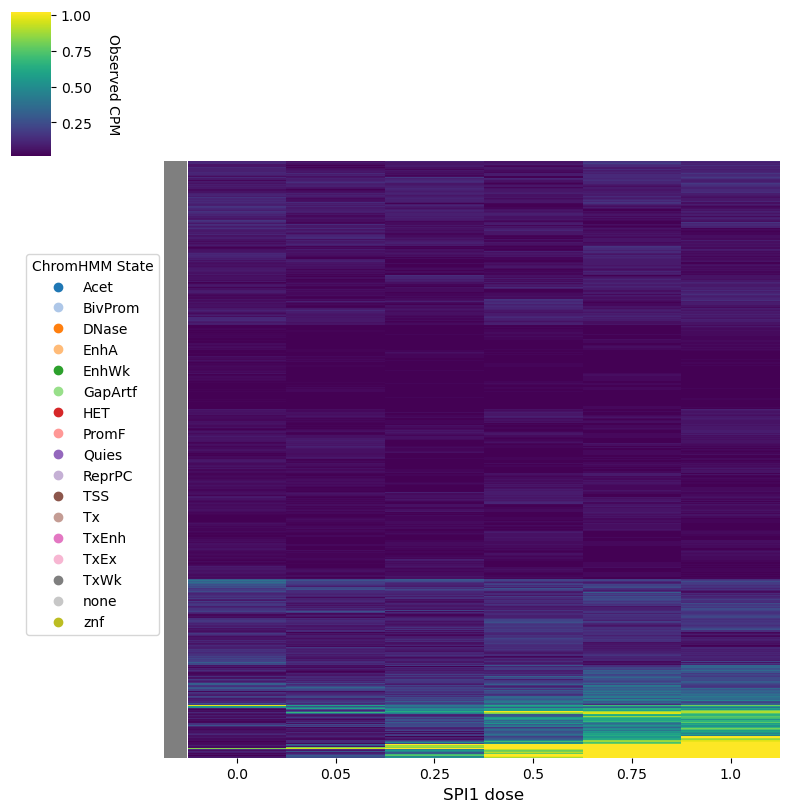

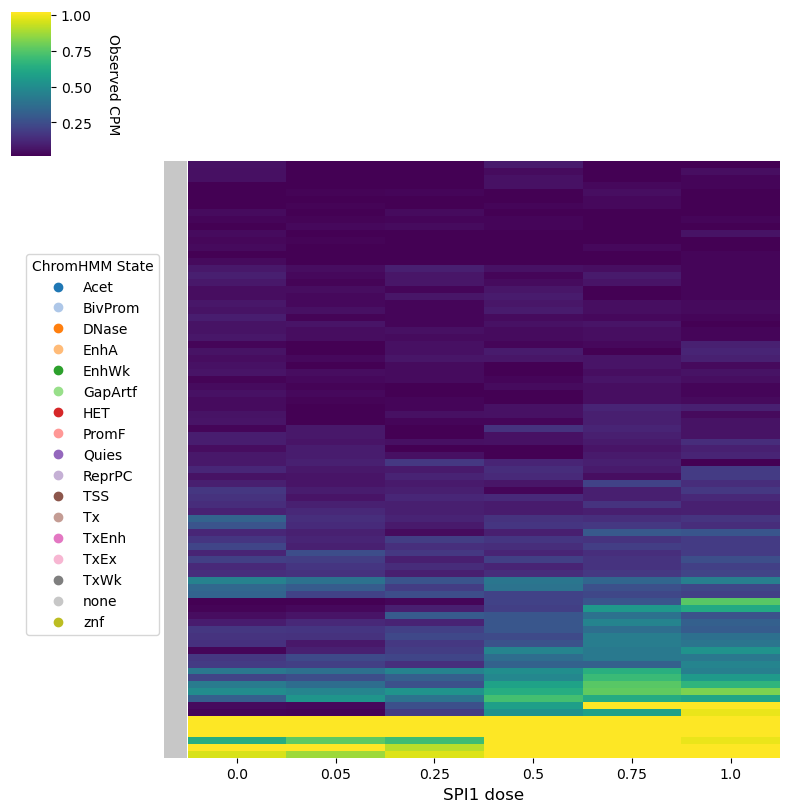

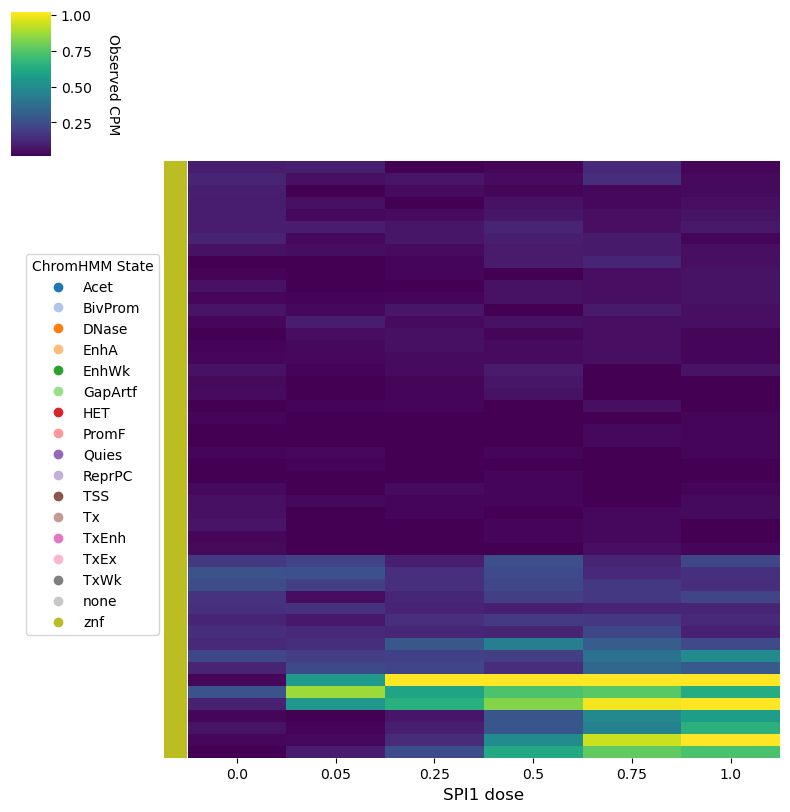

In [321]:
# generate one heatmap per chromhmm state
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Create a PDF file to save the plots
with PdfPages(f'{plotdir}/{TF}_obs_cpm_heatmap_sortbychromhmm_perhmm.pdf') as pdf:        
    for gr in unique_groups:
        mask = (sorted_groups == gr)
        subout = np.array(out)[mask]
        np.random.seed(16)
        g = sns.clustermap(subout, row_cluster=False, col_cluster=False, 
                        row_colors=[group_colors[mask]], 
                        cmap="viridis", figsize=(8, 8), 
                        xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                        vmin = np.percentile(out, 5),
                        vmax = np.percentile(out, 95),
                        )
        legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
        plt.legend(legend_labels, unique_groups, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.2, -2))
        # Add a label to the color bar
        colorbar = g.ax_heatmap.collections[0].colorbar
        colorbar.set_label("Observed CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
        g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

        pdf.savefig()
        plt.show()
        plt.close()


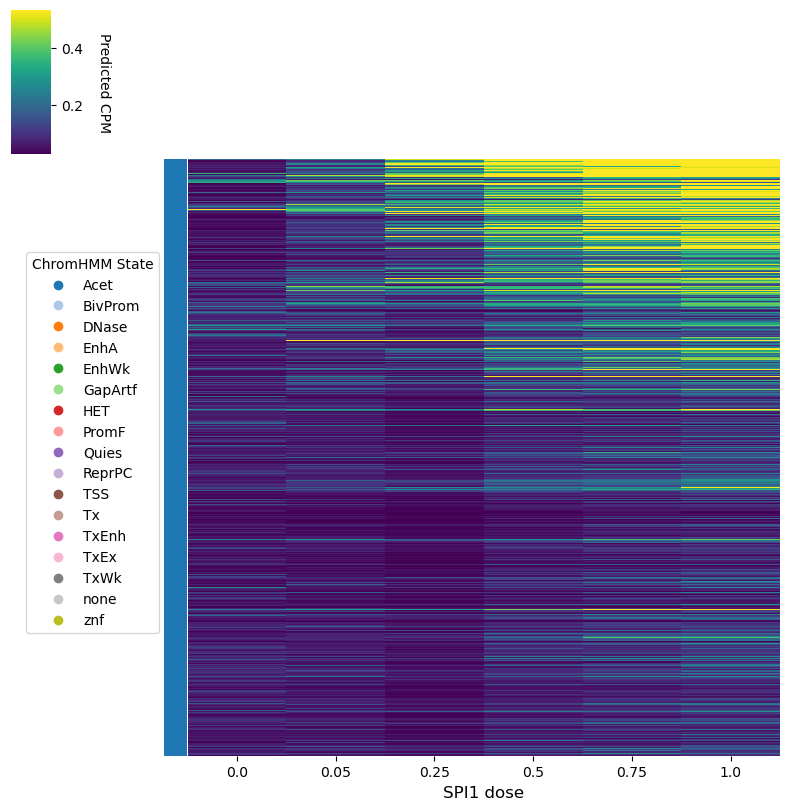

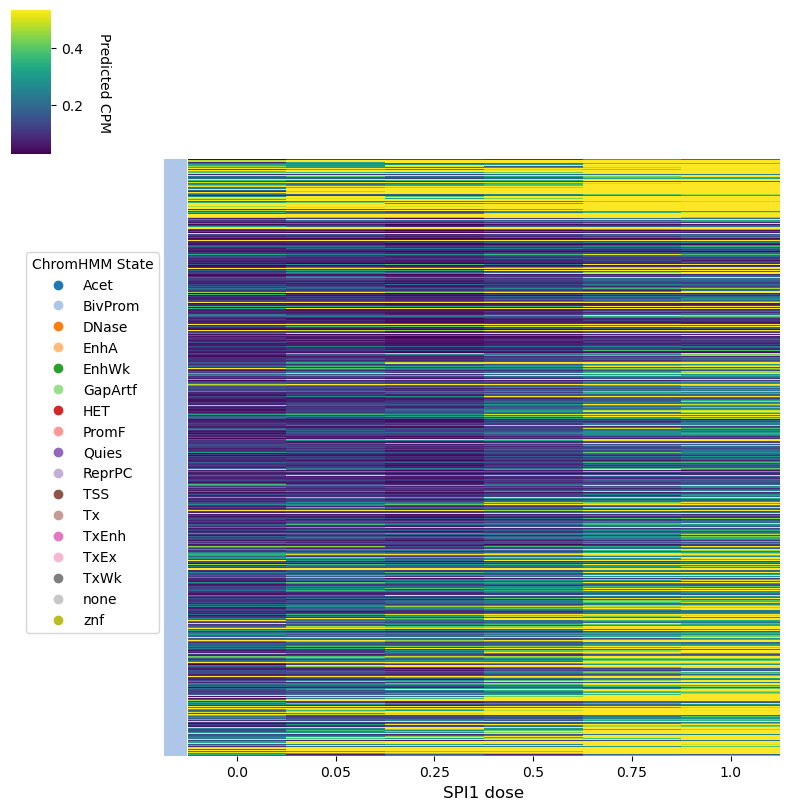

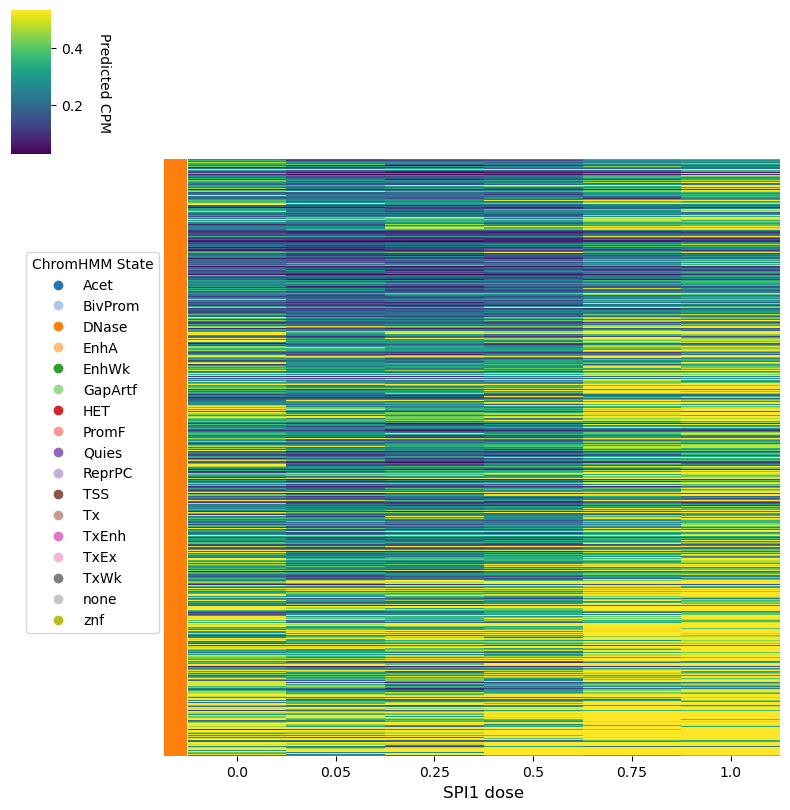

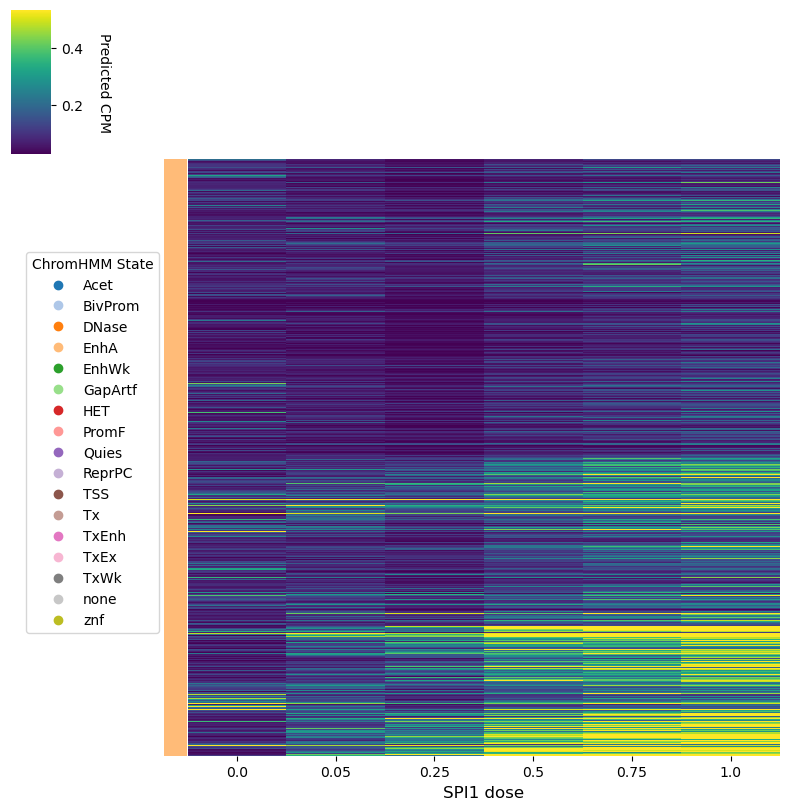

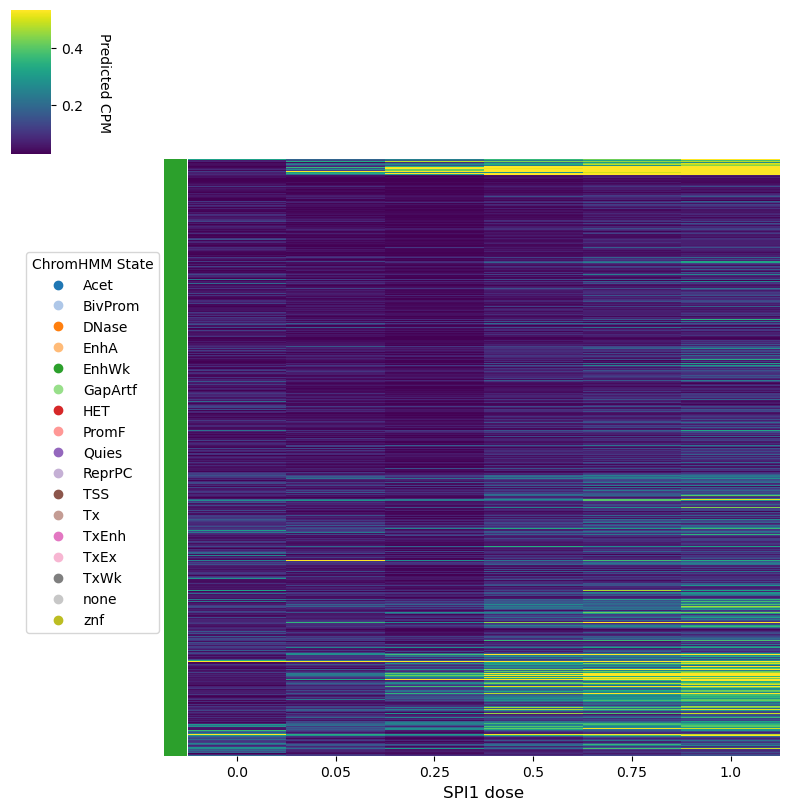

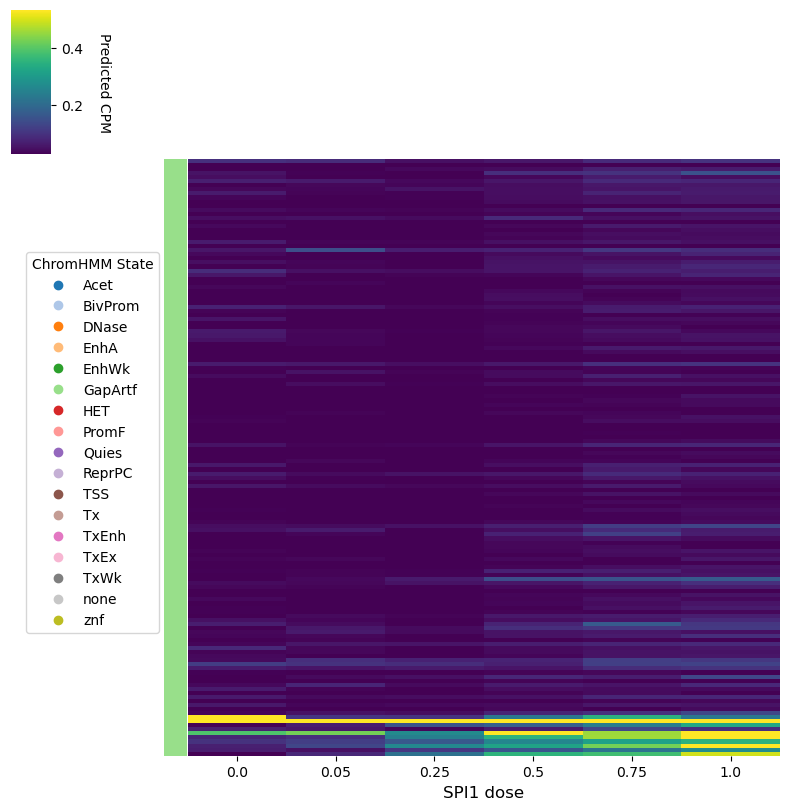

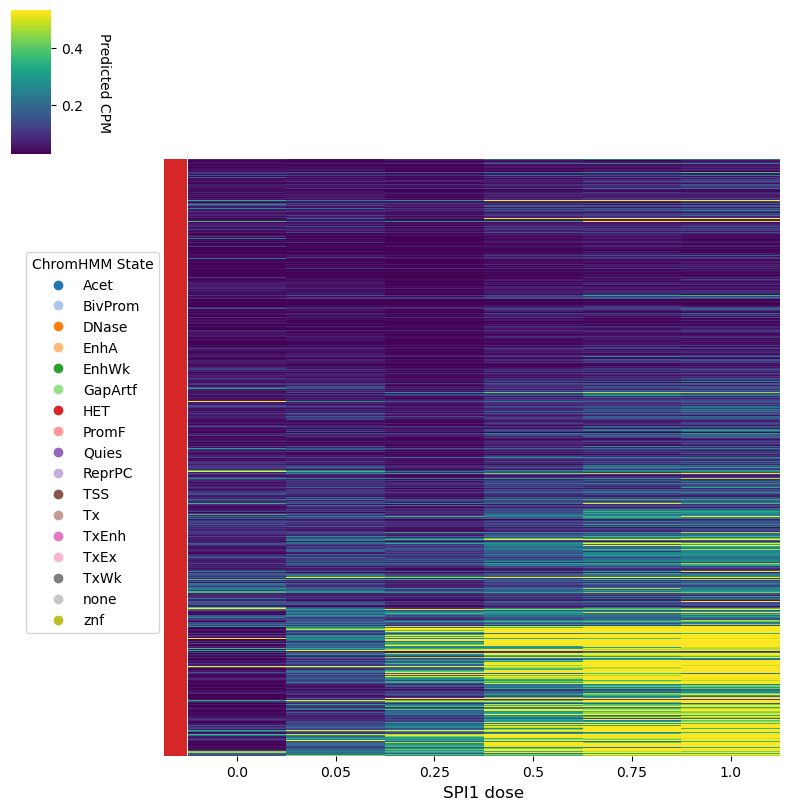

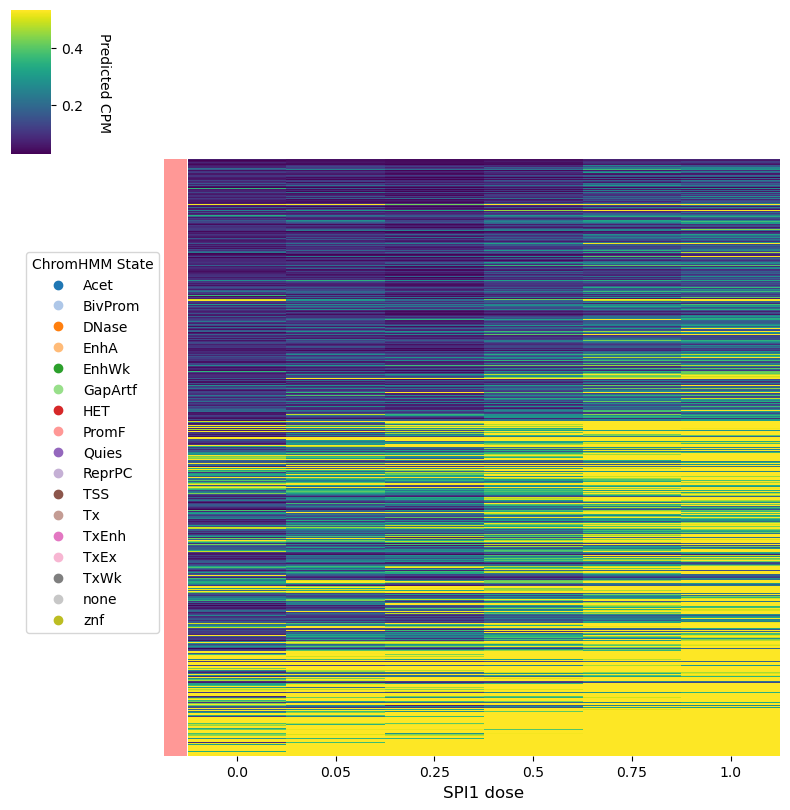

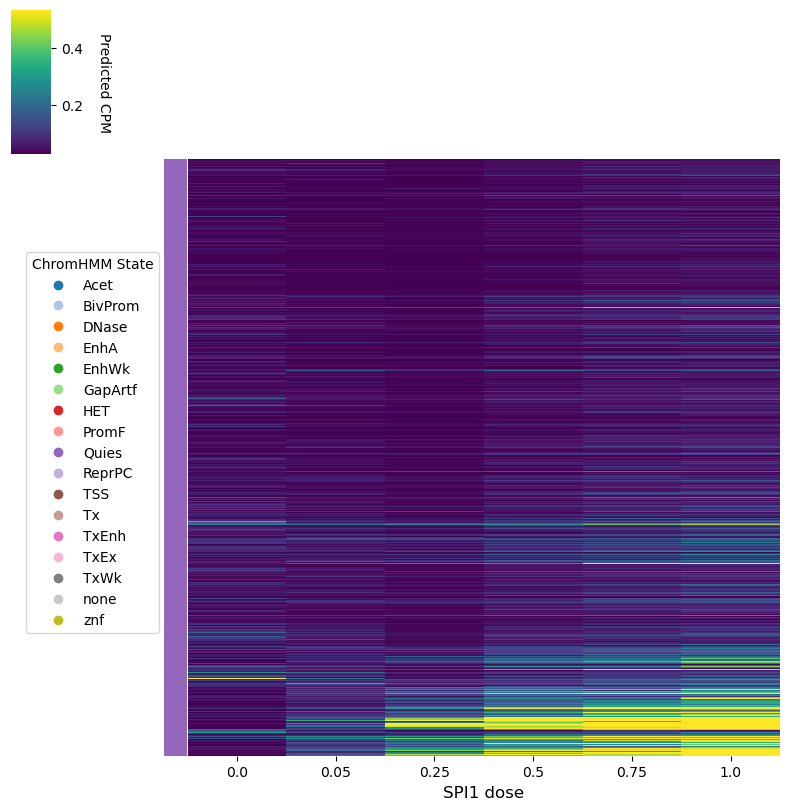

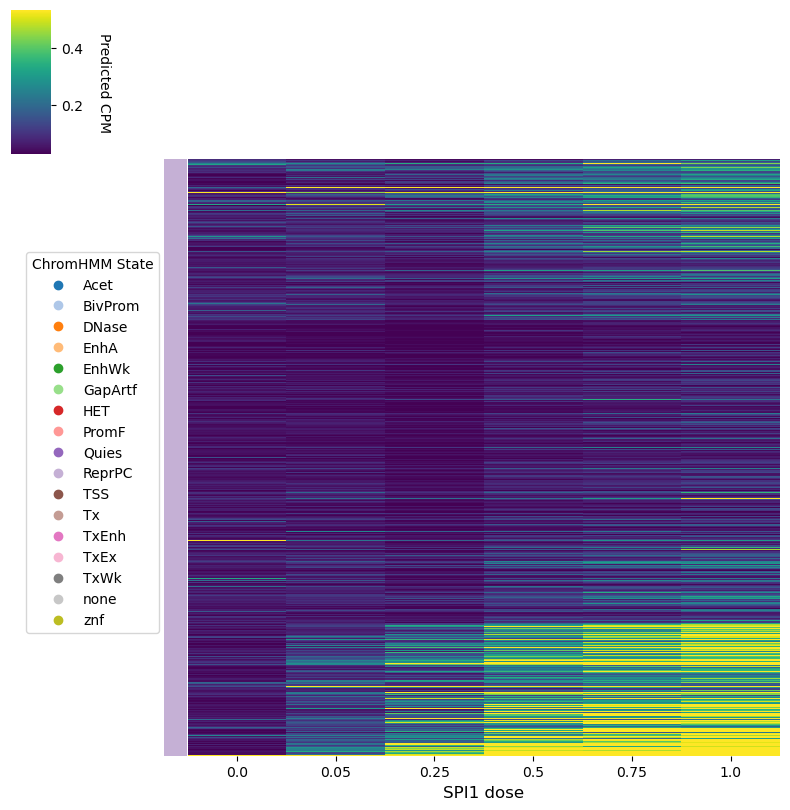

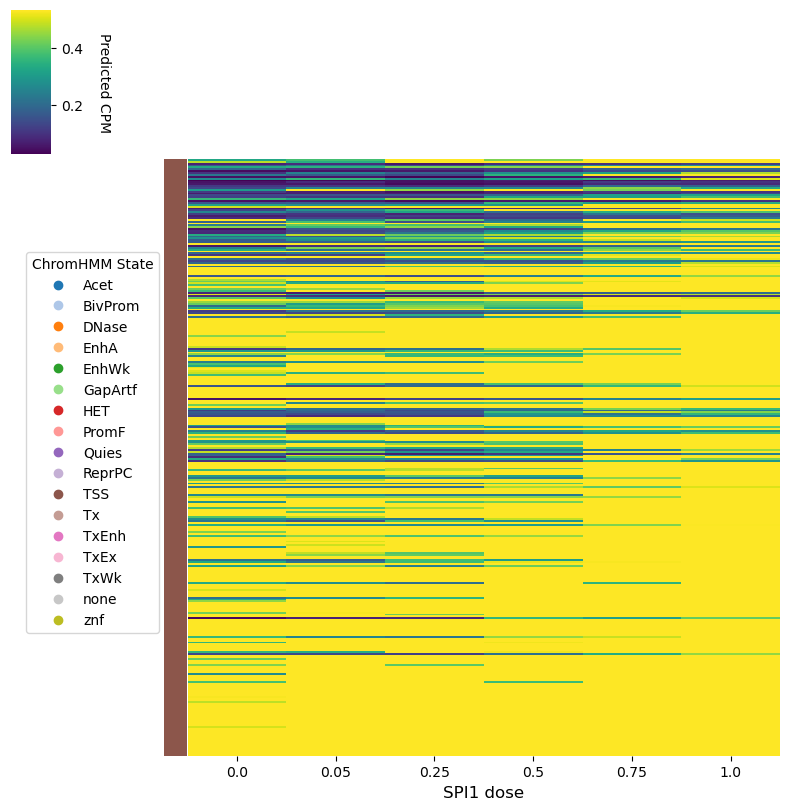

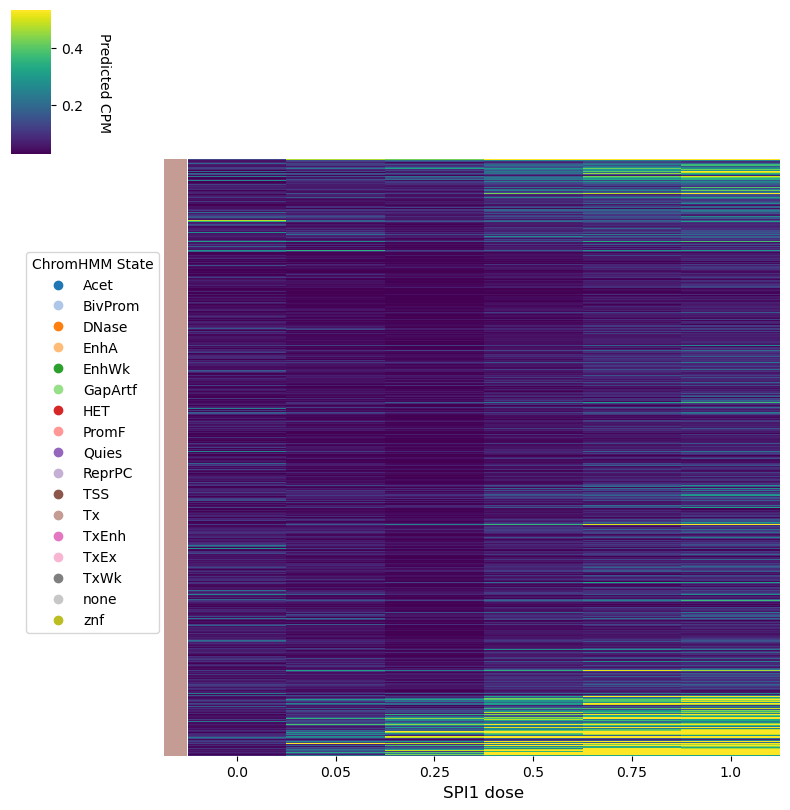

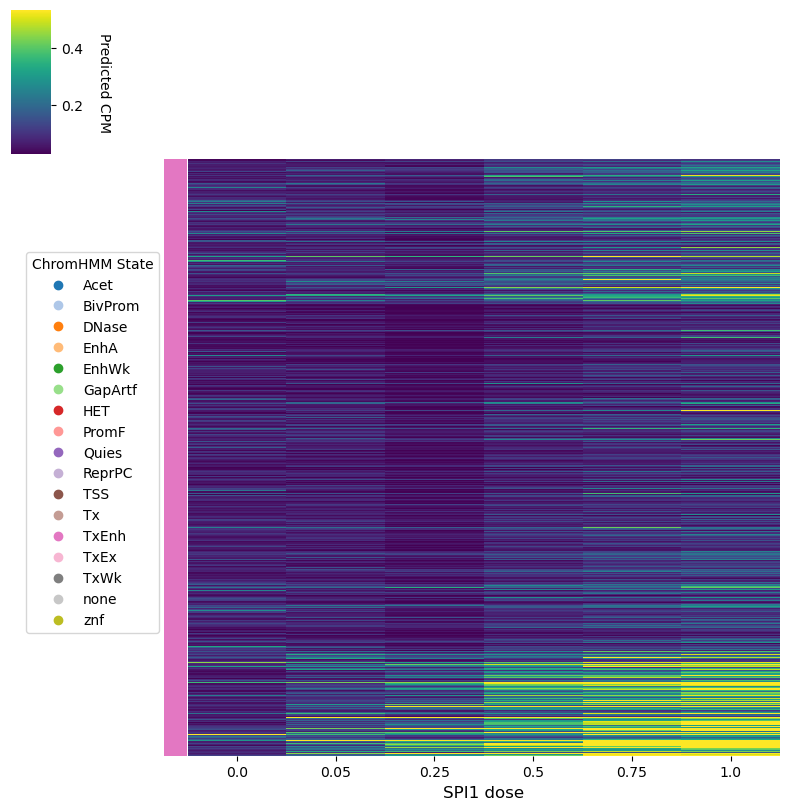

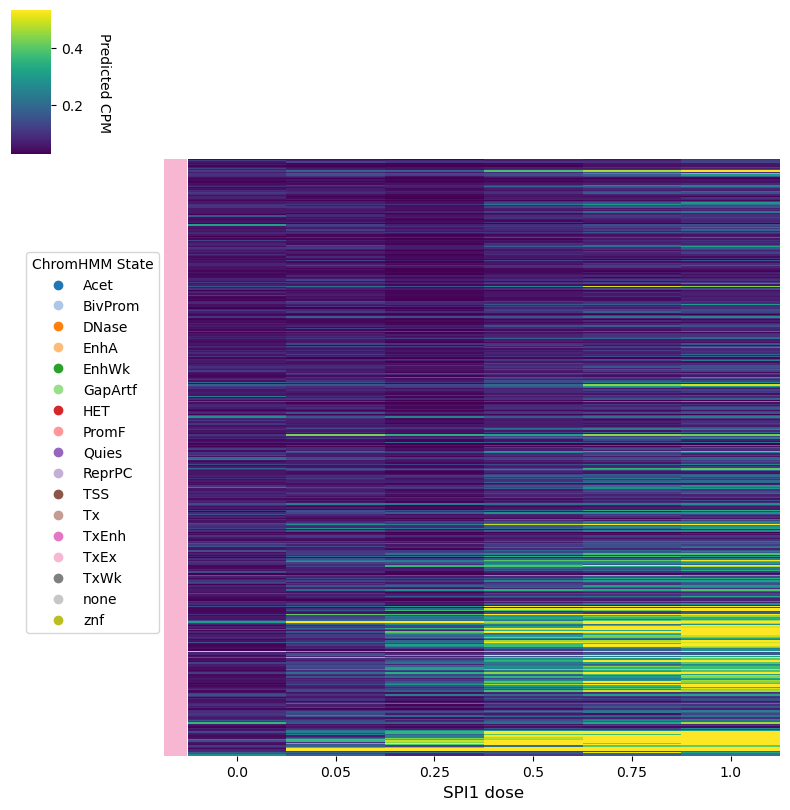

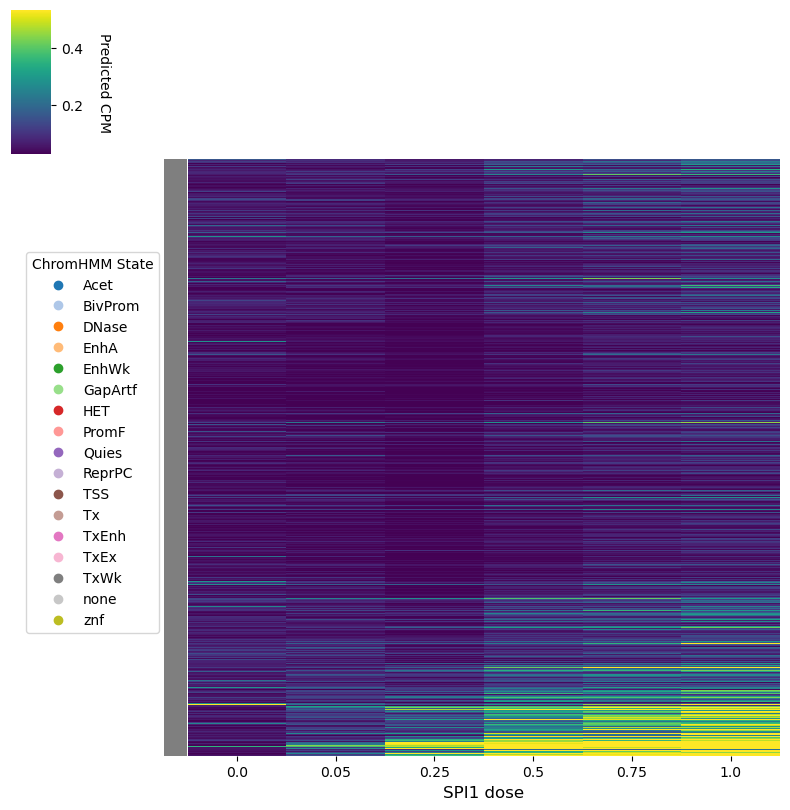

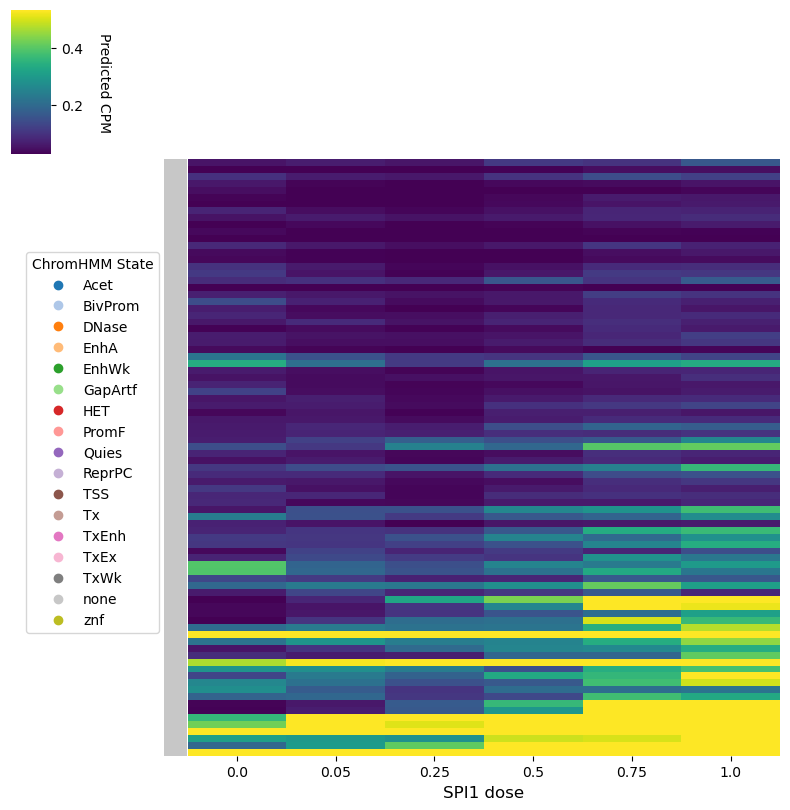

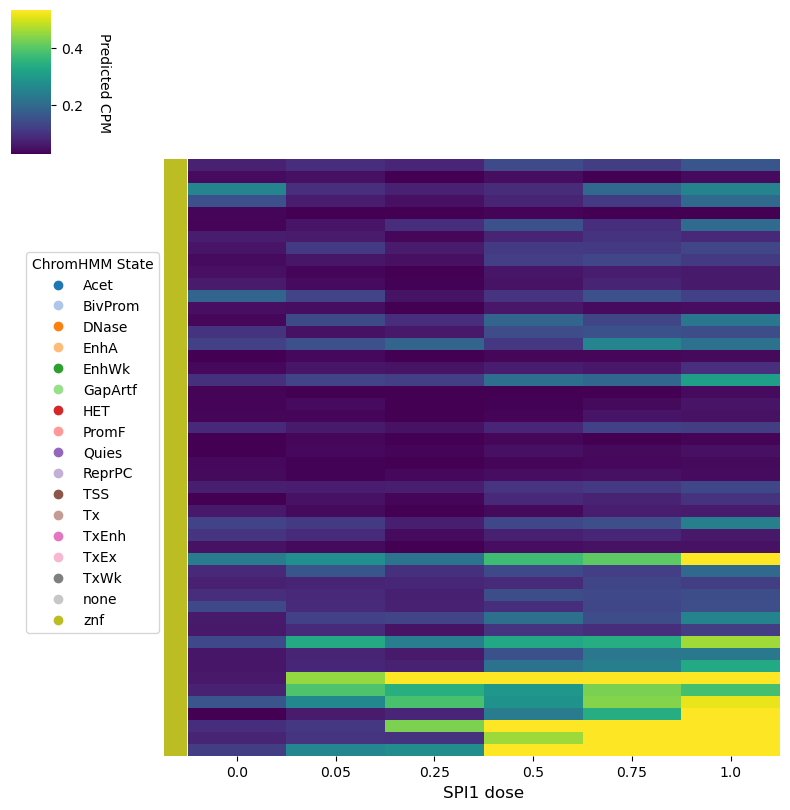

In [320]:
# pred 
# Create a PDF file to save the plots
toplot = obs_peaks_test_preds_500bp_cpm[og_idx]

with PdfPages(f'{plotdir}/{TF}_preds_cpm_heatmap_sortbychromhmm_perhmm.pdf') as pdf:        
    for gr in unique_groups:
        mask = (sorted_groups == gr)
        subout = np.array(toplot)[mask]
        np.random.seed(16)
        g = sns.clustermap(subout, row_cluster=False, col_cluster=False, 
                        row_colors=[group_colors[mask]], 
                        cmap="viridis", figsize=(8, 8), 
                        xticklabels=[0, 0.05, 0.25, 0.5, 0.75, 1], yticklabels=False,
                        vmin = np.percentile(toplot, 5),
                        vmax = np.percentile(toplot, 95),
                        )
        legend_labels = [plt.Line2D([0], [0], marker='o', color=c, linestyle='') for c in cmap.colors]
        plt.legend(legend_labels, unique_groups, title="ChromHMM State", loc="center left", bbox_to_anchor=(0.2, -2))
        # Add a label to the color bar
        colorbar = g.ax_heatmap.collections[0].colorbar
        colorbar.set_label("Predicted CPM", rotation=270, labelpad=20)  # Rotation and padding for better alignment
        g.ax_heatmap.set_xlabel(f"{TF} dose", fontsize=12)

        pdf.savefig()
        plt.show()
        plt.close()


### Try k means clustering

In [163]:
# # if only interested in sensitive peaks
opening_obs_peaks_test_obs_500bp_cpm = obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])]
opening_obs_peaks_test_obs_500bp_cpm_minmax = opening_obs_peaks_test_obs_500bp_cpm - opening_obs_peaks_test_obs_500bp_cpm.min(-1)[:,None]
opening_obs_peaks_test_obs_500bp_cpm_minmax  = opening_obs_peaks_test_obs_500bp_cpm_minmax/opening_obs_peaks_test_obs_500bp_cpm_minmax.max(-1)[:,None]

NCLUST = 2
opening_obs_peaks_test_obs_500bp_cpm_minmax.shape

(5105, 6)

In [146]:
# # if only interested in sensitive peaks, don't scale reads
opening_obs_peaks_test_obs_500bp_cpm_minmax = obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])]
NCLUST = 2
opening_obs_peaks_test_obs_500bp_cpm_minmax.shape

(5105, 6)

In [134]:
# # if only interested in nonsensitive peaks
opening_obs_peaks_test_obs_500bp_cpm_minmax = obs_peaks_test_obs_500bp_cpm[obs_peaks_test['group'].isin(["open nonsensitive", "closed nonsensitive"])]
NCLUST = 2
opening_obs_peaks_test_obs_500bp_cpm_minmax.shape

(32251, 6)

In [97]:
# if interested in all peaks

# normalization doesn't really work for nonsensitive peaks bc we are scaling 0-1 to min and max per peak
#   which artifically inflates the noise from closed peaks and causes weird response curves
opening_obs_peaks_test_obs_500bp_cpm_minmax = obs_peaks_test_obs_500bp_cpm 
NCLUST = 4
opening_obs_peaks_test_obs_500bp_cpm_minmax.shape

(37356, 6)

In [98]:
import sklearn.cluster

In [164]:
kmeans = sklearn.cluster.KMeans(n_clusters=NCLUST, random_state=0, n_init="auto").fit(opening_obs_peaks_test_obs_500bp_cpm_minmax)

In [165]:
Counter(kmeans.labels_)

Counter({0: 2043, 1: 3062})

Text(0.5, 1.0, 'K-means on observed data')

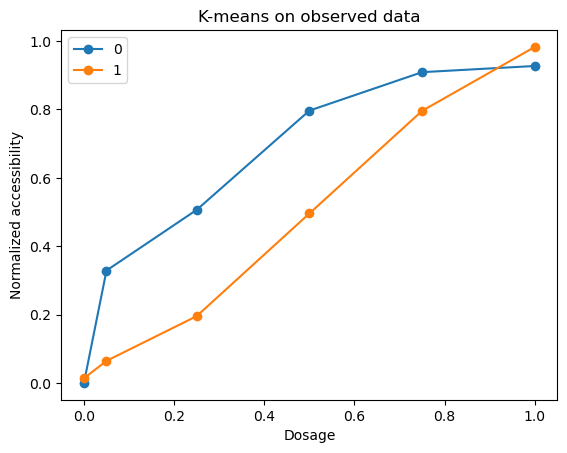

In [166]:
for i in range(NCLUST):
    plt.plot([0, .05, .25,.5, .75,1], opening_obs_peaks_test_obs_500bp_cpm_minmax[kmeans.labels_==i].mean(0), 'o-', label=i)

plt.legend()
plt.ylabel("Normalized accessibility")
plt.xlabel("Dosage")

plt.title("K-means on observed data")

See how this looks with predicted scores

In [169]:
# if only interested in sensitive peaks
opening_obs_peaks_test_preds_500bp_cpm = obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])]

opening_obs_peaks_test_preds_500bp_cpm_minmax = opening_obs_peaks_test_preds_500bp_cpm - opening_obs_peaks_test_preds_500bp_cpm.min(-1)[:,None]
opening_obs_peaks_test_preds_500bp_cpm_minmax = opening_obs_peaks_test_preds_500bp_cpm_minmax/opening_obs_peaks_test_preds_500bp_cpm_minmax.max(-1)[:,None]
opening_obs_peaks_test_preds_500bp_cpm_minmax.shape

(5105, 6)

In [168]:
# if only interested in sensitive peaks, don't scale reads
opening_obs_peaks_test_preds_500bp_cpm_minmax = obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])]
opening_obs_peaks_test_preds_500bp_cpm_minmax.shape

(5105, 6)

In [139]:
# if only interested in nonsensitive peaks
opening_obs_peaks_test_preds_500bp_cpm_minmax = obs_peaks_test_preds_500bp_cpm[obs_peaks_test['group'].isin(["open nonsensitive", "closed nonsensitive"])]
opening_obs_peaks_test_preds_500bp_cpm_minmax.shape

(32251, 6)

In [106]:
# if interested in all peaks
opening_obs_peaks_test_preds_500bp_cpm_minmax = obs_peaks_test_preds_500bp_cpm 
opening_obs_peaks_test_preds_500bp_cpm_minmax.shape

(37356, 6)

Text(0.5, 1.0, 'ChromBPNet predictions labelled with K-means on observed data')

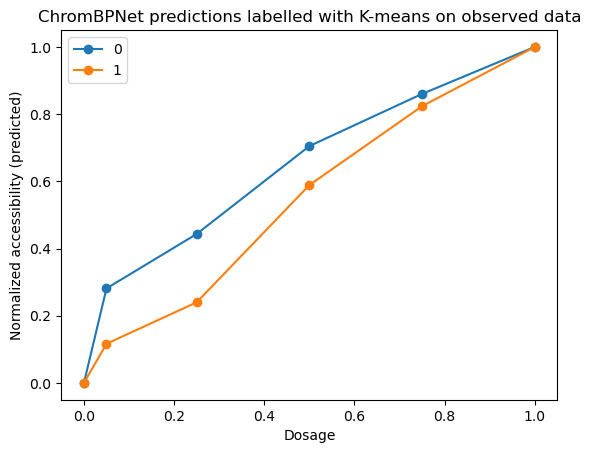

In [170]:
for i in range(NCLUST):
    to_plot = opening_obs_peaks_test_preds_500bp_cpm_minmax[kmeans.labels_==i].mean(0)
    # re min-max if only looking at sensitive peaks
    to_plot = (to_plot - min(to_plot))/max(to_plot - min(to_plot))
    plt.plot([0, .05, .25, .5, .75, 1], to_plot, 'o-', label=i)

plt.legend()
plt.ylabel("Normalized accessibility (predicted)")
plt.xlabel("Dosage")

plt.title("ChromBPNet predictions labelled with K-means on observed data")

In [66]:
obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])][kmeans.labels_==3].sample(10)

sensitive saturating          EC50  \
HEK293T_P3E7_SPI1_d100_peak_11355          Yes        Yes  9.791792e-05   
HEK293T_P3F10_SPI1_d025_peak_879598        Yes        Yes  9.350133e-06   
HEK293T_P3F10_SPI1_d025_peak_627292        Yes        Yes  1.778882e-06   
HEK293T_P3F10_SPI1_d025_peak_23613         Yes        Yes  1.133419e-05   
HEK293T_P3H2_KLF1_d100_peak_968051         Yes        Yes  3.401946e-06   
HEK293T_P3F10_SPI1_d025_peak_67714         Yes        Yes  8.637130e-07   
HEK293T_P3E11_SPI1_d005_peak_259935b       Yes        Yes  4.012853e-06   
HEK293T_P3H9_SPI1_d050_peak_214667         Yes        Yes  2.691996e-05   
HEK293T_P3F10_SPI1_d025_peak_72442         Yes        Yes  4.526900e-06   
HEK293T_P3F10_SPI1_d025_peak_639913        Yes        Yes  1.494701e-05   

                                             h state                 group  \
HEK293T_P3E7_SPI1_d100_peak_11355     3.948421   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_879598   5.919482   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_627292   4.864193   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_23613    6.206426   NaN  saturating sensitive   
HEK293T_P3H2_KLF1_d100_peak_968051    5.915665   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_67714    4.607519   NaN  saturating sensitive   
HEK293T_P3E11_SPI1_d005_peak_259935b  5.915904   NaN  saturating sensitive   
HEK293T_P3H9_SPI1_d050_peak_214667    0.149794   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_72442    5.916183   NaN  saturating sensitive   
HEK293T_P3F10_SPI1_d025_peak_639913   5.920912   NaN  saturating sensitive   

                                       chr      start        end  \
HEK293T_P3E7_SPI1_d100_peak_11355     chr1   61115132   61115634   
HEK293T_P3F10_SPI1_d025_peak_879598   chr6  160788250  160788752   
HEK293T_P3F10_SPI1_d025_peak_627292   chr3   73302626   73303128   
HEK293T_P3F10_SPI1_d025_peak_23613    chr1   55217495   55217997   
HEK293T_P3H2_KLF1_d100_peak_968051    chr3   25234588   25235090   
HEK293T_P3F10_SPI1_d025_peak_67714    chr1  177477885  177478387   
HEK293T_P3E11_SPI1_d005_peak_259935b  chr3   31232875   31233377   
HEK293T_P3H9_SPI1_d050_peak_214667    chr3  112579130  112579632   
HEK293T_P3F10_SPI1_d025_peak_72442    chr1  186654650  186655152   
HEK293T_P3F10_SPI1_d025_peak_639913   chr3  106271378  106271880   

                                                                      name  \
HEK293T_P3E7_SPI1_d100_peak_11355        HEK293T_P3E7_SPI1_d100_peak_11355   
HEK293T_P3F10_SPI1_d025_peak_879598    HEK293T_P3F10_SPI1_d025_peak_879598   
HEK293T_P3F10_SPI1_d025_peak_627292    HEK293T_P3F10_SPI1_d025_peak_627292   
HEK293T_P3F10_SPI1_d025_peak_23613      HEK293T_P3F10_SPI1_d025_peak_23613   
HEK293T_P3H2_KLF1_d100_peak_968051      HEK293T_P3H2_KLF1_d100_peak_968051   
HEK293T_P3F10_SPI1_d025_peak_67714      HEK293T_P3F10_SPI1_d025_peak_67714   
HEK293T_P3E11_SPI1_d005_peak_259935b  HEK293T_P3E11_SPI1_d005_peak_259935b   
HEK293T_P3H9_SPI1_d050_peak_214667      HEK293T_P3H9_SPI1_d050_peak_214667   
HEK293T_P3F10_SPI1_d025_peak_72442      HEK293T_P3F10_SPI1_d025_peak_72442   
HEK293T_P3F10_SPI1_d025_peak_639913    HEK293T_P3F10_SPI1_d025_peak_639913   

                                            x1 x2  summit  
HEK293T_P3E7_SPI1_d100_peak_11355     13.79674  .     251  
HEK293T_P3F10_SPI1_d025_peak_879598    3.97780  .     251  
HEK293T_P3F10_SPI1_d025_peak_627292    5.63883  .     251  
HEK293T_P3F10_SPI1_d025_peak_23613     9.23224  .     251  
HEK293T_P3H2_KLF1_d100_peak_968051     4.74662  .     251  
HEK293T_P3F10_SPI1_d025_peak_67714     5.63883  .     251  
HEK293T_P3E11_SPI1_d005_peak_259935b   8.18420  .     251  
HEK293T_P3H9_SPI1_d050_peak_214667    13.20812  .     251  
HEK293T_P3F10_SPI1_d025_peak_72442     7.39613  .     251  
HEK293T_P3F10_SPI1_d025_peak_639913   11.13507  .     251

In [67]:
opening_obs_peaks_test_preds_500bp_cpm_minmax

array([[0.        , 0.29190433, 0.46035898, 0.4682713 , 0.63945335,
        1.        ],
       [0.        , 0.08575822, 0.2502185 , 0.42675814, 0.8539584 ,
        1.        ],
       [0.        , 0.06600988, 0.25455156, 0.5216585 , 0.7799906 ,
        1.        ],
       ...,
       [0.        , 0.05575572, 0.42388764, 0.5381081 , 0.8001763 ,
        1.        ],
       [0.        , 0.292618  , 0.4531398 , 0.9148153 , 0.7671752 ,
        1.        ],
       [0.        , 0.16168222, 0.31906918, 0.5903229 , 0.56810075,
        1.        ]], dtype=float32)

In [174]:
# use kmeans fit on observed data on the predicted data
kmeans_labels_on_predicted = kmeans.predict(opening_obs_peaks_test_preds_500bp_cpm_minmax.astype(np.double))

In [175]:
Counter(obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])].loc[kmeans.labels_==0, "group"])

Counter({'saturating sensitive': 2035, 'nonsaturating sensitive': 8})

In [176]:
Counter(obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])].loc[kmeans.labels_==1, "group"])

Counter({'saturating sensitive': 2107, 'nonsaturating sensitive': 955})

In [178]:
Counter(obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])].loc[kmeans_labels_on_predicted==0, "group"])

Counter({'saturating sensitive': 1825, 'nonsaturating sensitive': 204})

In [179]:
Counter(obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])].loc[kmeans_labels_on_predicted==1, "group"])

Counter({'saturating sensitive': 2317, 'nonsaturating sensitive': 759})

In [177]:
f"{np.mean(kmeans_labels_on_predicted == kmeans.labels_)*100:.2f}% of peaks were correctly clustered"

'71.56% of peaks were correctly clustered'

In [154]:
print("clustering accuracy:")
[print(f"{np.mean(kmeans_labels_on_predicted[kmeans.labels_== g] == kmeans.labels_[kmeans.labels_== g])*100:.2f}% of peaks in kmeans group {g} were correctly clustered") \
    for g in set(kmeans.labels_)]

clustering accuracy:
99.84% of peaks in kmeans group 0 were correctly clustered
9.24% of peaks in kmeans group 1 were correctly clustered


[None, None]

Text(0.5, 1.0, 'Model predictions using K-means on observed data')

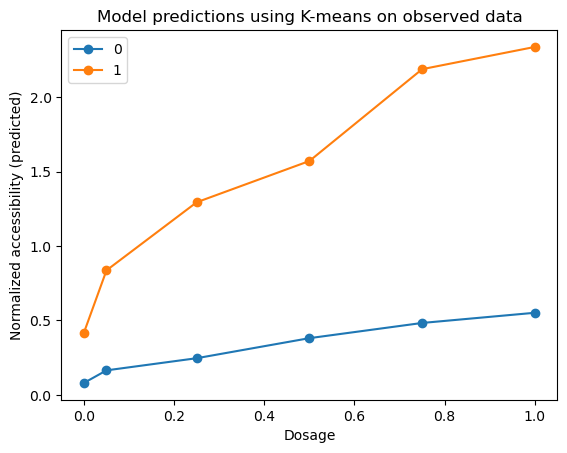

In [155]:
for i in range(NCLUST):
    to_plot = opening_obs_peaks_test_preds_500bp_cpm_minmax[kmeans_labels_on_predicted==i].mean(0)
    # # re min-max
    # to_plot = (to_plot - min(to_plot))/max(to_plot - min(to_plot))
    plt.plot([0, .05, .25, .5, .75, 1], to_plot, 'o-', label=i)

plt.legend()
plt.ylabel("Normalized accessibility (predicted)")
plt.xlabel("Dosage")

plt.title("Model predictions using K-means on observed data")

In [71]:
obs_peaks_test[obs_peaks_test['group'].isin(["saturating sensitive", "nonsaturating sensitive"])][kmeans_labels_on_predicted==2].sample(10)

sensitive saturating      EC50          h  \
HEK293T_P3H8_SPI1_d075_peak_225605        Yes        Yes  0.047708   9.812789   
HEK293T_P3G7_SPI1_d100_peak_267073b       Yes         No  0.572519   3.027467   
HEK293T_P3E7_SPI1_d100_peak_26017         Yes        Yes  0.279146   1.807531   
HEK293T_P3D4_KLF4_d050_peak_30770         Yes         No  0.407292   2.711567   
HEK293T_P3G7_SPI1_d100_peak_273124        Yes        Yes  0.275251   4.090356   
HEK293T_P3G7_SPI1_d100_peak_275675        Yes         No  0.515378   2.436286   
HEK293T_P3H9_SPI1_d050_peak_5080          Yes        Yes  0.104524   0.977381   
HEK293T_P1D3_ELF1_d075_peak_453091        Yes        Yes  0.489736  10.000000   
HEK293T_P3C3_KLF4_d075_peak_862429        Yes        Yes  0.538149  10.000000   
HEK293T_P1G10_IRF4_d025_peak_40000        Yes        Yes  0.116993   1.484056   

                                    state                    group   chr  \
HEK293T_P3H8_SPI1_d075_peak_225605    NaN     saturating sensitive  chr3   
HEK293T_P3G7_SPI1_d100_peak_267073b   NaN  nonsaturating sensitive  chr3   
HEK293T_P3E7_SPI1_d100_peak_26017     NaN     saturating sensitive  chr1   
HEK293T_P3D4_KLF4_d050_peak_30770     NaN  nonsaturating sensitive  chr1   
HEK293T_P3G7_SPI1_d100_peak_273124    NaN     saturating sensitive  chr3   
HEK293T_P3G7_SPI1_d100_peak_275675    NaN  nonsaturating sensitive  chr3   
HEK293T_P3H9_SPI1_d050_peak_5080      NaN     saturating sensitive  chr1   
HEK293T_P1D3_ELF1_d075_peak_453091    NaN     saturating sensitive  chr6   
HEK293T_P3C3_KLF4_d075_peak_862429    NaN     saturating sensitive  chr3   
HEK293T_P1G10_IRF4_d025_peak_40000    NaN     saturating sensitive  chr1   

                                         start        end  \
HEK293T_P3H8_SPI1_d075_peak_225605   122767932  122768434   
HEK293T_P3G7_SPI1_d100_peak_267073b  113091174  113091676   
HEK293T_P3E7_SPI1_d100_peak_26017    156154582  156155084   
HEK293T_P3D4_KLF4_d050_peak_30770    237051020  237051522   
HEK293T_P3G7_SPI1_d100_peak_273124   151617028  151617530   
HEK293T_P3G7_SPI1_d100_peak_275675   168809936  168810438   
HEK293T_P3H9_SPI1_d050_peak_5080      33421098   33421600   
HEK293T_P1D3_ELF1_d075_peak_453091   129208568  129209070   
HEK293T_P3C3_KLF4_d075_peak_862429   192723659  192724161   
HEK293T_P1G10_IRF4_d025_peak_40000   212491337  212491839   

                                                                    name  \
HEK293T_P3H8_SPI1_d075_peak_225605    HEK293T_P3H8_SPI1_d075_peak_225605   
HEK293T_P3G7_SPI1_d100_peak_267073b  HEK293T_P3G7_SPI1_d100_peak_267073b   
HEK293T_P3E7_SPI1_d100_peak_26017      HEK293T_P3E7_SPI1_d100_peak_26017   
HEK293T_P3D4_KLF4_d050_peak_30770      HEK293T_P3D4_KLF4_d050_peak_30770   
HEK293T_P3G7_SPI1_d100_peak_273124    HEK293T_P3G7_SPI1_d100_peak_273124   
HEK293T_P3G7_SPI1_d100_peak_275675    HEK293T_P3G7_SPI1_d100_peak_275675   
HEK293T_P3H9_SPI1_d050_peak_5080        HEK293T_P3H9_SPI1_d050_peak_5080   
HEK293T_P1D3_ELF1_d075_peak_453091    HEK293T_P1D3_ELF1_d075_peak_453091   
HEK293T_P3C3_KLF4_d075_peak_862429    HEK293T_P3C3_KLF4_d075_peak_862429   
HEK293T_P1G10_IRF4_d025_peak_40000    HEK293T_P1G10_IRF4_d025_peak_40000   

                                           x1 x2  summit  
HEK293T_P3H8_SPI1_d075_peak_225605   22.87302  .     251  
HEK293T_P3G7_SPI1_d100_peak_267073b  23.46221  .     251  
HEK293T_P3E7_SPI1_d100_peak_26017    15.32512  .     251  
HEK293T_P3D4_KLF4_d050_peak_30770    11.03626  .     251  
HEK293T_P3G7_SPI1_d100_peak_273124   18.52098  .     251  
HEK293T_P3G7_SPI1_d100_peak_275675   12.33581  .     251  
HEK293T_P3H9_SPI1_d050_peak_5080     16.39940  .     251  
HEK293T_P1D3_ELF1_d075_peak_453091   10.36687  .     251  
HEK293T_P3C3_KLF4_d075_peak_862429    8.40106  .     251  
HEK293T_P1G10_IRF4_d025_peak_40000    8.26119  .     251

## Logistic regression sensitivity class prediction

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc

In [5]:
allpr = pd.DataFrame()
allauc = pd.DataFrame()

### chrombpnet features only

Confusion Matrix:
[[5350    0  105  107]
 [  71    0    6  115]
 [ 544    0  318   53]
 [ 251    1   52  499]]

Classification Report:
                         precision    recall  f1-score   support

    closed nonsensitive       0.86      0.96      0.91      5562
nonsaturating sensitive       0.00      0.00      0.00       192
      open nonsensitive       0.66      0.35      0.46       915
   saturating sensitive       0.64      0.62      0.63       803

               accuracy                           0.83      7472
              macro avg       0.54      0.48      0.50      7472
           weighted avg       0.79      0.83      0.80      7472



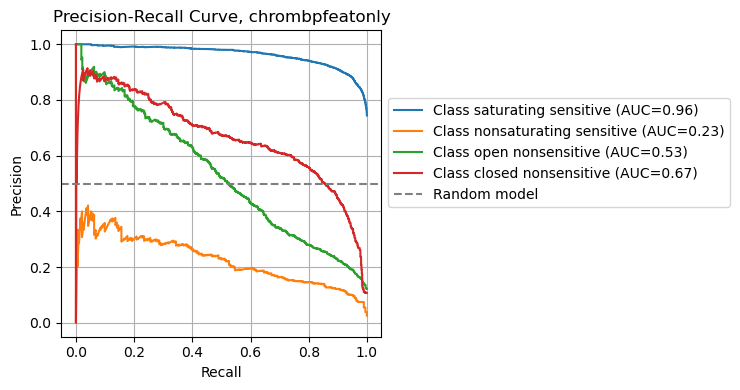

In [180]:
suffix = "chrombpfeatonly"

X = obs_peaks_test_preds_500bp_cpm
y = obs_peaks_test.group 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# fit elastic net LR model

model = LogisticRegression(multi_class='multinomial', penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get predicted probabilities
y_scores = model.predict_proba(X_test)  # Probability estimates for the positive class

# Binarize the output for calculating precision-recall
classes = ['saturating sensitive', 'nonsaturating sensitive',
       'open nonsensitive', 'closed nonsensitive']
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(7.5, 4))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)  # Calculate AUC for PR curve
    allpr = pd.concat([allpr, pd.DataFrame({"feat": suffix, "group": classes[i], "precision": precision, "recall": recall})], ignore_index=True)
    allauc = pd.concat([allauc, pd.DataFrame({"feat": suffix, "group": [classes[i]], "aucpr": [pr_auc]})], ignore_index=True)

    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC={pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve, {suffix}')
plt.axhline(0.5, linestyle='--', color='grey', label='Random model')
plt.legend(loc="lower left", bbox_to_anchor=[1, 0.4])
plt.grid()
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_{suffix}.pdf")
plt.show()


### chromHMM features only

Confusion Matrix:
[[5385    0  177    0]
 [ 183    0    9    0]
 [ 713    0  202    0]
 [ 766    0   37    0]]

Classification Report:


/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

                         precision    recall  f1-score   support

    closed nonsensitive       0.76      0.97      0.85      5562
nonsaturating sensitive       0.00      0.00      0.00       192
      open nonsensitive       0.48      0.22      0.30       915
   saturating sensitive       0.00      0.00      0.00       803

               accuracy                           0.75      7472
              macro avg       0.31      0.30      0.29      7472
           weighted avg       0.63      0.75      0.67      7472



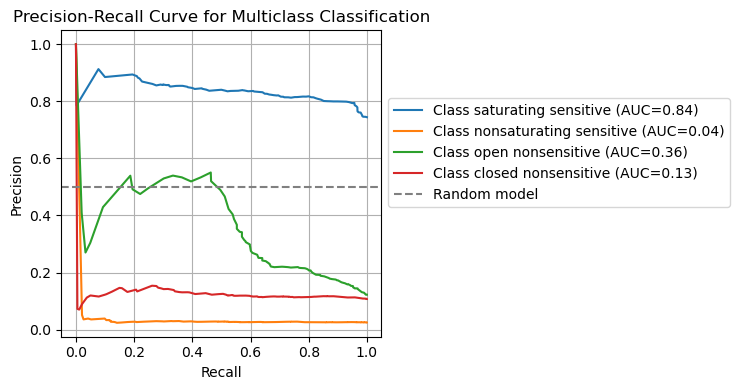

In [181]:
suffix="chromhmmfeatonly"

X = np.column_stack([obs_peaks_test.chromhmm_state_id, obs_peaks_test.chromhmm_state_id_broad])
y = obs_peaks_test.group 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# fit elastic net LR model
model = LogisticRegression(multi_class='multinomial', penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get predicted probabilities
y_scores = model.predict_proba(X_test)  # Probability estimates for the positive class

# Binarize the output for calculating precision-recall
classes = ['saturating sensitive', 'nonsaturating sensitive',
       'open nonsensitive', 'closed nonsensitive']
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(7.5, 4))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)  # Calculate AUC for PR curve
    allpr = pd.concat([allpr, pd.DataFrame({"feat": suffix, "group": classes[i], "precision": precision, "recall": recall})], ignore_index=True)
    allauc = pd.concat([allauc, pd.DataFrame({"feat": suffix, "group": [classes[i]], "aucpr": [pr_auc]})], ignore_index=True)

    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC={pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.axhline(0.5, linestyle='--', color='grey', label='Random model')
plt.legend(loc="lower left", bbox_to_anchor=[1, 0.4])
plt.grid()
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_{suffix}.pdf")
plt.show()


### chrombpnet + chromHMM features

/oak/stanford/groups/wjg/bliu/software/miniconda3/envs/chrombpnet/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix:
[[5367    0  102   93]
 [  69    0   11  112]
 [ 514    1  354   46]
 [ 261    0   63  479]]

Classification Report:
                         precision    recall  f1-score   support

    closed nonsensitive       0.86      0.96      0.91      5562
nonsaturating sensitive       0.00      0.00      0.00       192
      open nonsensitive       0.67      0.39      0.49       915
   saturating sensitive       0.66      0.60      0.62       803

               accuracy                           0.83      7472
              macro avg       0.55      0.49      0.51      7472
           weighted avg       0.80      0.83      0.81      7472



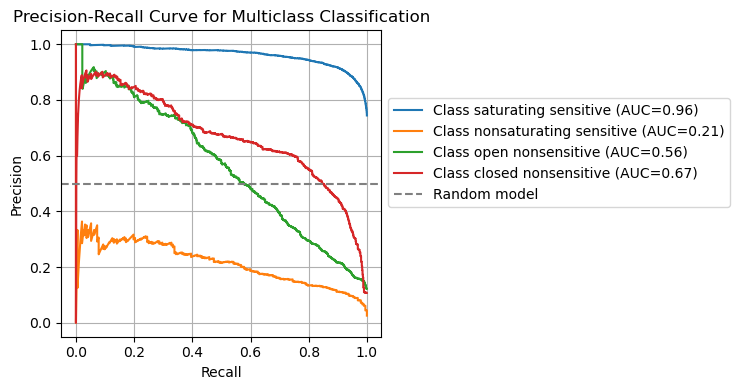

In [182]:
suffix = "chrombp+chromhmmfeat"

X = np.column_stack([obs_peaks_test_preds_500bp_cpm, obs_peaks_test.chromhmm_state_id, obs_peaks_test.chromhmm_state_id_broad])
y = obs_peaks_test.group 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# fit elastic net LR model
model = LogisticRegression(multi_class='multinomial', penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Get predicted probabilities
y_scores = model.predict_proba(X_test)  # Probability estimates for the positive class

# Binarize the output for calculating precision-recall
classes = ['saturating sensitive', 'nonsaturating sensitive',
       'open nonsensitive', 'closed nonsensitive']
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_bin.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(7.5, 4))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)  # Calculate AUC for PR curve
    allpr = pd.concat([allpr, pd.DataFrame({"feat": suffix, "group": classes[i], "precision": precision, "recall": recall})], ignore_index=True)
    allauc = pd.concat([allauc, pd.DataFrame({"feat": suffix, "group": [classes[i]], "aucpr": [pr_auc]})], ignore_index=True)

    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC={pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.axhline(0.5, linestyle='--', color='grey', label='Random model')
plt.legend(loc="lower left", bbox_to_anchor=[1, 0.4])
plt.grid()
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_{suffix}.pdf")
plt.show()


#### check the performance of train data

Confusion Matrix:
[[21405     0   371   341]
 [  339     0    27   405]
 [ 2111     0  1372   174]
 [ 1083     2   193  2061]]

Classification Report:
                         precision    recall  f1-score   support

    closed nonsensitive       0.86      0.97      0.91     22117
nonsaturating sensitive       0.00      0.00      0.00       771
      open nonsensitive       0.70      0.38      0.49      3657
   saturating sensitive       0.69      0.62      0.65      3339

               accuracy                           0.83     29884
              macro avg       0.56      0.49      0.51     29884
           weighted avg       0.80      0.83      0.81     29884



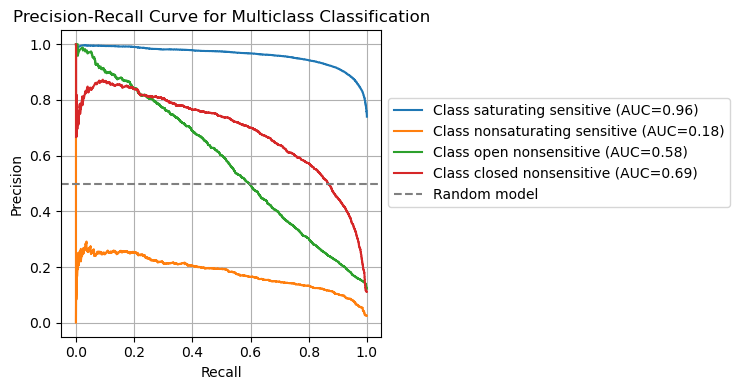

In [172]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_train)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred))
print("\nClassification Report:")
print(classification_report(y_train, y_pred))


from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities
y_scores = model.predict_proba(X_train)  # Probability estimates for the positive class

# Binarize the output for calculating precision-recall
classes = ['saturating sensitive', 'nonsaturating sensitive',
       'open nonsensitive', 'closed nonsensitive']
y_train_bin = label_binarize(y_train, classes=np.unique(y))
n_classes = y_train_bin.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(7.5, 4))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_train_bin[:, i], y_scores[:, i])
    pr_auc = auc(recall, precision)  # Calculate AUC for PR curve
    
    plt.plot(recall, precision, label=f'Class {classes[i]} (AUC={pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.axhline(0.5, linestyle='--', color='grey', label='Random model')
plt.legend(loc="lower left", bbox_to_anchor=[1, 0.4])
plt.grid()
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_chrombp+chromhmmfeat_train.pdf")
plt.show()

### plot PR curves together

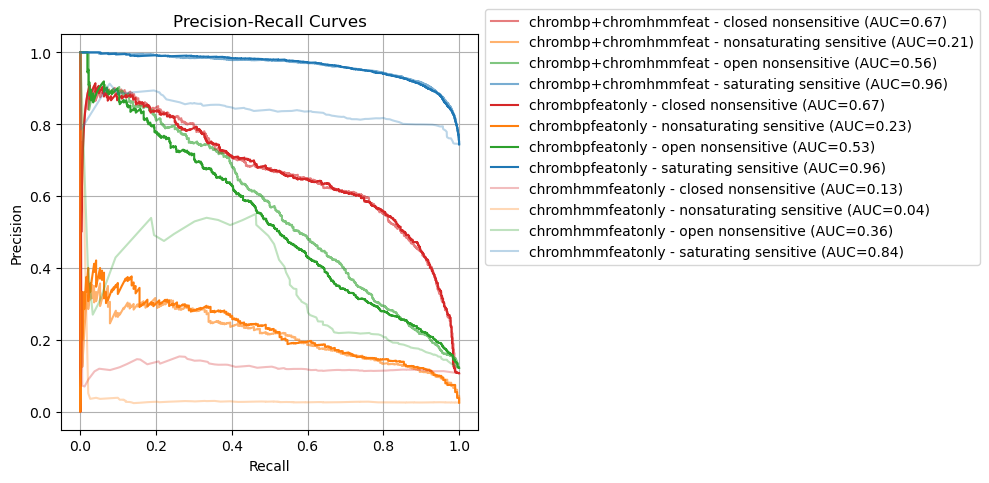

In [318]:
# Set the color palette for the groups
palette = sns.color_palette(n_colors=allpr['group'].nunique())

# Create a color dictionary mapping group to colors
color_dict = {group: palette[i] for i, group in enumerate(classes)}
alpha_dict = {"chrombpfeatonly": 1, "chrombp+chromhmmfeat": 0.6, "chromhmmfeatonly": 0.3, }

# Create the PR curve plot
plt.figure(figsize=(10, 5))

# Loop through each feature to plot the PR curves
for feat, data in allpr.groupby('feat'):
    alpha_value = alpha_dict[feat]
    for group, group_data in data.groupby('group'):
          # Example: Adjust alpha based on feat
        auc_value = allauc.loc[(allauc['feat'] == feat) & (allauc['group'] == group), 'aucpr'].values[0]
        plt.plot(group_data['recall'], group_data['precision'],
                 label=f'{feat} - {group} (AUC={auc_value:.2f})', 
                 color=color_dict[group], 
                 alpha=alpha_value)

# Formatting the plot
plt.title('Precision-Recall Curves')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", bbox_to_anchor=[1, 0.4])
plt.grid()
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_combined.pdf")
plt.show()


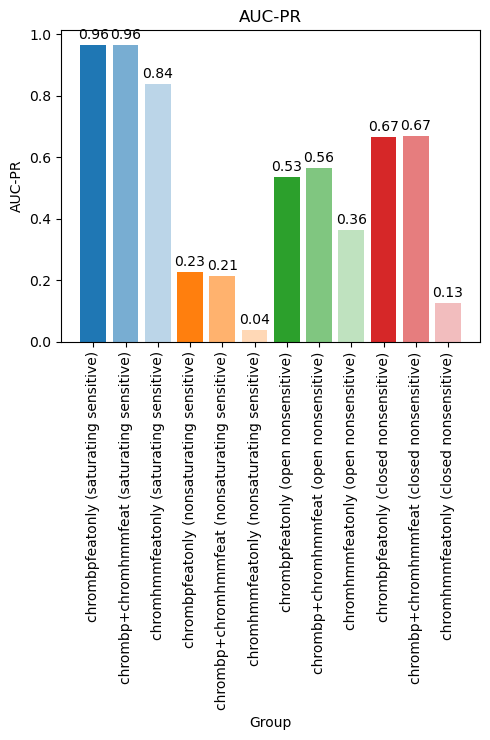

In [233]:
plt.figure(figsize=(5,7.5))

for idx, group in enumerate(allauc['group'].unique()):
    # Filter data for current group
    group_data_raw = allauc[allauc['group'] == group]
    
    for feat in alpha_dict.keys():
        group_data = group_data_raw[group_data_raw["feat"] == feat]
        # Plot bars for the current group
        bars = plt.bar(group_data['feat'] + f' ({group})', group_data['aucpr'], 
                    color=[color_dict[group]]*len(group_data),
                    alpha=alpha_dict[feat])
        # Add AUC text on top of bars
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), 
                    ha='center', va='bottom')

# Adding labels and title
plt.title('AUC-PR')
plt.xlabel('Group')
plt.ylabel('AUC-PR')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"{plotdir}/{TF}_elasticnetLR_AUPR_barplot_combined.pdf")

## Model Eval and Run LR models for all TFs
submit as jobscript, run 15d_job_lr_seq_hm.py

## plot AUCPR across all TFs

In [6]:
aucpr = pd.read_csv(f"{outdir}/all_aucpr_alltf.csv")
aucpr.head()

feat                    group  aucpr    tf  pioneer
0       chrombpfeatonly     saturating sensitive   0.96  SPI1        1
1  chrombp+chromhmmfeat     saturating sensitive   0.96  SPI1        1
2      chromhmmfeatonly     saturating sensitive   0.84  SPI1        1
3       chrombpfeatonly  nonsaturating sensitive   0.23  SPI1        1
4  chrombp+chromhmmfeat  nonsaturating sensitive   0.21  SPI1        1

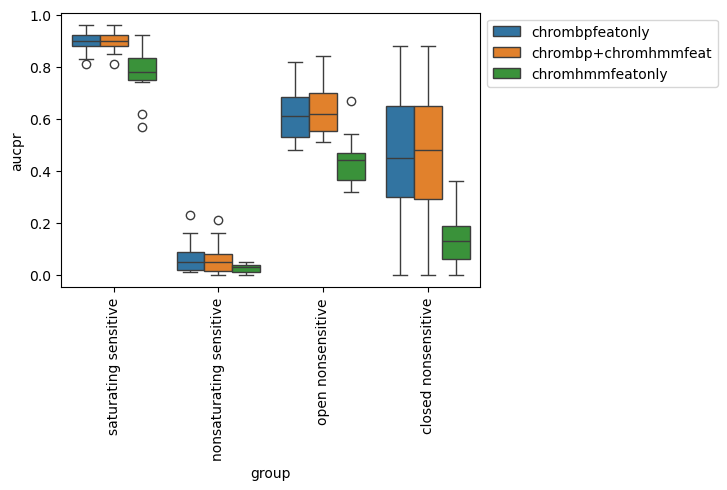

In [28]:
from matplotlib import rcParams
# Configure Matplotlib to embed text as fonts
rcParams['pdf.fonttype'] = 42  # Embed fonts (Type 3 or Type 42)

plt.figure(figsize=(5,5))
sns.boxplot(data=aucpr, x="group", y="aucpr", hue="feat")
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(f"{plotdir}/all_aucpr_alltf.pdf", bbox_inches='tight')

In [19]:
from scipy.stats import ttest_rel

classes = ['saturating sensitive', 'nonsaturating sensitive','open nonsensitive', 'closed nonsensitive']
print("Paired t-test results:")
for group in classes:
    a = aucpr.loc[(aucpr.feat=="chrombpfeatonly") & (aucpr.group==group)].aucpr
    b = aucpr.loc[(aucpr.feat=="chrombp+chromhmmfeat") & (aucpr.group==group)].aucpr
    t_stat, p_value = ttest_rel(a, b)

    # Output the results
    print(f"-----{group}-----")
    print(f"T-statistic: {t_stat:.3f}")
    print(f"P-value: {p_value:.3f}")

Paired t-test results:
-----saturating sensitive-----
T-statistic: -1.491
P-value: 0.167
-----nonsaturating sensitive-----
T-statistic: 2.055
P-value: 0.067
-----open nonsensitive-----
T-statistic: -9.898
P-value: 0.000
-----closed nonsensitive-----
T-statistic: -1.077
P-value: 0.307


/tmp/ipykernel_15882/3990999076.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/3990999076.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/3990999076.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/3990999076.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)


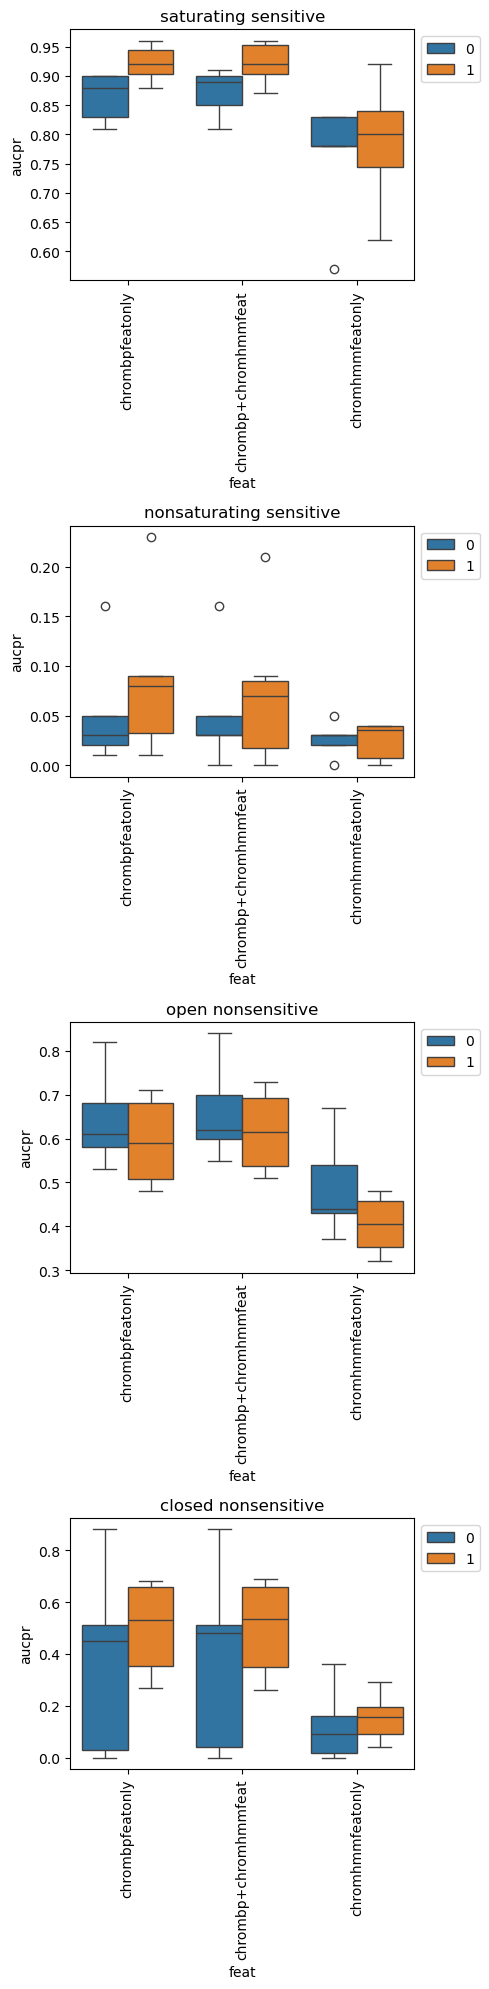

In [47]:
# pioneer vs non pioneer
f,ax = plt.subplots(4,1, figsize=(5,20), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

for i in range(len(classes)):
    subset = aucpr.loc[aucpr.group==classes[i]]
    sns.boxplot(data=subset, x="feat", y="aucpr", hue="pioneer", ax=ax[i])
    ax[i].set_xticklabels(subset["feat"], rotation=90)
    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].set_title(classes[i])
plt.tight_layout()
plt.savefig(f"{plotdir}/all_aucpr_alltf_ispioneer_bysensgroup.pdf", bbox_inches='tight')

/tmp/ipykernel_15882/511165636.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/511165636.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/511165636.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)
/tmp/ipykernel_15882/511165636.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(subset["feat"], rotation=90)


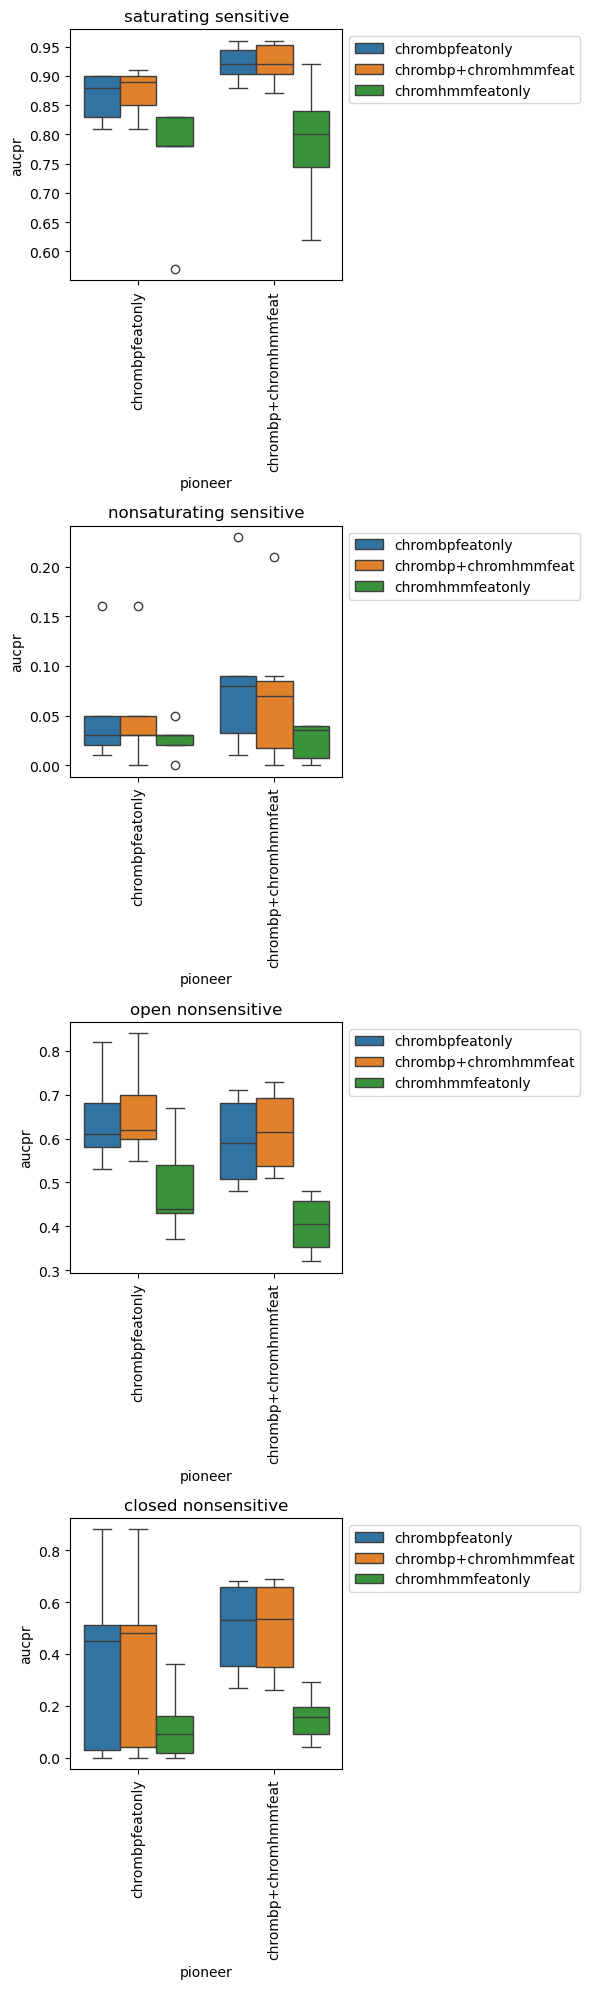

In [49]:
# pioneer vs non pioneer
f,ax = plt.subplots(4,1, figsize=(6,20), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

for i in range(len(classes)):
    subset = aucpr.loc[aucpr.group==classes[i]]
    sns.boxplot(data=subset, x="pioneer", y="aucpr", hue="feat", ax=ax[i])
    ax[i].set_xticklabels(subset["feat"], rotation=90)
    ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax[i].set_title(classes[i])
plt.tight_layout()
plt.savefig(f"{plotdir}/all_aucpr_alltf_ispioneer_bysensgroup_v2.pdf", bbox_inches='tight')